In [50]:
from thesis import SAVED_RESULTS_PATH
from typing import List, Optional
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from thesis import ROOT
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt

BASELINE_METRICS = ['DEGs', 'r2mean_all_boostrap_mean', 'r2mean_top20_boostrap_mean', 'r2mean_top100_boostrap_mean']
DISTANCE_METRICS = ['edistance', 'wasserstein', 'euclidean', 'mean_pairwise', 'mmd']
METRICS = BASELINE_METRICS + DISTANCE_METRICS

FIGURES_PATH = SAVED_RESULTS_PATH / "multi_task_aae_eval" / "figures"

In [51]:
#all_df = pd.read_csv(ROOT / "analysis" / "multi_task_aae.csv")
#all_df_overview = pd.read_csv(ROOT / "analysis" / "multi_task_aae_overview.csv")

all_df = pd.read_csv(ROOT / "analysis" / "metrics.csv")

# rename models

all_df["model"] = all_df["model"].replace(
    {
        "MultiTaskAaeAutoencoderPipeline": "MTAe",
        "MultiTaskAaeAdversarialPipeline": "MTAeAdv",
        "MultiTaskAaeAdversarialGaussianPipeline": "MTAeAdvG",
        "MultiTaskVaeAutoencoderPipeline": "MTVae",
        "MultiTaskAaeAutoencoderOptimalTransportPipeline": "MTAeOT",
        "MultiTaskAaeAutoencoderAndOptimalTransportPipeline": "MTAePlusOT",
        "MultiTaskVaeAutoencoderOptimalTransportPipeline": "MTVaeOT",
        "MultiTaskVaeAutoencoderAndOptimalTransportPipeline": "MTVaePlusOT",
        "ButterflyPipeline": "scButterfly",
        "VidrMultiplePipeline": "vidrMult",
        "VidrSinglePipeline": "vidrSingle",
        "ScGenPipeline": "scGen",
        "ScPreGanPipeline": "scPreGAN"
    }
)

METRICS_DF = all_df
#METRICS_DF_OVERVIEW = all_df_overview
MODELS_MULTI_TASK = [
    "MTAe",
    "MTAeAdv",
    "MTAeAdvG",
    "MTVae",    
    "MTAeOT",
    "MTAePlusOT",
    "MTVaeOT",
    "MTVaePlusOT"    
]
LITERATURE_SINGLE_MODELS = ["scButterfly", "vidrSingle", "scGen", "scPreGAN"]
LITERATURE_MULTI_MODELS = ["scButterfly", "vidrMult", "scGen", "scPreGAN"]
LITERATURE_MODELS = ["scButterfly", "vidrMult", "vidrSingle", "scGen", "scPreGAN"]
MODELS = LITERATURE_MODELS + MODELS_MULTI_TASK

In [52]:
def get_relative_evaluation(dataset):
    relative_df_str = dataset.copy()
    relative_df = dataset.copy()    
    metric_cols = [col for col in dataset.columns if col != 'model']

    for col in metric_cols:
        if col in DISTANCE_METRICS:
            best_val = dataset[col].min()
            worst_val = dataset[col].max()
        else: 
            best_val = dataset[col].max()
            worst_val = dataset[col].min()
        #relative_df[f'{col}'] = (dataset[col] - best_val) / (worst_val - best_val)
        relative_value = (dataset[col] - best_val) / (worst_val - best_val)
        relative_df_str[f'{col}'] = [f"{np.abs(relative):.3f} ({col_value:.3f})" for relative, col_value in zip(relative_value, dataset[col])]
        relative_df[f'{col}'] = relative_value
    return relative_df_str, relative_df

In [53]:
def fix_columns_after_agg(dataset):
    new_columns = []
    for col in dataset.columns:
        if col[1] == "mean" or col[1] == '':
            new_columns.append(col[0])
        else:
            new_columns.append(f"{col[0]}_{col[1]}")
    dataset.columns = new_columns    
    return dataset

In [54]:
dataset_model = METRICS_DF[METRICS_DF['model'].isin(MODELS_MULTI_TASK)]
dataset_model = dataset_model[dataset_model["experiment_name"].str.startswith("seed", na=False)]
dataset_model = dataset_model[dataset_model["dataset"] == "CrossSpeciesConditionPipeline_CrossSpeciesPipeline"]
dataset_model = dataset_model.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset_model_literature = METRICS_DF[METRICS_DF['model'].isin(LITERATURE_MODELS)]
dataset_model_literature_model = dataset_model_literature[dataset_model_literature["experiment_name"].str.startswith("seed", na=False)]
dataset_model_literature = dataset_model_literature[dataset_model_literature["dataset"] == "CrossSpeciesConditionPipeline_CrossSpeciesPipeline"]
dataset_model_literature = dataset_model_literature.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset = pd.concat([dataset_model, dataset_model_literature])
dataset = fix_columns_after_agg(dataset)
relative_cross_species_df_str, relative_cross_species_df = get_relative_evaluation(dataset)
relative_cross_species_df_str

model            DEGs r2mean_all_boostrap_mean  \
0         MTAe  0.000 (16.083)            0.316 (0.740)   
1      MTAeAdv  0.547 (11.250)            0.686 (0.579)   
2     MTAeAdvG  0.406 (12.500)            0.391 (0.708)   
3       MTAeOT   0.972 (7.500)            0.908 (0.483)   
4   MTAePlusOT   0.915 (8.000)            0.915 (0.480)   
5        MTVae  0.406 (12.500)            0.518 (0.652)   
6      MTVaeOT   0.981 (7.417)            0.917 (0.479)   
7  MTVaePlusOT   0.934 (7.833)            0.932 (0.473)   
0  scButterfly  0.604 (10.750)            0.700 (0.574)   
1        scGen   0.962 (7.583)            0.118 (0.826)   
2     scPreGAN   1.000 (7.250)            1.000 (0.443)   
3   vidrSingle  0.358 (12.917)            0.000 (0.878)   

  r2mean_top20_boostrap_mean r2mean_top100_boostrap_mean      edistance  \
0              0.451 (0.559)               0.519 (0.481)  0.036 (0.930)   
1              0.731 (0.465)               0.790 (0.365)  0.010 (0.865)   
2              0.528 (0.533)               0.577 (0.456)  0.032 (0.921)   
3              0.827 (0.432)               0.934 (0.304)  0.023 (0.899)   
4              0.815 (0.436)               0.923 (0.309)  0.014 (0.876)   
5              0.631 (0.498)               0.677 (0.413)  0.000 (0.840)   
6              0.855 (0.423)               0.940 (0.302)  0.022 (0.895)   
7              0.830 (0.431)               0.942 (0.301)  0.017 (0.883)   
0              0.956 (0.389)               0.835 (0.346)  0.023 (0.899)   
1              0.016 (0.705)               0.100 (0.658)  0.461 (2.014)   
2              1.000 (0.374)               1.000 (0.276)  0.029 (0.914)   
3              0.000 (0.711)               0.000 (0.701)  1.000 (3.386)   

     wasserstein      euclidean  mean_pairwise            mmd  
0  0.104 (1.008)  0.055 (0.962)  0.161 (0.995)  0.036 (0.930)  
1  0.015 (0.919)  0.016 (0.929)  0.020 (0.957)  0.010 (0.865)  
2  0.082 (0.985)  0.049 (0.958)  0.132 (0.987)  0.032 (0.921)  
3  0.029 (0.932)  0.038 (0.948)  0.053 (0.966)  0.023 (0.899)  
4  0.010 (0.913)  0.023 (0.936)  0.017 (0.956)  0.014 (0.876)  
5  0.000 (0.903)  0.000 (0.916)  0.000 (0.951)  0.000 (0.840)  
6  0.026 (0.929)  0.035 (0.946)  0.046 (0.964)  0.022 (0.895)  
7  0.016 (0.919)  0.028 (0.940)  0.028 (0.959)  0.017 (0.883)  
0  0.039 (0.942)  0.038 (0.948)  0.074 (0.971)  0.023 (0.899)  
1  0.672 (1.576)  0.529 (1.367)  0.779 (1.165)  0.461 (2.014)  
2  0.042 (0.945)  0.047 (0.955)  0.079 (0.973)  0.029 (0.914)  
3  1.000 (1.905)  1.000 (1.769)  1.000 (1.225)  1.000 (3.386)

In [55]:
dataset_model = METRICS_DF[METRICS_DF['model'].isin(MODELS_MULTI_TASK)]
dataset_model = dataset_model[dataset_model["experiment_name"].str.startswith("seed", na=False)]
dataset_model = dataset_model[dataset_model["dataset"] == "CrossStudyConditionPipeline_CrossStudyPipeline"]
dataset_model = dataset_model.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset_model_literature = METRICS_DF[METRICS_DF['model'].isin(LITERATURE_MODELS)]
dataset_model_literature_model = dataset_model_literature[dataset_model_literature["experiment_name"].str.startswith("seed", na=False)]
dataset_model_literature = dataset_model_literature[dataset_model_literature["dataset"] == "CrossStudyConditionPipeline_CrossStudyPipeline"]
dataset_model_literature = dataset_model_literature.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset = pd.concat([dataset_model, dataset_model_literature])
dataset = fix_columns_after_agg(dataset)
relative_cross_study_df_str, relative_cross_study_df = get_relative_evaluation(dataset)
relative_cross_study_df_str

model            DEGs r2mean_all_boostrap_mean  \
0         MTAe  0.066 (64.048)            0.224 (0.902)   
1      MTAeAdv  0.166 (59.000)            0.161 (0.922)   
2     MTAeAdvG  0.230 (55.762)            0.227 (0.901)   
3       MTAeOT  0.674 (33.381)            1.000 (0.658)   
4   MTAePlusOT  0.893 (22.333)            0.945 (0.675)   
5        MTVae  0.194 (57.619)            0.208 (0.907)   
6      MTVaeOT  0.737 (30.238)            0.948 (0.674)   
7  MTVaePlusOT  0.970 (18.476)            0.967 (0.668)   
0  scButterfly  0.000 (67.381)            0.060 (0.954)   
1        scGen  0.495 (42.429)            0.147 (0.927)   
2     scPreGAN  0.483 (43.000)            0.602 (0.783)   
3   vidrSingle  1.000 (16.952)            0.000 (0.973)   

  r2mean_top20_boostrap_mean r2mean_top100_boostrap_mean      edistance  \
0              0.369 (0.882)               0.223 (0.904)  0.446 (0.344)   
1              0.277 (0.906)               0.158 (0.922)  0.228 (0.210)   
2              0.393 (0.876)               0.217 (0.906)  0.382 (0.305)   
3              1.000 (0.720)               1.000 (0.687)  0.992 (0.683)   
4              0.961 (0.730)               0.946 (0.702)  1.000 (0.687)   
5              0.298 (0.901)               0.154 (0.923)  0.258 (0.228)   
6              0.958 (0.731)               0.935 (0.705)  0.930 (0.644)   
7              0.977 (0.726)               0.972 (0.694)  0.973 (0.670)   
0              0.000 (0.977)               0.037 (0.956)  0.184 (0.182)   
1              0.317 (0.896)               0.225 (0.903)  0.673 (0.485)   
2              0.480 (0.854)               0.544 (0.814)  0.667 (0.481)   
3              0.022 (0.971)               0.000 (0.966)  0.000 (0.068)   

     wasserstein      euclidean  mean_pairwise            mmd  
0  0.733 (0.794)  0.528 (0.538)  0.746 (0.876)  0.446 (0.344)  
1  0.383 (0.610)  0.337 (0.436)  0.347 (0.773)  0.228 (0.210)  
2  0.563 (0.704)  0.476 (0.510)  0.558 (0.828)  0.382 (0.305)  
3  0.964 (0.916)  1.000 (0.789)  0.970 (0.934)  0.992 (0.683)  
4  1.000 (0.935)  0.996 (0.787)  1.000 (0.942)  1.000 (0.687)  
5  0.346 (0.590)  0.383 (0.461)  0.305 (0.763)  0.258 (0.228)  
6  0.915 (0.890)  0.960 (0.768)  0.924 (0.922)  0.930 (0.644)  
7  0.960 (0.914)  0.982 (0.780)  0.960 (0.932)  0.973 (0.670)  
0  0.226 (0.527)  0.273 (0.402)  0.214 (0.739)  0.184 (0.182)  
1  0.729 (0.792)  0.787 (0.676)  0.840 (0.901)  0.673 (0.485)  
2  0.505 (0.674)  0.780 (0.672)  0.597 (0.838)  0.667 (0.481)  
3  0.000 (0.408)  0.000 (0.257)  0.000 (0.684)  0.000 (0.068)

In [56]:
dataset_model = METRICS_DF[METRICS_DF['model'].isin(MODELS_MULTI_TASK)]
dataset_model = dataset_model[dataset_model["experiment_name"].str.startswith("bugfix", na=False)]
dataset_model = dataset_model[dataset_model["dataset"] == "PbmcSinglePipeline_PbmcPipeline"]
dataset_model = dataset_model.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset_model_literature = METRICS_DF[METRICS_DF['model'].isin(LITERATURE_MODELS)]
dataset_model_literature_model = dataset_model_literature[dataset_model_literature["experiment_name"].str.startswith("seed", na=False)]
dataset_model_literature = dataset_model_literature[dataset_model_literature["dataset"] == "PbmcSinglePipeline_PbmcPipeline"]
dataset_model_literature = dataset_model_literature.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset = pd.concat([dataset_model, dataset_model_literature])
dataset = fix_columns_after_agg(dataset)
relative_pbmc_df_str, relative_pbmc_df = get_relative_evaluation(dataset)
relative_pbmc_df_str

model            DEGs r2mean_all_boostrap_mean  \
0         MTAe  0.000 (75.714)            0.077 (0.946)   
1      MTAeAdv  0.066 (72.381)            0.026 (0.961)   
2     MTAeAdvG  0.195 (65.905)            0.168 (0.917)   
3       MTAeOT  0.688 (41.190)            1.000 (0.657)   
4   MTAePlusOT  0.768 (37.190)            0.960 (0.670)   
5        MTVae  0.132 (69.095)            0.088 (0.942)   
6      MTVaeOT  0.720 (39.571)            0.961 (0.669)   
7  MTVaePlusOT  0.899 (30.619)            0.987 (0.661)   
0  scButterfly  0.299 (60.727)            0.251 (0.891)   
1        scGen  0.868 (32.143)            0.191 (0.910)   
2     scPreGAN  0.796 (35.750)            0.634 (0.771)   
3   vidrSingle  1.000 (25.536)            0.000 (0.970)   

  r2mean_top20_boostrap_mean r2mean_top100_boostrap_mean      edistance  \
0              0.330 (0.871)               0.140 (0.917)  0.479 (0.488)   
1              0.053 (0.955)               0.043 (0.948)  0.032 (0.202)   
2              0.305 (0.878)               0.192 (0.901)  0.503 (0.504)   
3              1.000 (0.668)               1.000 (0.648)  0.984 (0.811)   
4              0.983 (0.674)               0.970 (0.657)  0.982 (0.810)   
5              0.056 (0.954)               0.105 (0.928)  0.125 (0.261)   
6              0.969 (0.678)               0.953 (0.663)  0.988 (0.813)   
7              0.994 (0.670)               0.976 (0.655)  1.000 (0.821)   
0              0.187 (0.914)               0.232 (0.889)  0.140 (0.271)   
1              0.326 (0.872)               0.290 (0.870)  0.697 (0.627)   
2              0.376 (0.857)               0.518 (0.799)  0.496 (0.499)   
3              0.000 (0.971)               0.000 (0.961)  0.000 (0.182)   

     wasserstein      euclidean  mean_pairwise            mmd  
0  0.815 (0.892)  0.506 (0.651)  0.898 (0.949)  0.479 (0.488)  
1  0.006 (0.604)  0.044 (0.429)  0.110 (0.800)  0.032 (0.202)  
2  0.636 (0.828)  0.570 (0.681)  0.689 (0.909)  0.503 (0.504)  
3  0.969 (0.947)  0.990 (0.883)  0.976 (0.963)  0.984 (0.811)  
4  0.982 (0.951)  0.983 (0.880)  0.988 (0.966)  0.982 (0.810)  
5  0.056 (0.621)  0.189 (0.499)  0.114 (0.800)  0.125 (0.261)  
6  0.993 (0.955)  0.990 (0.883)  0.992 (0.966)  0.988 (0.813)  
7  1.000 (0.958)  1.000 (0.888)  1.000 (0.968)  1.000 (0.821)  
0  0.000 (0.601)  0.128 (0.469)  0.000 (0.779)  0.140 (0.271)  
1  0.863 (0.909)  0.744 (0.765)  0.885 (0.946)  0.697 (0.627)  
2  0.248 (0.690)  0.572 (0.682)  0.381 (0.851)  0.496 (0.499)  
3  0.014 (0.606)  0.000 (0.408)  0.096 (0.797)  0.000 (0.182)

In [57]:
def get_evaluation_pca(dataset):
    metrics = dataset[METRICS]
    adata = AnnData(X=metrics)
    adata.obs_names = dataset["model"].astype(str).values
    adata.var_names = METRICS

    sc.tl.pca(adata)
    sc.pl.pca(adata)

    X = adata.obsm["X_pca"]
    labels = adata.obs_names

    plt.figure(figsize=(12, 6))
    plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.2)

    for i, label in enumerate(labels):
        plt.text(X[i, 0], X[i, 1], str(label), ha='center', va='top', fontsize=8)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.tight_layout()
    plt.show()
    
def get_evaluation_umap(dataset):
    metrics = dataset[METRICS]
    adata = AnnData(X=metrics)
    adata.obs_names = dataset["model"].astype(str).values
    adata.var_names = METRICS

    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata)

    X = adata.obsm["X_umap"]
    labels = adata.obs_names

    plt.figure(figsize=(12, 6))
    plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.2)

    for i, label in enumerate(labels):
        plt.text(X[i, 0], X[i, 1], str(label), ha='center', va='top', fontsize=8)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    #plt.title("UMAP (Labeled Models)")
    plt.tight_layout()
    plt.show()    

In [58]:
dataset_model = METRICS_DF[METRICS_DF['model'].isin(MODELS_MULTI_TASK)]
dataset_model = dataset_model[dataset_model["experiment_name"].str.startswith("bugfix", na=False)]
dataset_model = dataset_model[dataset_model["dataset"] == "NaultMultiplePipeline_NaultPipeline"]
dataset_model = dataset_model.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset_model_literature = METRICS_DF[METRICS_DF['model'].isin(LITERATURE_MODELS)]
dataset_model_literature = dataset_model_literature[dataset_model_literature["experiment_name"].str.startswith("seed", na=False)]
dataset_model_literature = dataset_model_literature[dataset_model_literature["dataset"].isin(["NaultMultiplePipeline_NaultPipeline", "NaultSinglePipeline_NaultPipeline"])]
dataset_model_literature = dataset_model_literature.groupby(["model"])[METRICS].agg(['mean']).reset_index()

dataset = pd.concat([dataset_model, dataset_model_literature])
dataset = fix_columns_after_agg(dataset)
relative_nault_df_str, relative_nault_df = get_relative_evaluation(dataset)
relative_nault_df_str

model            DEGs r2mean_all_boostrap_mean  \
0         MTAe  0.000 (20.341)            0.167 (0.862)   
1      MTAeAdv  0.368 (13.716)            0.388 (0.792)   
2     MTAeAdvG  0.113 (18.307)            0.339 (0.808)   
3       MTAeOT   0.650 (8.652)            0.969 (0.608)   
4   MTAePlusOT   0.657 (8.519)            0.956 (0.613)   
5        MTVae  0.076 (18.981)            0.339 (0.808)   
6      MTVaeOT   0.677 (8.163)            0.953 (0.614)   
7  MTVaePlusOT   0.647 (8.701)            0.948 (0.615)   
0  scButterfly  0.196 (16.818)            0.553 (0.740)   
1        scGen   0.781 (6.288)            0.000 (0.915)   
2     scPreGAN  0.324 (14.511)            1.000 (0.599)   
3     vidrMult   1.000 (2.352)            0.143 (0.870)   
4   vidrSingle   0.920 (3.795)            0.191 (0.855)   

  r2mean_top20_boostrap_mean r2mean_top100_boostrap_mean      edistance  \
0              0.267 (0.792)               0.189 (0.833)  0.056 (1.386)   
1              0.518 (0.725)               0.458 (0.743)  0.025 (1.128)   
2              0.477 (0.736)               0.396 (0.764)  0.029 (1.164)   
3              0.829 (0.642)               0.916 (0.590)  0.001 (0.925)   
4              0.822 (0.644)               0.897 (0.596)  0.000 (0.917)   
5              0.523 (0.724)               0.428 (0.753)  0.025 (1.124)   
6              0.830 (0.642)               0.906 (0.593)  0.001 (0.929)   
7              0.816 (0.645)               0.894 (0.597)  0.000 (0.919)   
0              0.633 (0.694)               0.600 (0.696)  0.008 (0.984)   
1              0.000 (0.863)               0.000 (0.897)  0.178 (2.408)   
2              1.000 (0.596)               1.000 (0.562)  0.007 (0.972)   
3              0.099 (0.837)               0.133 (0.852)  1.000 (9.295)   
4              0.247 (0.797)               0.216 (0.824)  0.061 (1.431)   

     wasserstein      euclidean  mean_pairwise            mmd  
0  0.603 (1.217)  0.116 (1.116)  0.945 (1.050)  0.056 (1.386)  
1  0.246 (1.091)  0.045 (1.011)  0.426 (1.017)  0.025 (1.128)  
2  0.293 (1.107)  0.058 (1.030)  0.607 (1.029)  0.029 (1.164)  
3  0.008 (1.006)  0.005 (0.951)  0.122 (0.998)  0.001 (0.925)  
4  0.000 (1.004)  0.002 (0.948)  0.099 (0.996)  0.000 (0.917)  
5  0.273 (1.100)  0.041 (1.005)  0.413 (1.016)  0.025 (1.124)  
6  0.016 (1.009)  0.006 (0.952)  0.132 (0.998)  0.001 (0.929)  
7  0.008 (1.006)  0.003 (0.948)  0.112 (0.997)  0.000 (0.919)  
0  0.029 (1.014)  0.000 (0.944)  0.000 (0.990)  0.008 (0.984)  
1  0.637 (1.229)  0.299 (1.387)  0.805 (1.041)  0.178 (2.408)  
2  0.042 (1.019)  0.017 (0.969)  0.163 (1.000)  0.007 (0.972)  
3  1.000 (1.358)  1.000 (2.425)  1.000 (1.054)  1.000 (9.295)  
4  0.480 (1.174)  0.117 (1.118)  0.544 (1.025)  0.061 (1.431)

In [ ]:
print(relative_nault_df_str.to_latex(index=False, caption="Nault Pipeline"))
print()
print(relative_pbmc_df_str.to_latex(index=False, caption="Pbmc Pipeline"))
print()
print(relative_cross_study_df_str.to_latex(index=False, caption="Pbmc Pipeline"))
print()
print(relative_cross_species_df_str.to_latex(index=False, caption="Pbmc Pipeline"))

\begin{table}
\caption{Nault Pipeline}
\begin{tabular}{llllllllll}
\toprule
model & DEGs & r2mean_all_boostrap_mean & r2mean_top20_boostrap_mean & r2mean_top100_boostrap_mean & edistance & wasserstein & euclidean & mean_pairwise & mmd \\
\midrule
MTAe & 0.000 (20.341) & 0.167 (0.862) & 0.267 (0.792) & 0.189 (0.833) & 0.056 (1.386) & 0.603 (1.217) & 0.116 (1.116) & 0.945 (1.050) & 0.056 (1.386) \\
MTAeAdv & 0.368 (13.716) & 0.388 (0.792) & 0.518 (0.725) & 0.458 (0.743) & 0.025 (1.128) & 0.246 (1.091) & 0.045 (1.011) & 0.426 (1.017) & 0.025 (1.128) \\
MTAeAdvG & 0.113 (18.307) & 0.339 (0.808) & 0.477 (0.736) & 0.396 (0.764) & 0.029 (1.164) & 0.293 (1.107) & 0.058 (1.030) & 0.607 (1.029) & 0.029 (1.164) \\
MTAeOT & 0.650 (8.652) & 0.969 (0.608) & 0.829 (0.642) & 0.916 (0.590) & 0.001 (0.925) & 0.008 (1.006) & 0.005 (0.951) & 0.122 (0.998) & 0.001 (0.925) \\
MTAePlusOT & 0.657 (8.519) & 0.956 (0.613) & 0.822 (0.644) & 0.897 (0.596) & 0.000 (0.917) & 0.000 (1.004) & 0.002 (0.948) & 0.099 (0

In [60]:
# get_evaluation_pca(relative_pbmc_df)
# get_evaluation_umap(relative_pbmc_df)
# get_evaluation_pca(relative_nault_df)
# get_evaluation_umap(relative_nault_df)

In [61]:
def get_total_score(df):
    score_df = df.copy()
    score_df['score'] = score_df[METRICS].sum(axis=1)
    
    score_df['baseline_score'] = score_df[BASELINE_METRICS].sum(axis=1)
    
    score_df['distance_score'] = score_df[DISTANCE_METRICS].sum(axis=1)
    
    return score_df[['model', 'score', 'baseline_score', 'distance_score']].sort_values(by='score')
        
score_pbmc = get_total_score(relative_pbmc_df)
score_pbmc

model     score  baseline_score  distance_score
1      MTAeAdv  0.414099        0.188957        0.225142
5        MTVae  0.989313        0.381226        0.608087
3   vidrSingle  1.109933        1.000000        0.109933
0  scButterfly  1.375249        0.968395        0.406855
0         MTAe  3.723979        0.546259        3.177721
2     MTAeAdvG  3.762873        0.860886        2.901987
2     scPreGAN  4.519561        2.325642        2.193919
1        scGen  5.559246        1.674543        3.884703
6      MTVaeOT  8.552051        3.602547        4.949504
3       MTAeOT  8.590746        3.688019        4.902727
4   MTAePlusOT  8.598116        3.680466        4.917650
7  MTVaePlusOT  8.855812        3.855812        5.000000

In [62]:
score_cross_study = get_total_score(relative_cross_study_df)
score_cross_study

model     score  baseline_score  distance_score
3   vidrSingle  1.022251        1.022251        0.000000
0  scButterfly  1.177201        0.097338        1.079863
1      MTAeAdv  2.287284        0.763252        1.524032
5        MTVae  2.403579        0.853503        1.550076
2     MTAeAdvG  3.430162        1.068459        2.361703
0         MTAe  3.780031        0.881922        2.898110
1        scGen  4.886600        1.184490        3.702110
2     scPreGAN  5.326055        2.109282        3.216773
6      MTVaeOT  8.237092        3.578456        4.658636
3       MTAeOT  8.593334        3.674221        4.919113
7  MTVaePlusOT  8.732940        3.885585        4.847355
4   MTAePlusOT  8.741812        3.745904        4.995908

In [63]:
score_cross_species = get_total_score(relative_cross_species_df)
score_cross_species

model     score  baseline_score  distance_score
0         MTAe  1.676506        1.285196        0.391310
2     MTAeAdvG  2.227590        1.901575        0.326015
5        MTVae  2.232088        2.232088        0.000000
1      MTAeAdv  2.826189        2.754406        0.071783
0  scButterfly  3.291590        3.094464        0.197126
4   MTAePlusOT  3.646820        3.568396        0.078425
7  MTVaePlusOT  3.743715        3.637807        0.105908
3       MTAeOT  3.806643        3.640329        0.166315
6      MTVaeOT  3.845143        3.693929        0.151214
1        scGen  4.098110        1.196070        2.902040
2     scPreGAN  4.225735        4.000000        0.225735
3   vidrSingle  5.358491        0.358491        5.000000

In [64]:
score_nault = get_total_score(relative_nault_df)
score_nault

model     score  baseline_score  distance_score
0  scButterfly  2.026767        1.981569        0.045198
5        MTVae  2.142595        1.365570        0.777025
2     MTAeAdvG  2.341641        1.324716        1.016925
0         MTAe  2.398554        0.622043        1.776511
1      MTAeAdv  2.498785        1.731406        0.767379
4   vidrSingle  2.837696        1.573823        1.263873
1        scGen  2.878990        0.781217        2.097772
7  MTVaePlusOT  3.428329        3.305106        0.123224
4   MTAePlusOT  3.433685        3.332175        0.101511
3       MTAeOT  3.500992        3.363746        0.137247
6      MTVaeOT  3.522593        3.365641        0.156953
2     scPreGAN  3.559583        3.324068        0.235515
3     vidrMult  6.375357        1.375357        5.000000

In [65]:
print(score_pbmc.to_latex(index=False, caption="Score Pbmc Pipeline"))
print()
print(score_nault.to_latex(index=False, caption="Score Nault Pipeline"))
print()
print(score_cross_study.to_latex(index=False, caption="Score Cross Study Pipeline"))
print()
print(score_cross_species.to_latex(index=False, caption="Score Cross Species Pipeline"))

\begin{table}
\caption{Score Pbmc Pipeline}
\begin{tabular}{lrrr}
\toprule
model & score & baseline_score & distance_score \\
\midrule
MTAeAdv & 0.414099 & 0.188957 & 0.225142 \\
MTVae & 0.989313 & 0.381226 & 0.608087 \\
vidrSingle & 1.109933 & 1.000000 & 0.109933 \\
scButterfly & 1.375249 & 0.968395 & 0.406855 \\
MTAe & 3.723979 & 0.546259 & 3.177721 \\
MTAeAdvG & 3.762873 & 0.860886 & 2.901987 \\
scPreGAN & 4.519561 & 2.325642 & 2.193919 \\
scGen & 5.559246 & 1.674543 & 3.884703 \\
MTVaeOT & 8.552051 & 3.602547 & 4.949504 \\
MTAeOT & 8.590746 & 3.688019 & 4.902727 \\
MTAePlusOT & 8.598116 & 3.680466 & 4.917650 \\
MTVaePlusOT & 8.855812 & 3.855812 & 5.000000 \\
\bottomrule
\end{tabular}
\end{table}


\begin{table}
\caption{Score Nault Pipeline}
\begin{tabular}{lrrr}
\toprule
model & score & baseline_score & distance_score \\
\midrule
scButterfly & 2.026767 & 1.981569 & 0.045198 \\
MTVae & 2.142595 & 1.365570 & 0.777025 \\
MTAeAdvG & 2.341641 & 1.324716 & 1.016925 \\
MTAe & 2.398554 & 

In [66]:
selected_models =  ["MTAe", "MTAeAdv", "MTAeAdvG", "MTVae"]

In [67]:
def _plot_2d_metrics(
    dataset: DataFrame,
    title: str,
    x_labels: List[str],
    metrics: List[str] = BASELINE_METRICS,
    models=MODELS,
    file_name_to_save: Optional[str] = None,
):
    x = np.arange(len(x_labels))
    width = 0.08
    
    nrows = int(np.ceil(len(metrics) / 2))

    fig, axes = plt.subplots(nrows, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        start = -(len(models) // 2)
        start = start if len(models) % 2 != 0 else start - 1
        end = len(models) // 2
        x_bars = [x + i * width for i in range(start, end + 1, 1)]
        for experiment, x_bar in zip(models, x_bars):
            ax.bar(
                x_bar,
                dataset[dataset["model"] == experiment][metric],
                width,
                label=experiment,
                alpha=0.7,
            )

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.set_ylabel(metric)
        # ax.set_title(f"Comparison of {metric}")
        
    if len(metrics) % 2 != 0:
        fig.delaxes(axes[-1])

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
    fig.suptitle(title)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at the top for the legend
    if file_name_to_save:
        plt.savefig(
            FIGURES_PATH / f"{file_name_to_save}.pdf", dpi=300, bbox_inches="tight"
        )
    plt.show()


def plot_2d_metrics_per_dosage(
    dataset,
    title: str,
    cell_type: str,
    models=MODELS,
    file_name_to_save: Optional[str] = None,
    metrics=BASELINE_METRICS,
):

    dataset = dataset[dataset["cell_type_test"] == cell_type].sort_values("dose")
    dosages = sorted(
        dataset["dose"].unique().tolist()
    )
    #assert len(dosages) > 1
    _plot_2d_metrics(
        dataset=dataset,
        title=title,
        x_labels=dosages,
        models=models,
        file_name_to_save=file_name_to_save,
        metrics=metrics
    )


def plot_2d_metrics_per_cell_type(
    dataset,
    title: str,
    models=MODELS,
    file_name_to_save: Optional[str] = None,
    metrics=BASELINE_METRICS,
):
    dataset = dataset.sort_values("cell_type_test")
    cell_types = sorted(dataset["cell_type_test"].unique().tolist())
    _plot_2d_metrics(
        dataset=dataset,
        title=title,
        x_labels=cell_types,
        models=models,
        file_name_to_save=file_name_to_save,
        metrics=metrics
    )

In [68]:
from enum import Enum
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


class PlotType(Enum):
    Violin = 0
    Boxplot = 1


class DimToReduce(Enum):
    X = 0
    Y = 1


def get_plot(
    dataset: DataFrame,
    x_key: str,
    y_key: str,
    title: str,
    dim_to_reduce: DimToReduce,
    plot_type=PlotType.Violin,
    metrics: List[str] = [
        "DEGs",
        "r2mean",
        "r2mean_top20_boostrap_mean",
        "r2mean_top100_boostrap_mean",
    ],
    file_name_to_save: Optional[str] = None,
    models: List[str] = MODELS
):
    dataset = dataset.sort_values(by=[x_key, y_key])
    x_labels_init = sorted(dataset[x_key].unique().tolist())
    y_labels_init = sorted(dataset[y_key].unique().tolist())

    x = np.arange(len(x_labels_init))
    y = np.arange(len(y_labels_init))
    width = 0.1
    
    nrows = int(np.ceil(len(metrics) / 2))

    fig, axes = plt.subplots(nrows, 2, figsize=(14, 10))
    axes = axes.flatten()

    x_labels = x_labels_init if dim_to_reduce == DimToReduce.Y else y_labels_init
    y_labels = y_labels_init if dim_to_reduce == DimToReduce.Y else x_labels_init
    x = x if dim_to_reduce == DimToReduce.Y else y
    x_key = x_key if dim_to_reduce == DimToReduce.Y else y_key
    
    def _plot(ax, metric):
        start = -(len(models) // 2)
        start = start if len(models) % 2 != 0 else start - 1
        end = len(models) // 2
        x_bars = [x + i * width for i in range(start, end + 1, 1)]
        for model_index, (model, x_bar) in enumerate(zip(models, x_bars)):
            dataset_model = dataset[dataset["model"] == model]

            plot_data = []
            for x_label in x_labels:
                plot_data.append(
                    dataset_model[dataset_model[x_key] == x_label][metric].values.tolist()
                )
                assert len(plot_data[-1]) == len(y_labels), f"len(plot_data[-1])={len(plot_data[-1])} != len(y_labels)={len(y_labels)}, model {model}"

            if plot_type == PlotType.Violin:
                ax.violinplot(
                    dataset=plot_data,
                    positions=x_bar,
                    widths=width,
                    vert=True,
                    showmedians=True,
                )
            elif plot_type == PlotType.Boxplot:
                ax.boxplot(
                    plot_data,
                    positions=x_bar,
                    widths=width,
                    patch_artist=True,
                    boxprops=dict(facecolor=f"C{model_index}", color="black"),
                    medianprops=dict(color="black"),
                )
            else: 
                raise NotImplementedError

    for ax, metric in zip(axes, metrics):
        _plot(ax, metric)

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.set_ylabel(metric)
        
    if len(metrics) % 2 != 0:
        fig.delaxes(axes[-1])

    # Create custom legend handles
    legend_handles = [mpatches.Patch(color=f"C{i}", label=model) for i, model in enumerate(models)]
    
    # Add custom legend
    fig.legend(legend_handles, [model for model in models], loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
    fig.suptitle(title)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at the top for the legend
    if file_name_to_save is not None:
        fig.savefig(FIGURES_PATH / f'{file_name_to_save}.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [69]:
def get_dataset_literature_and_multi_task_per_seed_nault(seed: int):
    dataset_single_task = METRICS_DF[METRICS_DF["model"].isin(LITERATURE_MODELS)]
    dataset_single_task = dataset_single_task[
        dataset_single_task["dataset"].isin(
            ["NaultSinglePipeline_NaultPipeline", "NaultMultiplePipeline_NaultPipeline"]
        )
    ]
    dataset_single_task = dataset_single_task[
        dataset_single_task["experiment_name"].isin([f"seed_{seed}"])
    ]

    num_cell_types = 11
    num_dosages = 8
    assert len(dataset_single_task) == num_cell_types * num_dosages * len(
        LITERATURE_MODELS
    ), f"seed{seed}, len(dataset_single_task)={len(dataset_single_task)} != {num_cell_types} * {num_dosages} * {len(LITERATURE_MODELS)}"

    dataset_multi_task = METRICS_DF[METRICS_DF["model"].isin(MODELS_MULTI_TASK)]
    dataset_multi_task = dataset_multi_task[
        dataset_multi_task["dataset"].isin(["NaultMultiplePipeline_NaultPipeline"])
    ]
    dataset_multi_task = dataset_multi_task[
        dataset_multi_task["experiment_name"].isin([f"bugfix_seed_{seed}"])
    ]

    assert len(dataset_multi_task) == num_cell_types * num_dosages * len(
        MODELS_MULTI_TASK
    ), f"seed{seed}, len(dataset_multi_task)={len(dataset_multi_task)} != {num_cell_types} * {num_dosages} * {len(MODELS_MULTI_TASK)}"

    dataset = pd.concat([dataset_single_task, dataset_multi_task])
    return dataset


def get_dataset_literature_and_multi_task_per_seed_pbmc(seed: int):
    dataset_single_task = METRICS_DF[METRICS_DF["model"].isin(LITERATURE_SINGLE_MODELS)]
    dataset_single_task = dataset_single_task[
        dataset_single_task["dataset"].isin(["PbmcSinglePipeline_PbmcPipeline"])
    ]
    dataset_single_task = dataset_single_task[
        dataset_single_task["experiment_name"].isin([f"seed_{seed}"])
    ]

    num_cell_types = 7
    assert len(dataset_single_task) == num_cell_types * len(
        LITERATURE_SINGLE_MODELS
    ), f"seed{seed}, len(dataset_single_task)={len(dataset_single_task)} != {num_cell_types} * {len(LITERATURE_SINGLE_MODELS)}"

    dataset_multi_task = METRICS_DF[METRICS_DF["model"].isin(MODELS_MULTI_TASK)]
    dataset_multi_task = dataset_multi_task[
        dataset_multi_task["dataset"].isin(["PbmcSinglePipeline_PbmcPipeline"])
    ]
    dataset_multi_task = dataset_multi_task[
        dataset_multi_task["experiment_name"].isin([f"bugfix_seed_{seed}"])
    ]

    assert len(dataset_multi_task) == num_cell_types * len(
        MODELS_MULTI_TASK
    ), f"seed{seed}, len(dataset_multi_task)={len(dataset_multi_task)} != {num_cell_types} * {len(MODELS_MULTI_TASK)}"

    dataset = pd.concat([dataset_single_task, dataset_multi_task])
    return dataset


def _get_dataset_literature_and_multi_task_per_seed(
    seed: int, dataset_str: str, num_cell_types: int
):
    dataset_single_task = METRICS_DF[METRICS_DF["model"].isin(LITERATURE_SINGLE_MODELS)]
    dataset_single_task = dataset_single_task[
        dataset_single_task["dataset"].isin([dataset_str])
    ]
    dataset_single_task = dataset_single_task[
        dataset_single_task["experiment_name"].isin([f"seed_{seed}"])
    ]

    assert len(dataset_single_task) == num_cell_types * len(
        LITERATURE_SINGLE_MODELS
    ), f"seed{seed}, len(dataset_single_task)={len(dataset_single_task)} != {num_cell_types} * {len(LITERATURE_SINGLE_MODELS)}"

    dataset_multi_task = METRICS_DF[METRICS_DF["model"].isin(MODELS_MULTI_TASK)]
    dataset_multi_task = dataset_multi_task[
        dataset_multi_task["dataset"].isin([dataset_str])
    ]
    dataset_multi_task = dataset_multi_task[
        dataset_multi_task["experiment_name"].isin([f"seed_{seed}"])
    ]

    assert len(dataset_multi_task) == num_cell_types * len(
        MODELS_MULTI_TASK
    ), f"seed{seed}, len(dataset_multi_task)={len(dataset_multi_task)} != {num_cell_types} * {len(MODELS_MULTI_TASK)}"

    dataset = pd.concat([dataset_single_task, dataset_multi_task])
    return dataset


def get_dataset_literature_and_multi_task_per_seed_cross_study(seed: int):
    return _get_dataset_literature_and_multi_task_per_seed(
        seed=seed,
        dataset_str="CrossStudyConditionPipeline_CrossStudyPipeline",
        num_cell_types=7,
    )


def get_dataset_literature_and_multi_task_per_seed_cross_species(seed: int):
    return _get_dataset_literature_and_multi_task_per_seed(
        seed=seed,
        dataset_str="CrossSpeciesConditionPipeline_CrossSpeciesPipeline",
        num_cell_types=4,
    )

In [70]:
def get_dataset_averaging_across_seeds(dataset):
    mean_dataset = dataset.groupby(["dose", "model", "dataset", "cell_type_test"])[METRICS].agg(['mean']).reset_index()
    new_columns = []
    for col in mean_dataset.columns:
        if col[1] == "mean" or col[1] == '':
            new_columns.append(col[0])
        else:
            new_columns.append(f"{col[0]}_{col[1]}")
    mean_dataset.columns = new_columns
    return mean_dataset

In [71]:
# averaging across seeds
datasets =  []
for seed in [1, 2, 19193]:
    datasets.append(get_dataset_literature_and_multi_task_per_seed_nault(seed))
    
dataset = pd.concat(datasets)
mean_dataset_nault = get_dataset_averaging_across_seeds(dataset)
mean_dataset_nault

dose       model                              dataset  \
0      0.01        MTAe  NaultMultiplePipeline_NaultPipeline   
1      0.01        MTAe  NaultMultiplePipeline_NaultPipeline   
2      0.01        MTAe  NaultMultiplePipeline_NaultPipeline   
3      0.01        MTAe  NaultMultiplePipeline_NaultPipeline   
4      0.01        MTAe  NaultMultiplePipeline_NaultPipeline   
...     ...         ...                                  ...   
1139  30.00  vidrSingle    NaultSinglePipeline_NaultPipeline   
1140  30.00  vidrSingle    NaultSinglePipeline_NaultPipeline   
1141  30.00  vidrSingle    NaultSinglePipeline_NaultPipeline   
1142  30.00  vidrSingle    NaultSinglePipeline_NaultPipeline   
1143  30.00  vidrSingle    NaultSinglePipeline_NaultPipeline   

             cell_type_test       DEGs  r2mean_all_boostrap_mean  \
0                   B Cells   3.333333                  0.852376   
1            Cholangiocytes   2.333333                  0.769443   
2         Endothelial Cells  12.333333                  0.970262   
3     Hepatocytes - central  41.666667                  0.984761   
4      Hepatocytes - portal  43.666667                  0.991292   
...                     ...        ...                       ...   
1139            Neutrophils   6.333333                  0.515693   
1140     Portal Fibroblasts   0.666667                  0.275292   
1141         Stellate Cells   1.666667                  0.573207   
1142              Subtype 1   5.000000                  0.667227   
1143                T Cells   3.333333                  0.700385   

      r2mean_top20_boostrap_mean  r2mean_top100_boostrap_mean  edistance  \
0                       0.827997                     0.765981   1.180694   
1                       0.430550                     0.766034   1.090593   
2                       0.934357                     0.954399   1.616130   
3                       0.984788                     0.980549   1.097043   
4                       0.984119                     0.991207   0.866416   
...                          ...                          ...        ...   
1139                    0.072666                     0.478403   0.494816   
1140                    0.338073                     0.477884   1.081472   
1141                    0.070133                     0.238685   0.990673   
1142                    0.147867                     0.264213   0.550193   
1143                    0.615399                     0.469329   0.526730   

      wasserstein  euclidean  mean_pairwise       mmd  
0        1.118899   1.086578       1.046624  1.180694  
1        0.993575   1.044287       0.990592  1.090593  
2        1.099749   1.271223       1.043212  1.616130  
3        0.975929   1.046682       0.944004  1.097043  
4        1.023115   0.929883       0.952053  0.866416  
...           ...        ...            ...       ...  
1139     1.057032   0.703398       1.022598  0.494816  
1140     0.975555   1.039862       0.986992  1.081472  
1141     1.047944   0.995019       1.023600  0.990673  
1142     0.915114   0.741452       0.942824  0.550193  
1143     0.787691   0.724241       0.891094  0.526730  

[1144 rows x 13 columns]

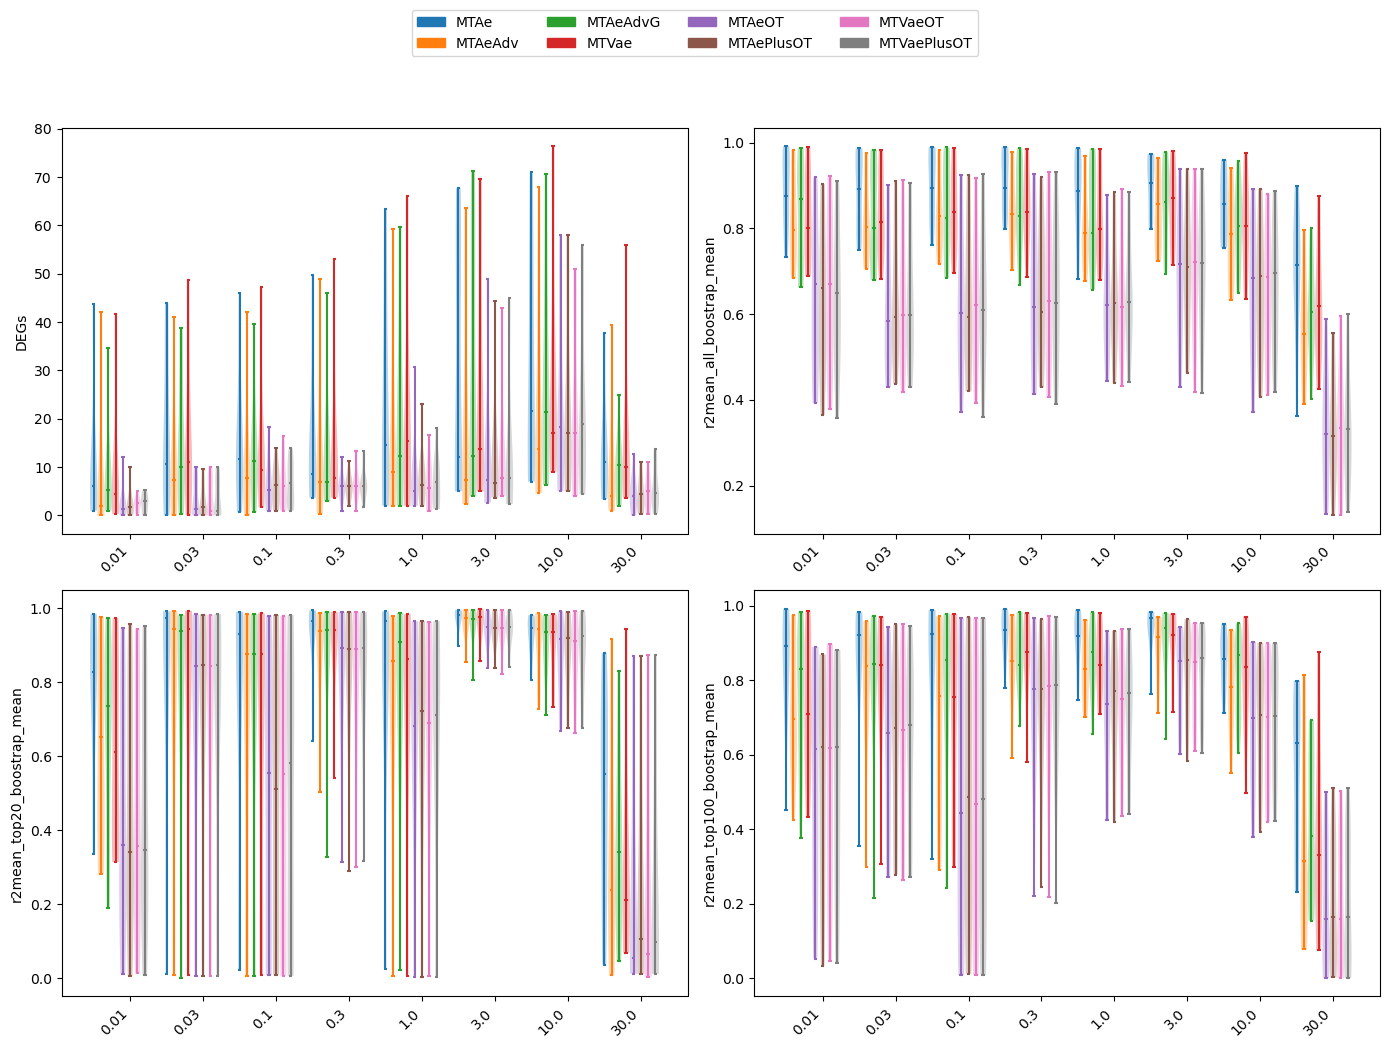

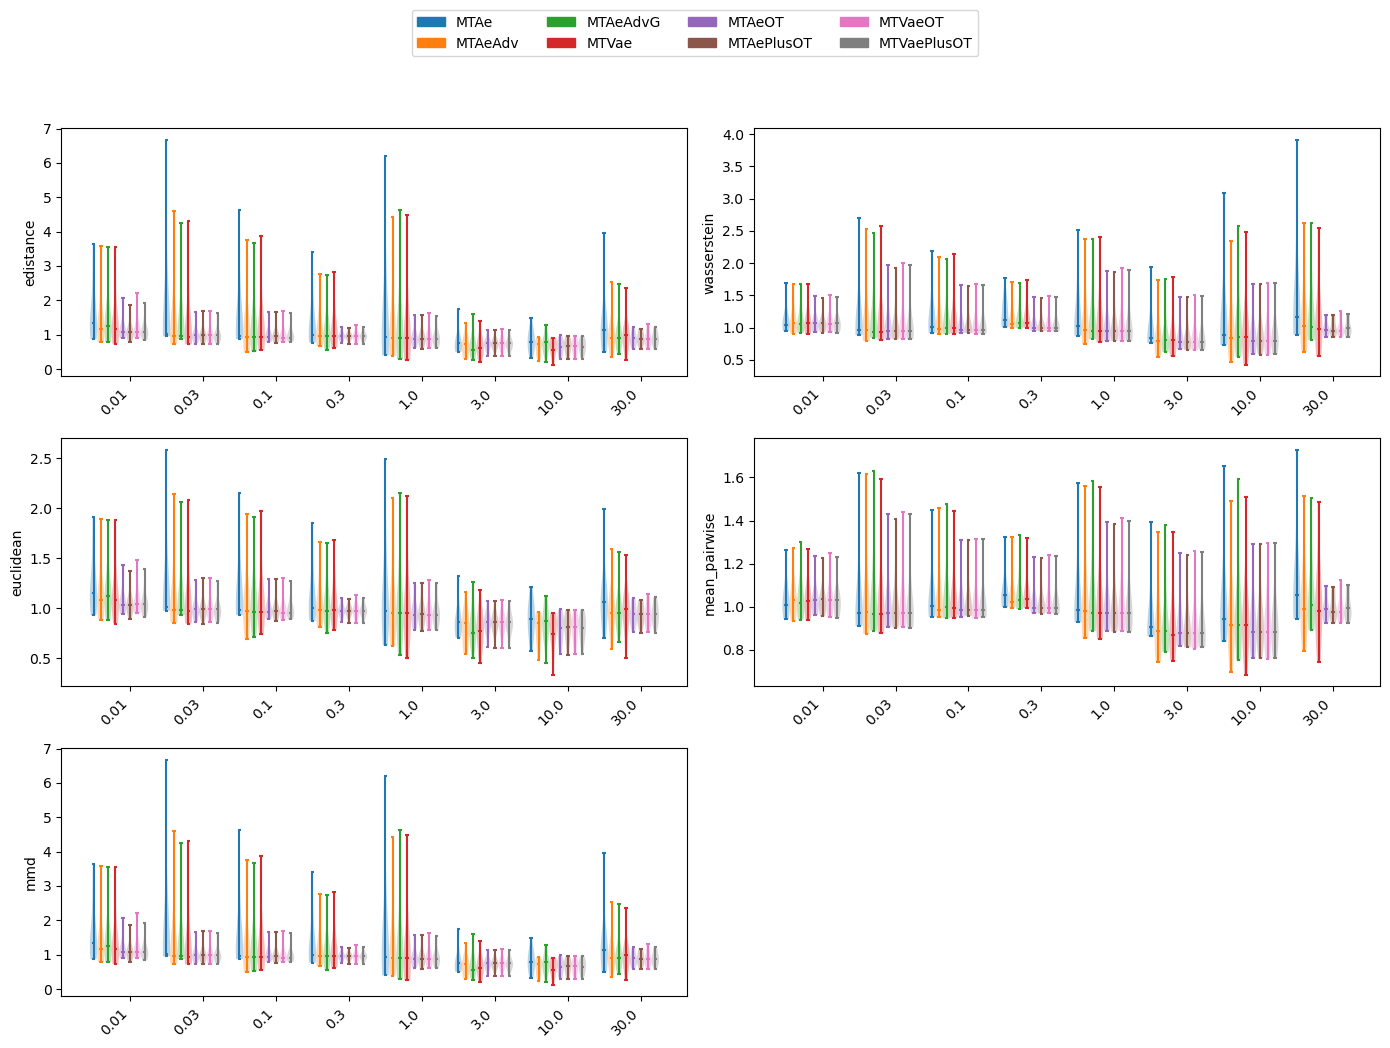

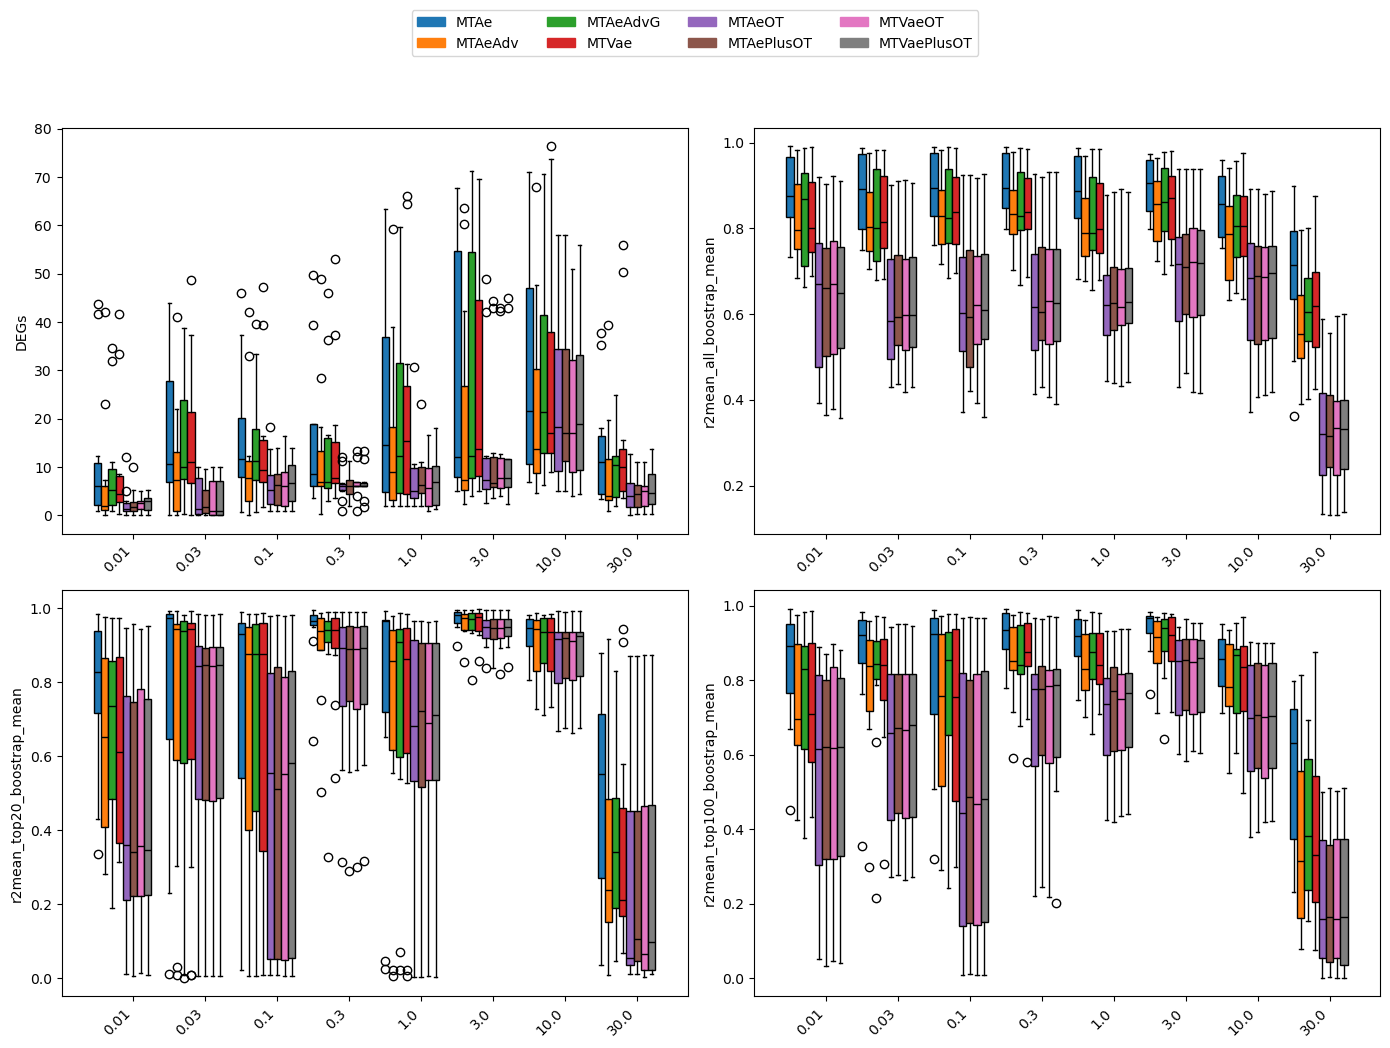

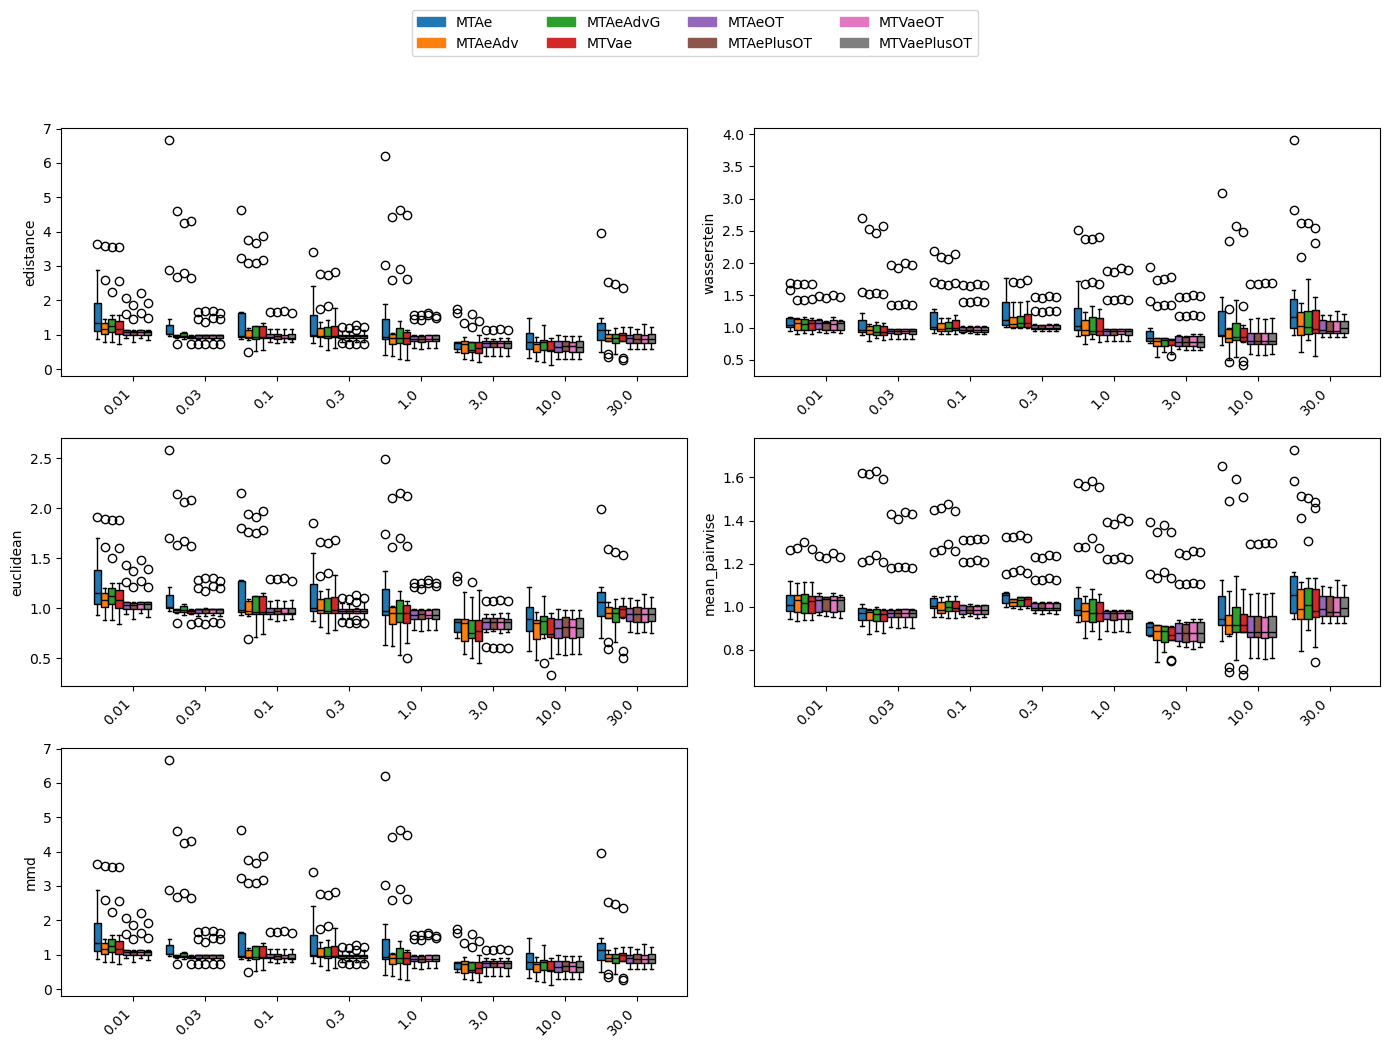

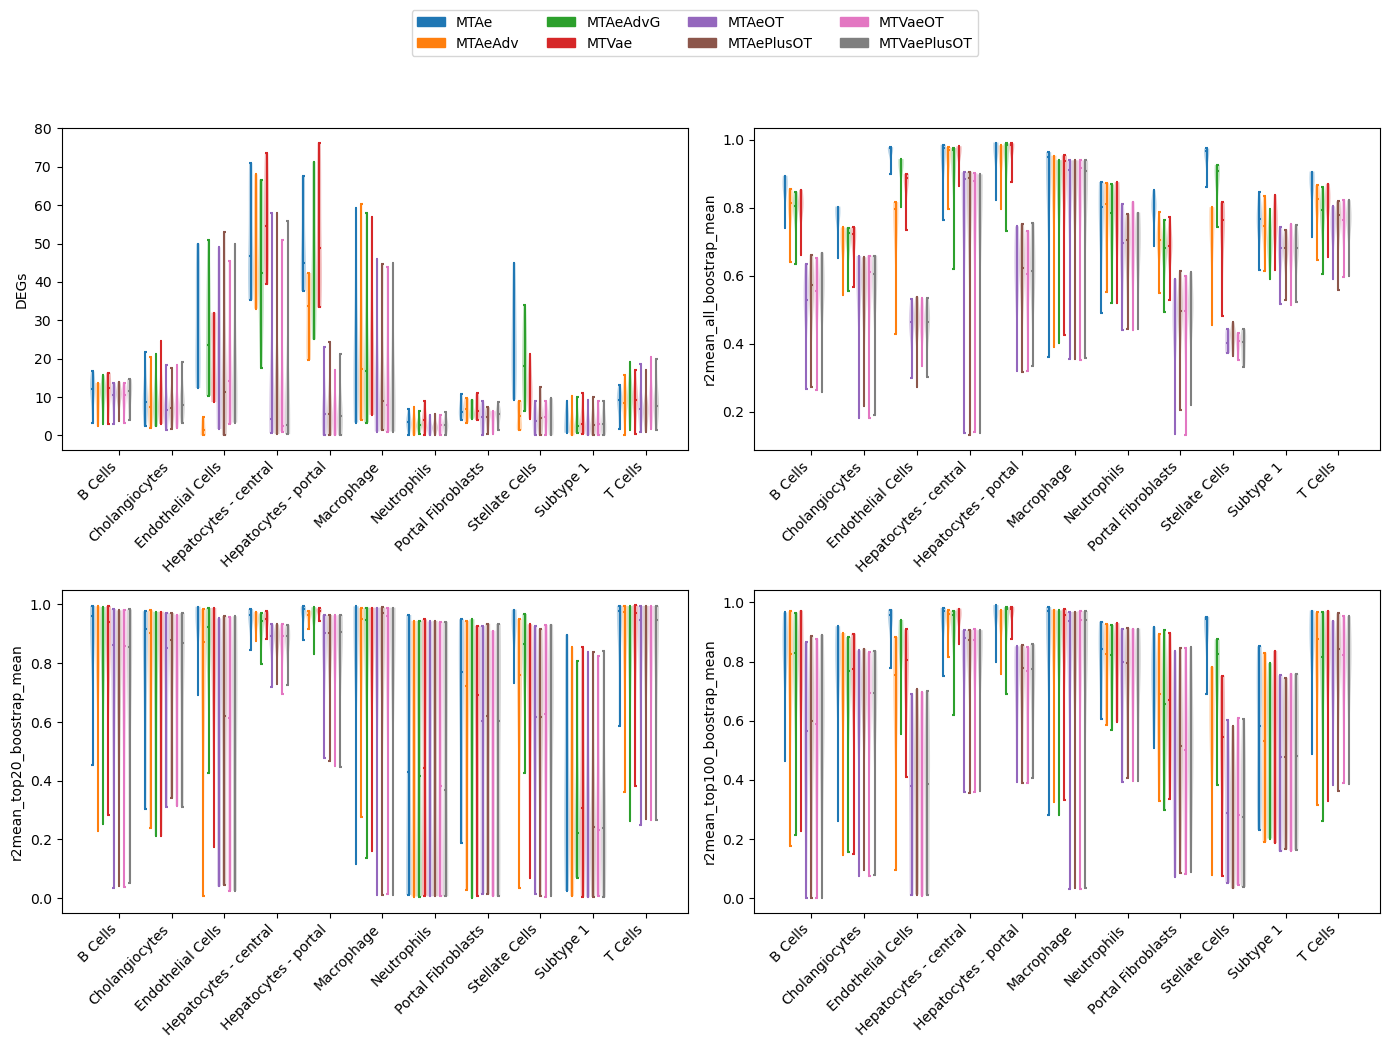

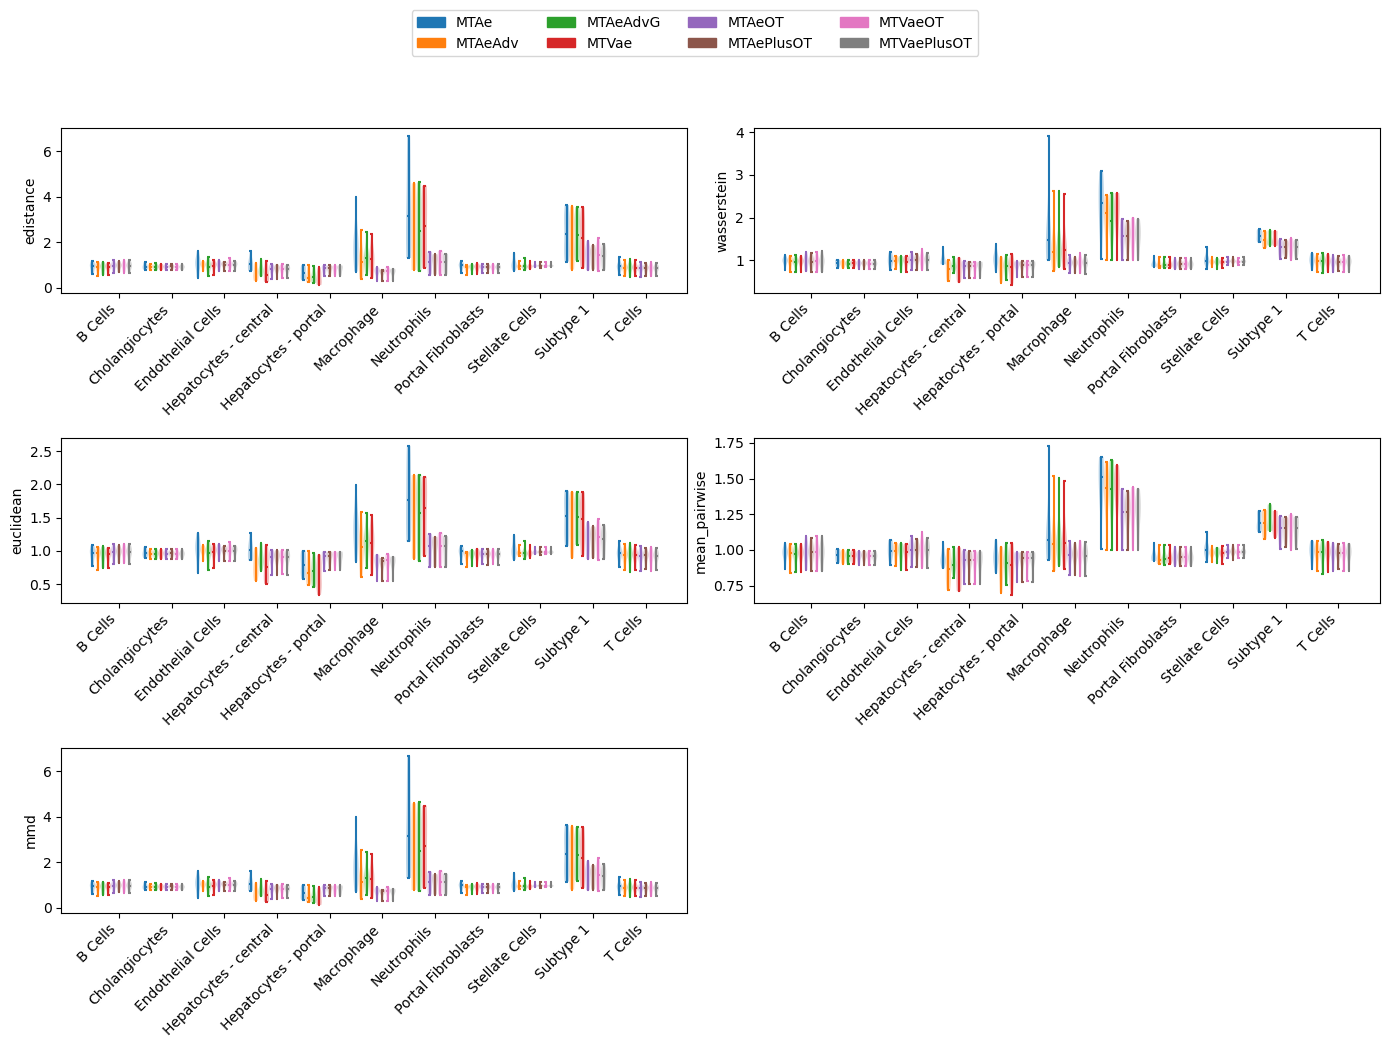

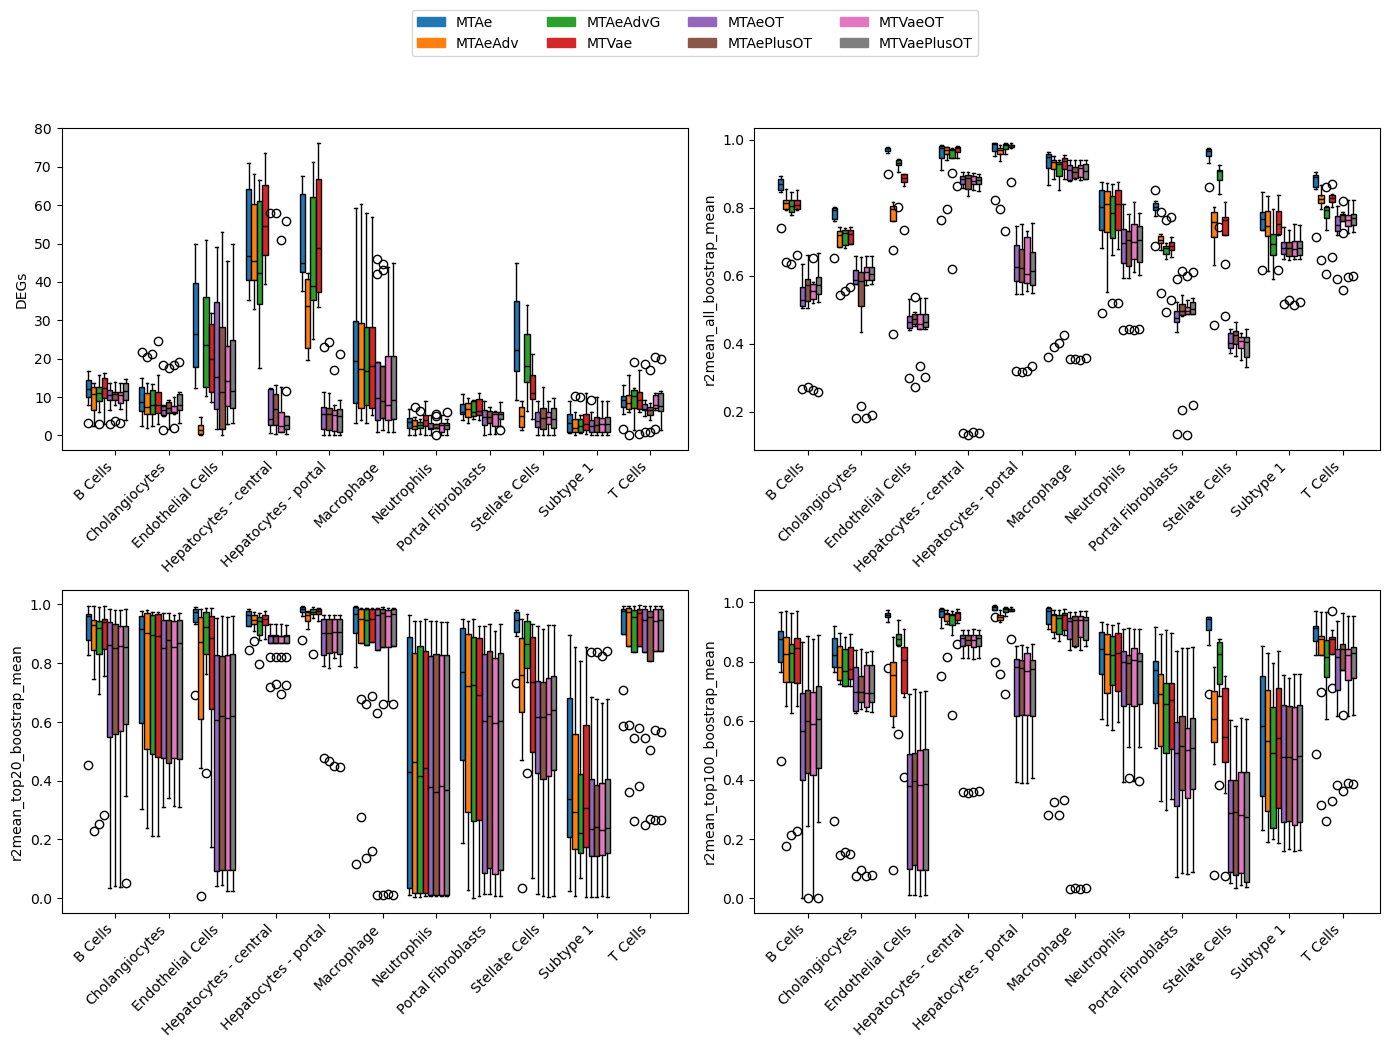

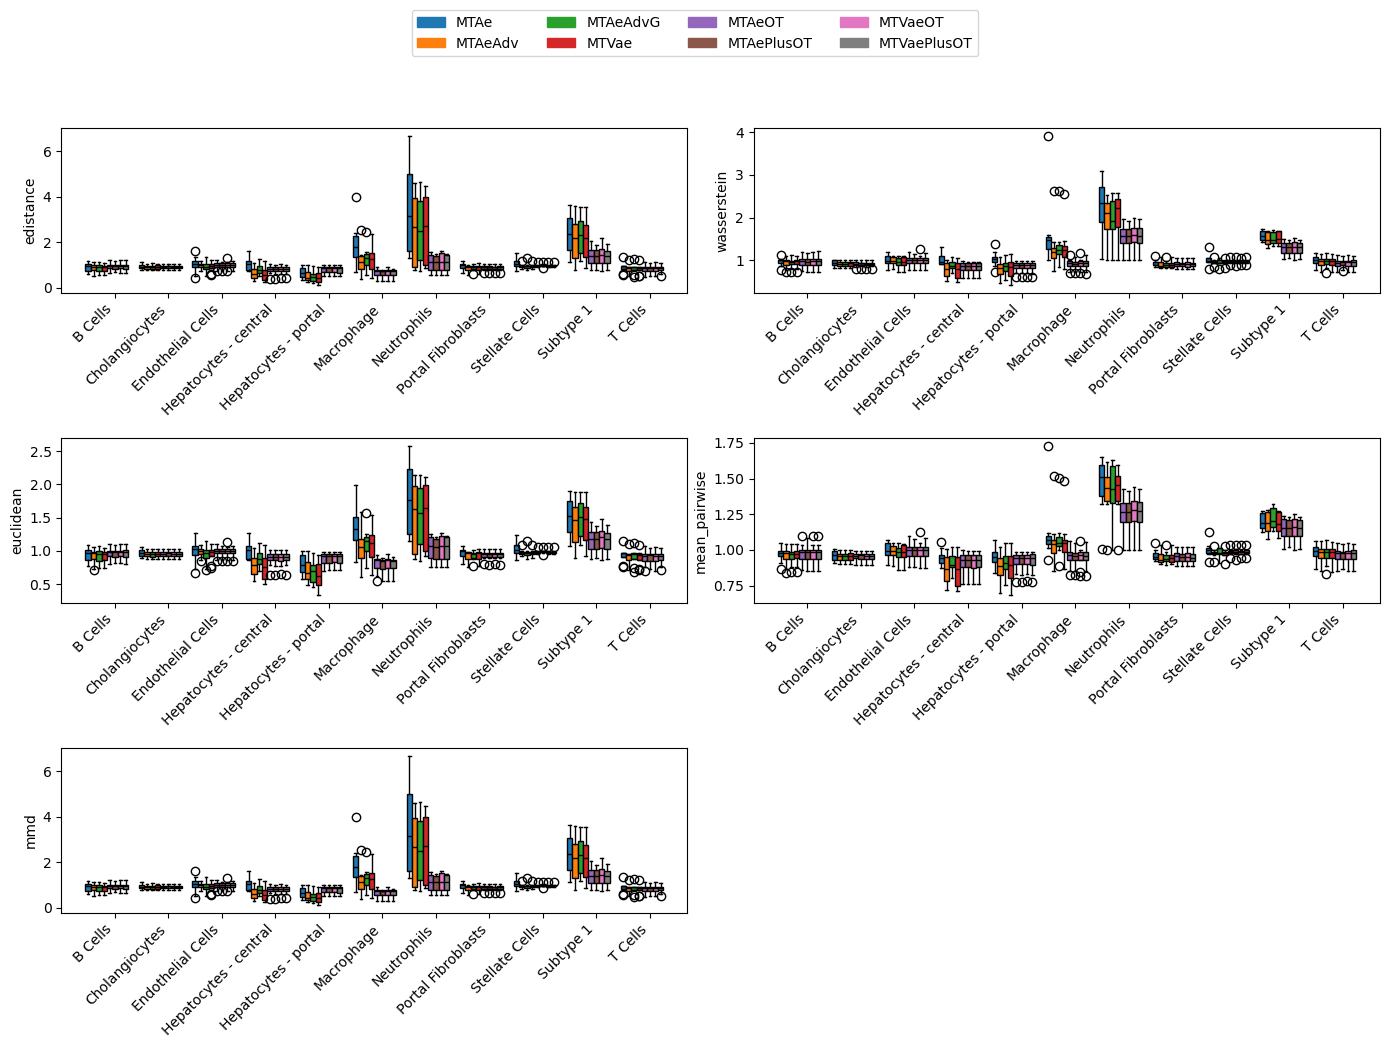

In [72]:
dim_to_reduce = [DimToReduce.X, DimToReduce.Y]
plots = [PlotType.Violin, PlotType.Boxplot]
metrics = [BASELINE_METRICS, DISTANCE_METRICS]

for dim in dim_to_reduce:
    for plot in plots:
        for idx, metric in enumerate(metrics):
            get_plot(
                dataset = mean_dataset_nault,
                x_key="cell_type_test",
                y_key="dose",
                dim_to_reduce=dim,
                plot_type=plot,
                title="",
                metrics=metric,
                models=MODELS_MULTI_TASK
                #file_name_to_save=f'NaultPipeline_{dim.name}_{plot.name}_metrics{idx}'
            )

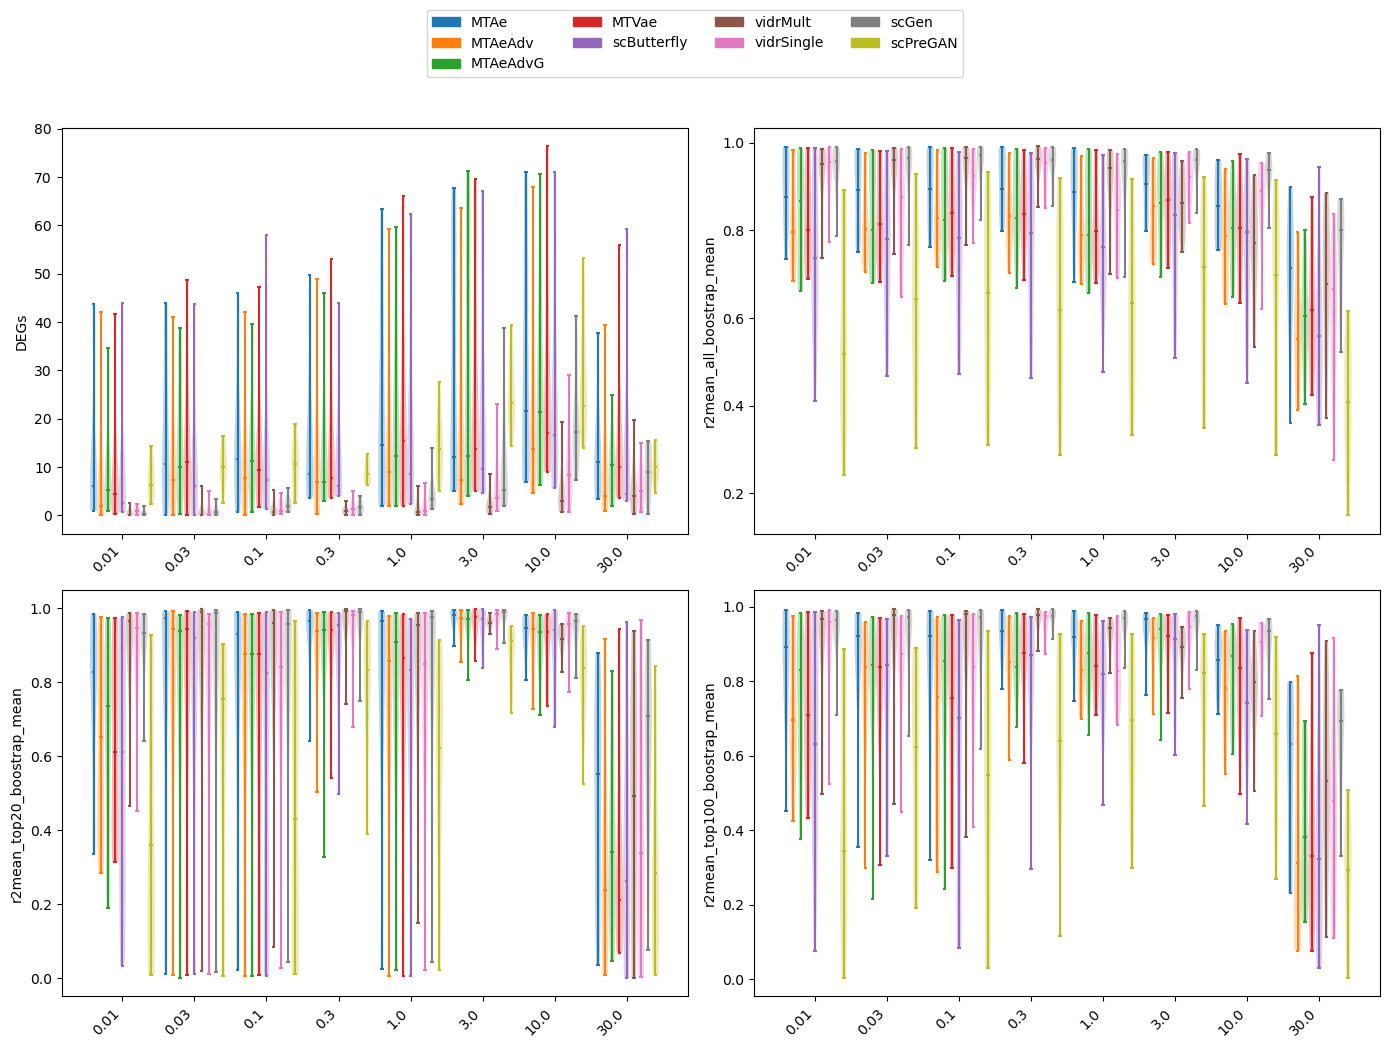

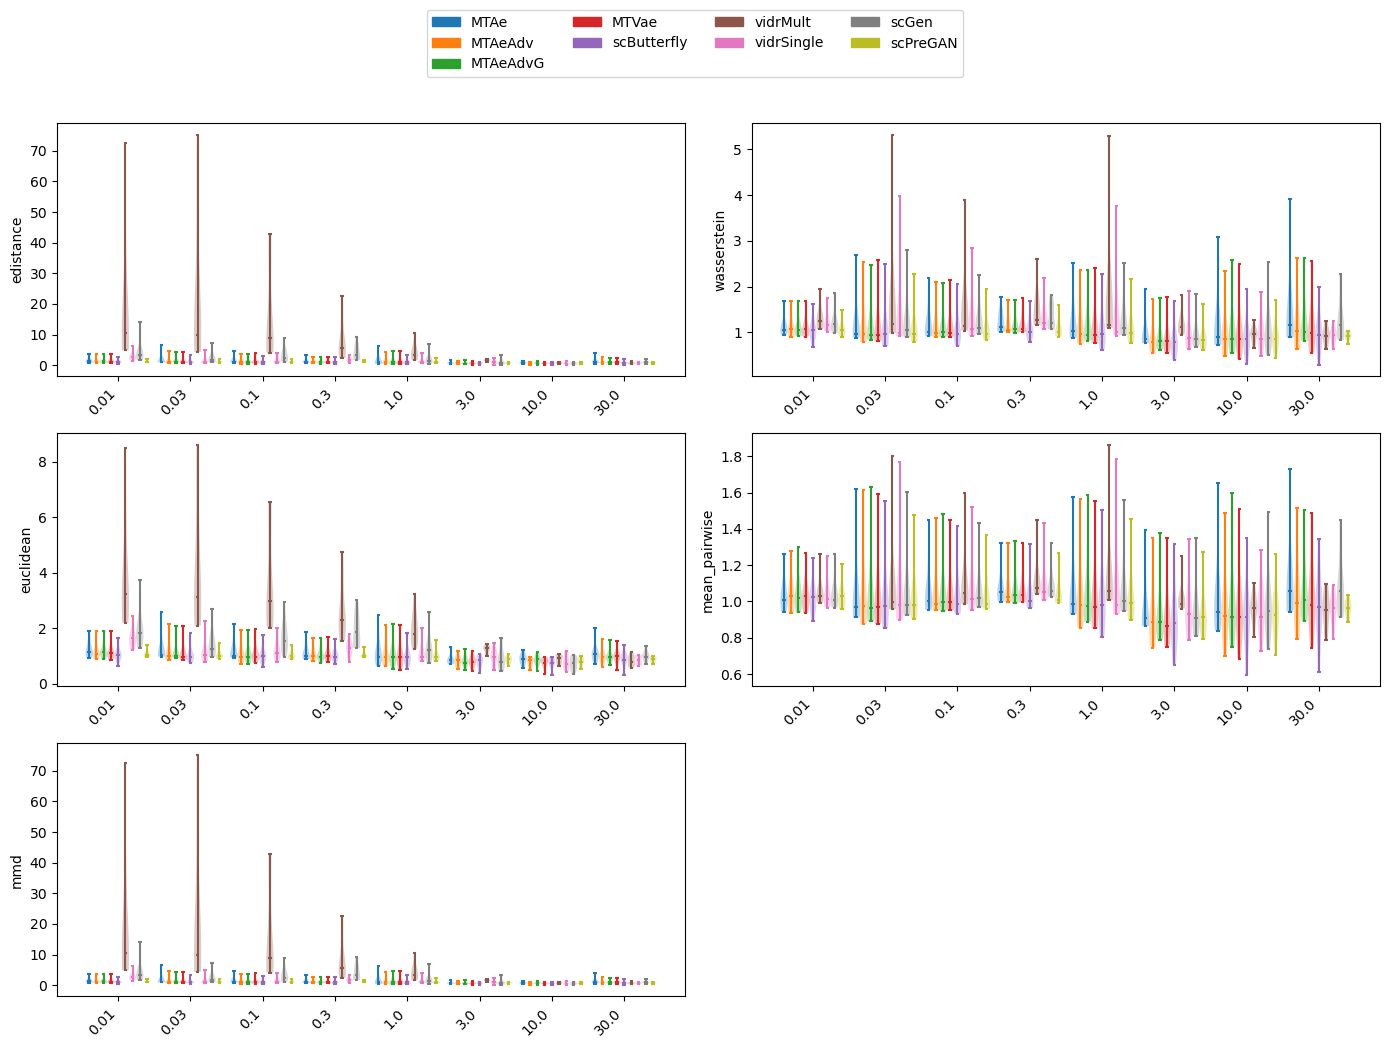

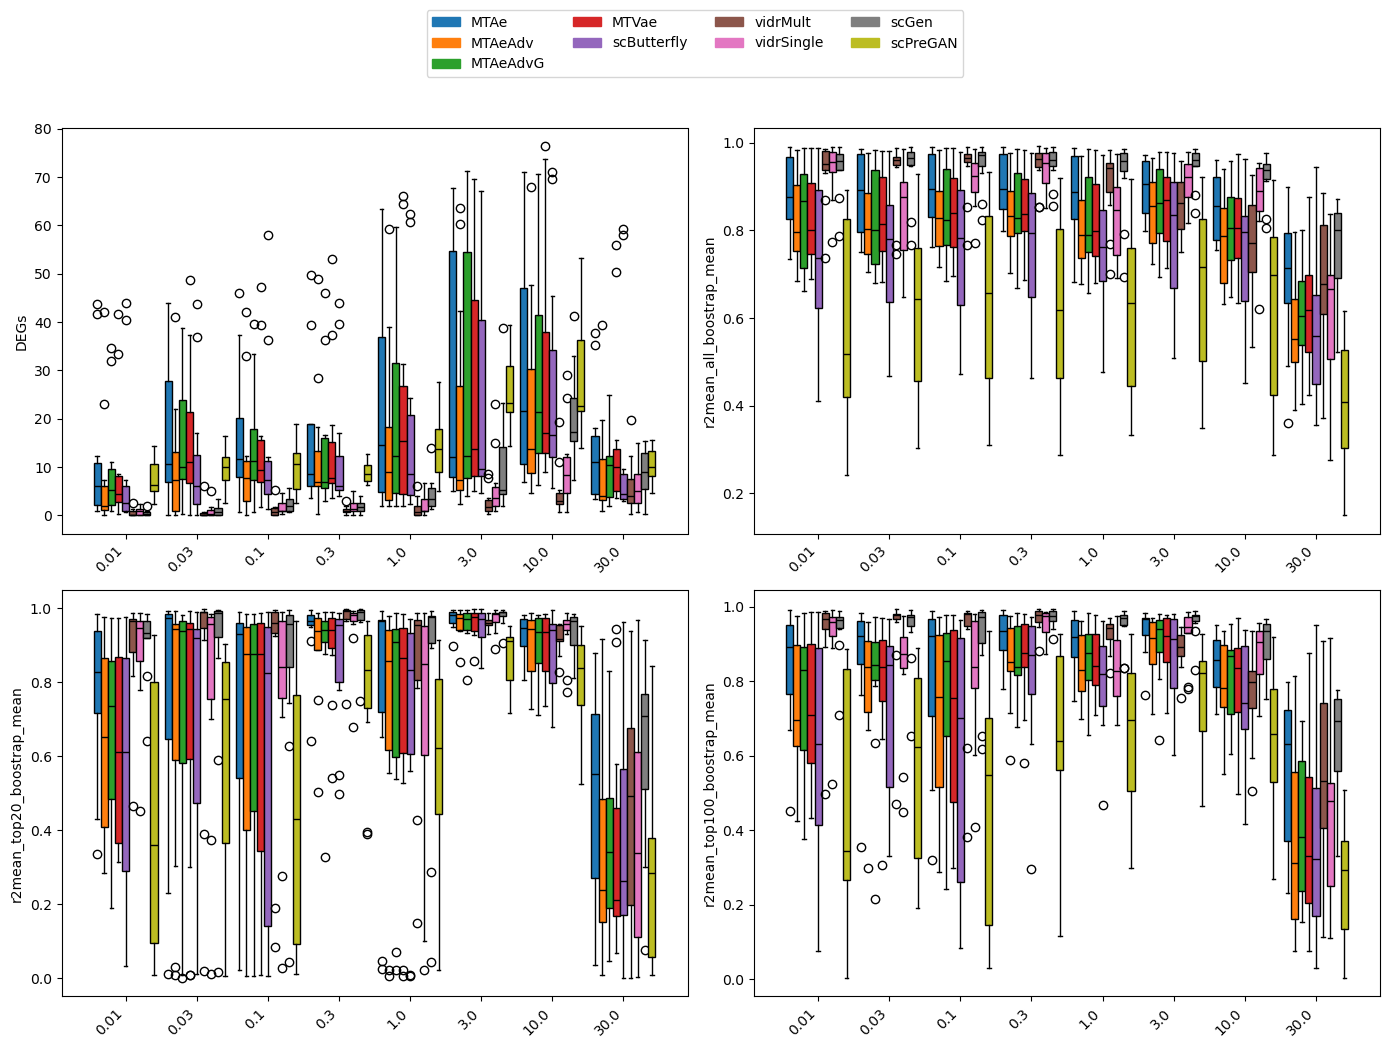

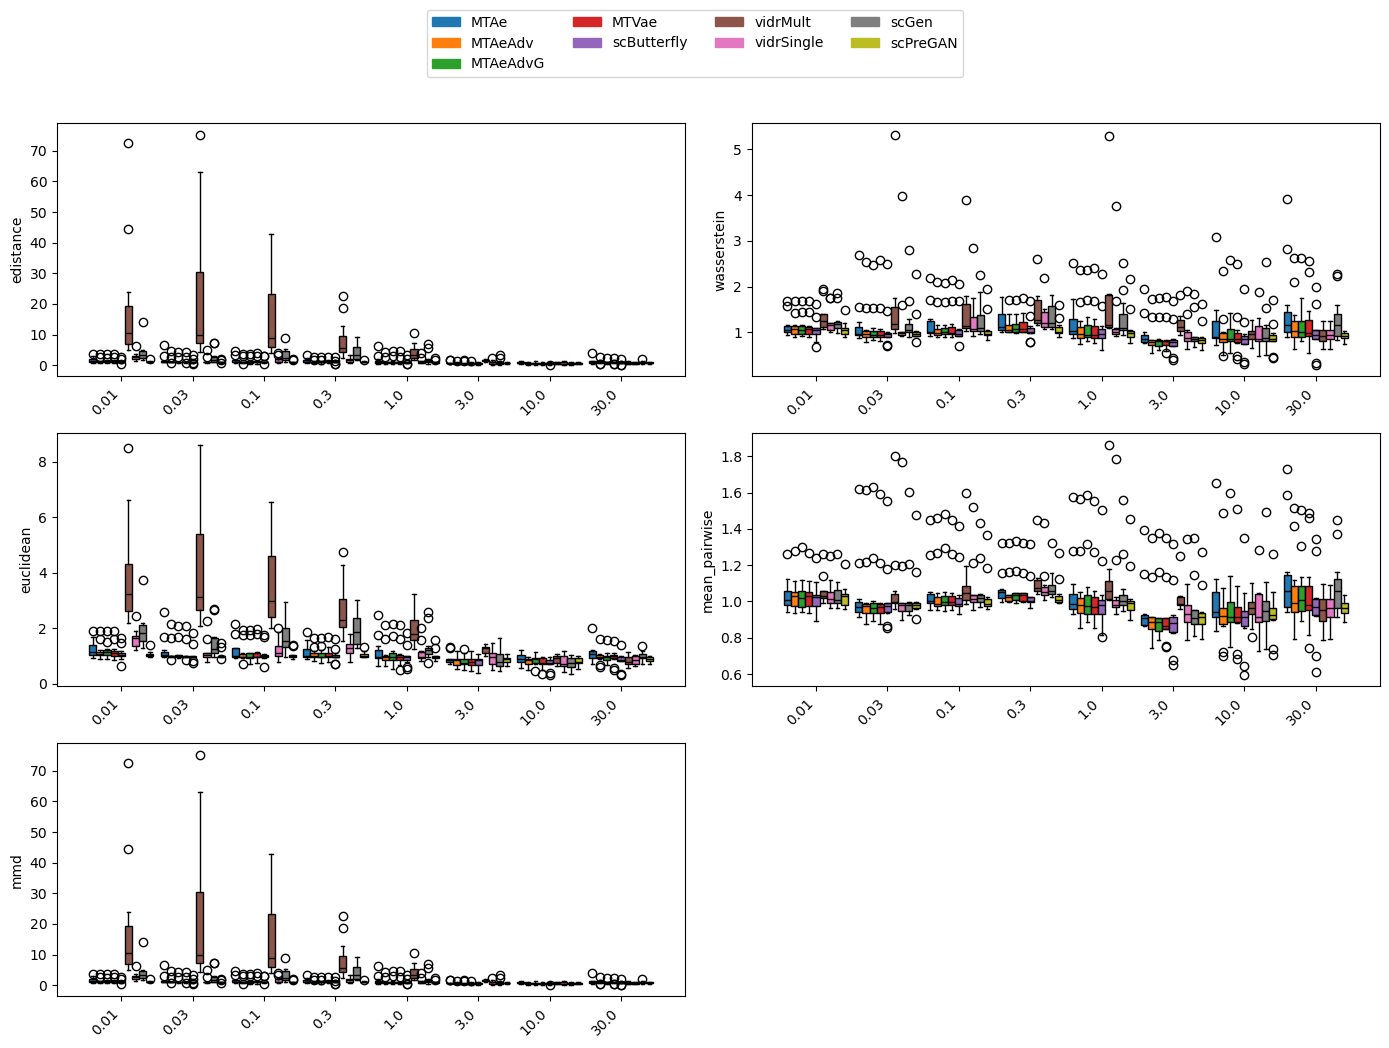

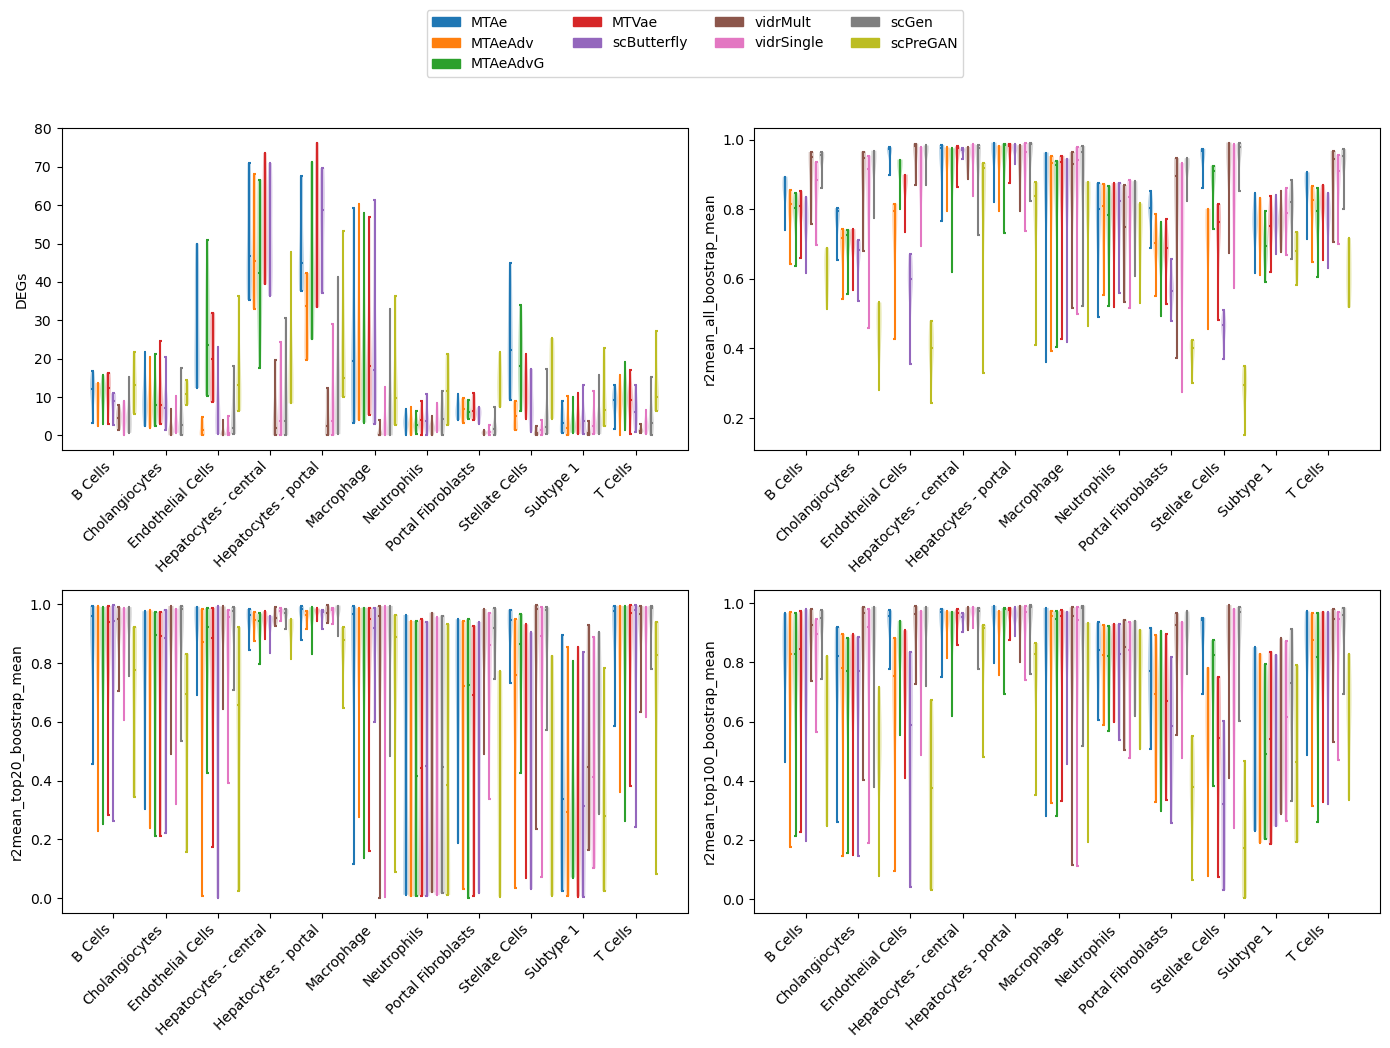

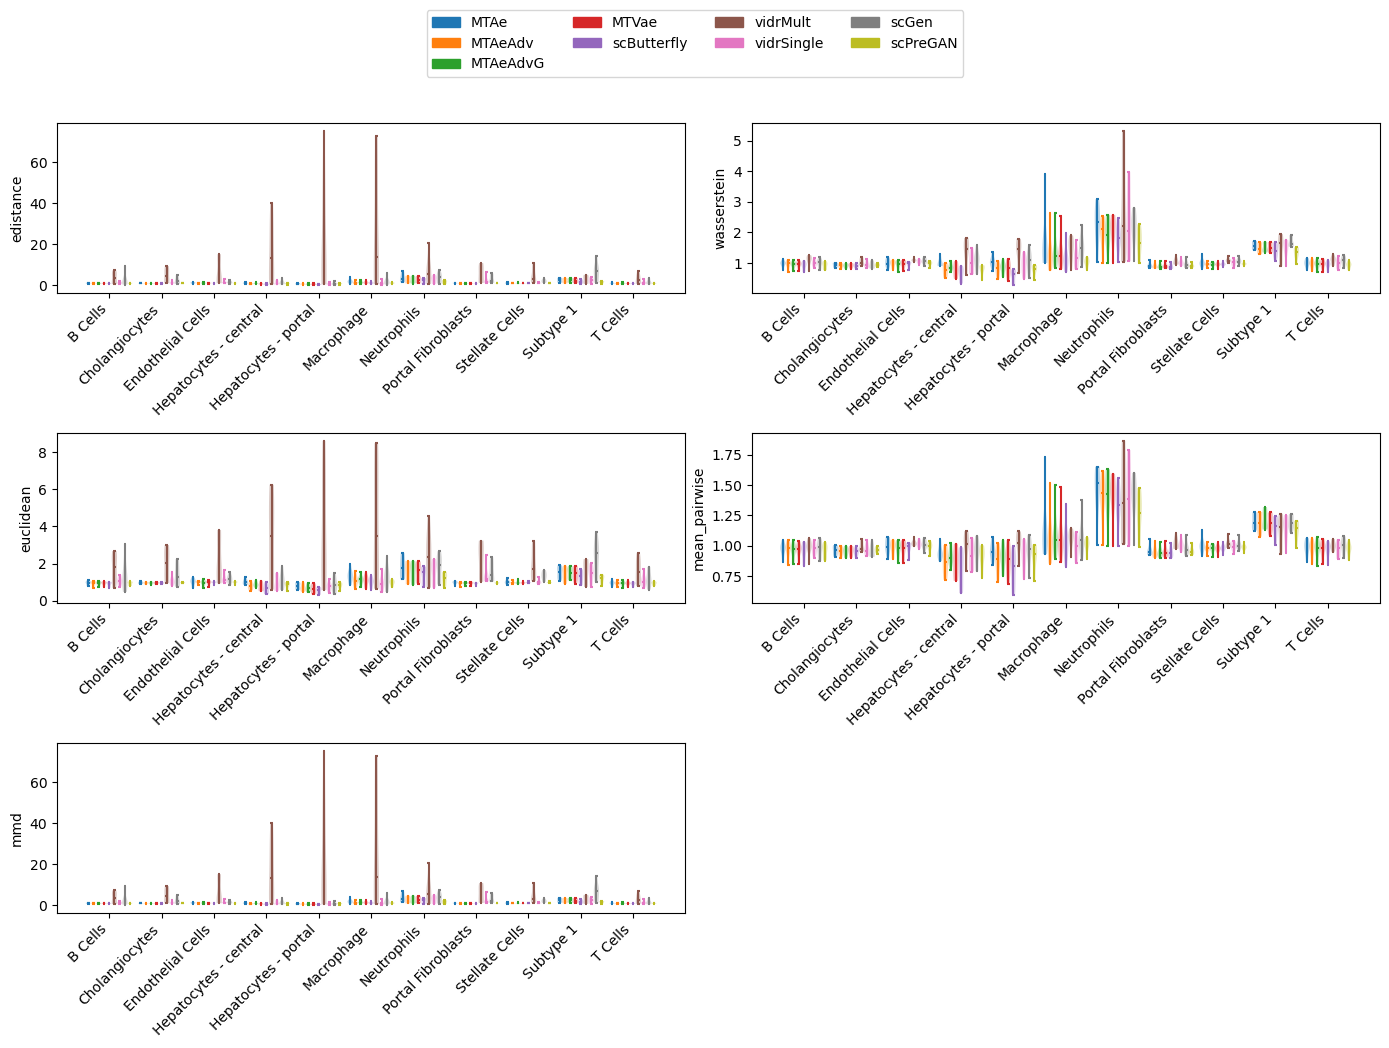

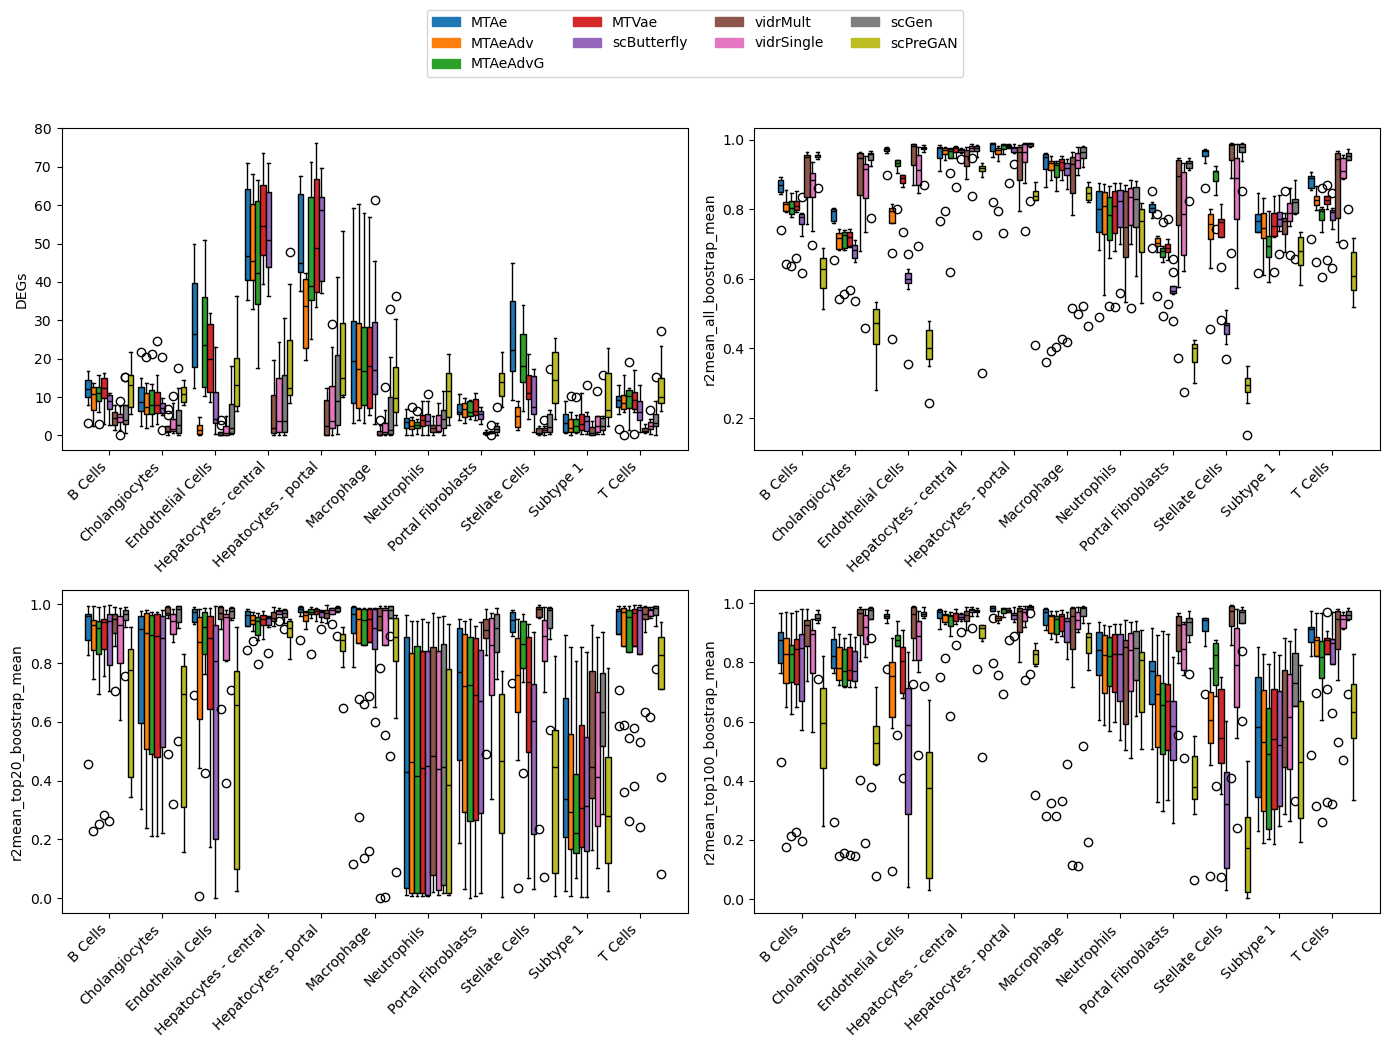

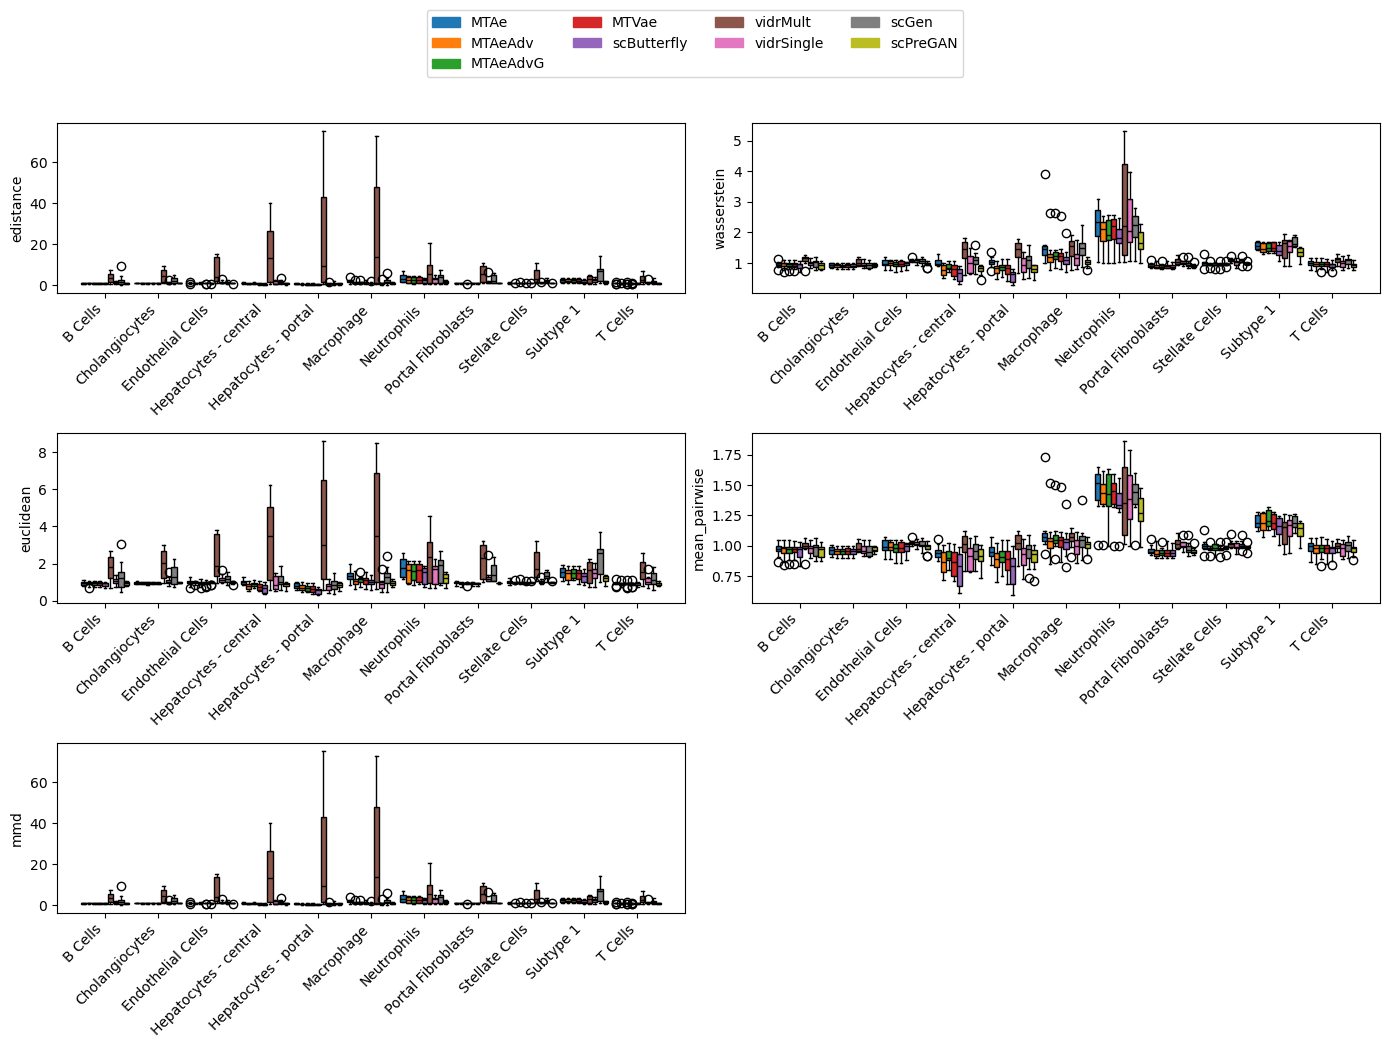

In [73]:
dim_to_reduce = [DimToReduce.X, DimToReduce.Y]
plots = [PlotType.Violin, PlotType.Boxplot]
metrics = [BASELINE_METRICS, DISTANCE_METRICS]

for dim in dim_to_reduce:
    for plot in plots:
        for idx, metric in enumerate(metrics):
            get_plot(
                dataset = mean_dataset_nault,
                x_key="cell_type_test",
                y_key="dose",
                dim_to_reduce=dim,
                plot_type=plot,
                title="",
                metrics=metric,
                models=selected_models + LITERATURE_MODELS
                #file_name_to_save=f'NaultPipeline_{dim.name}_{plot.name}_metrics{idx}'
            )

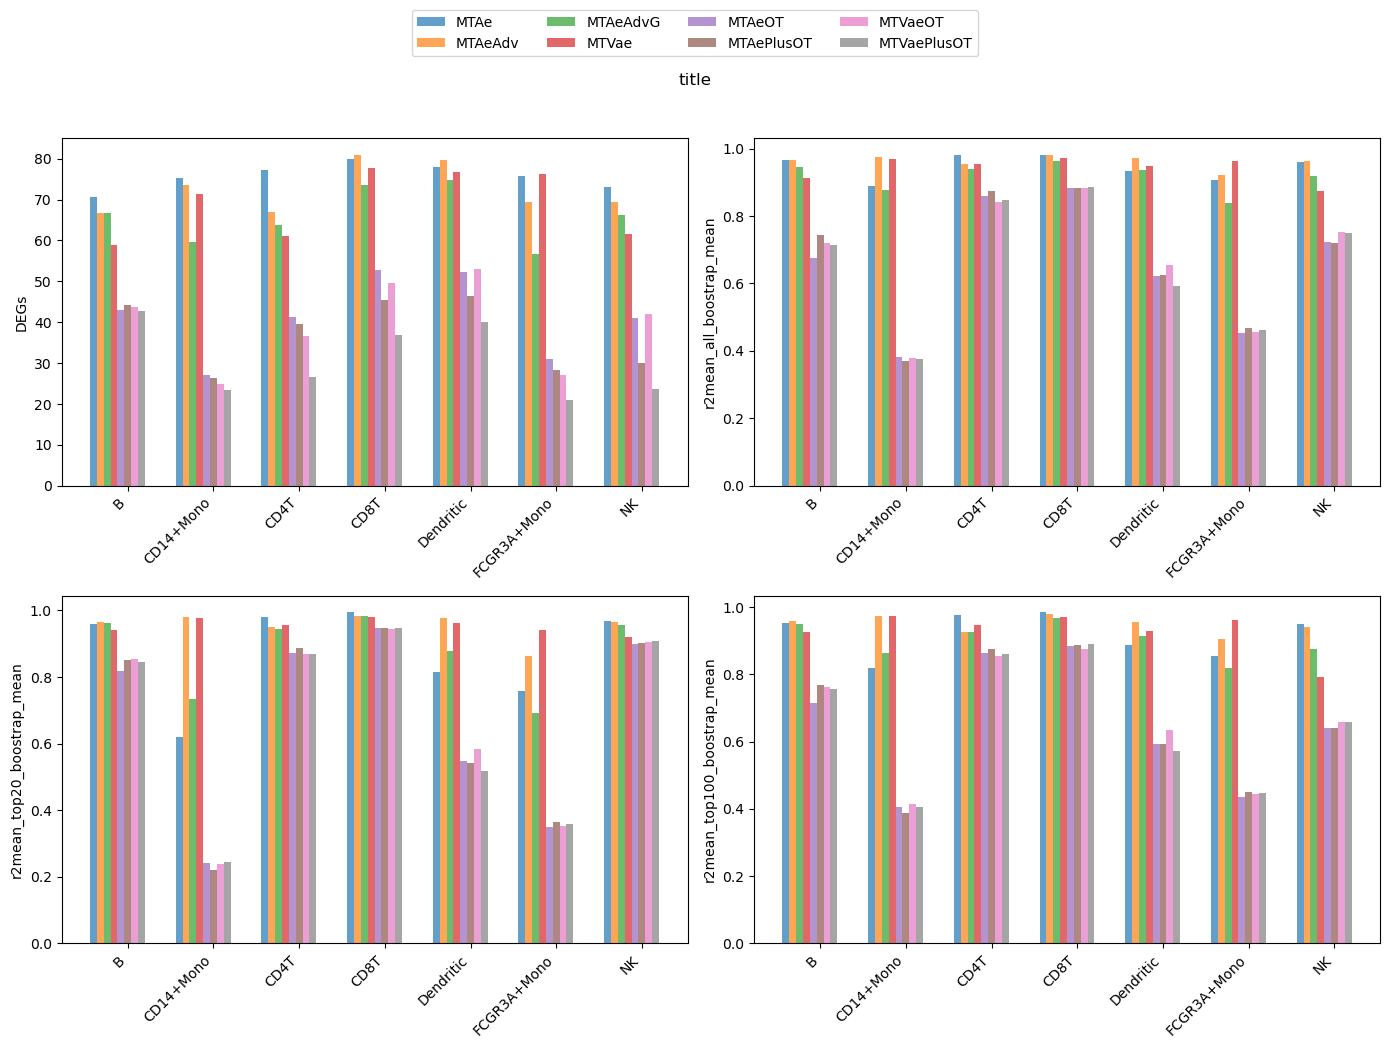

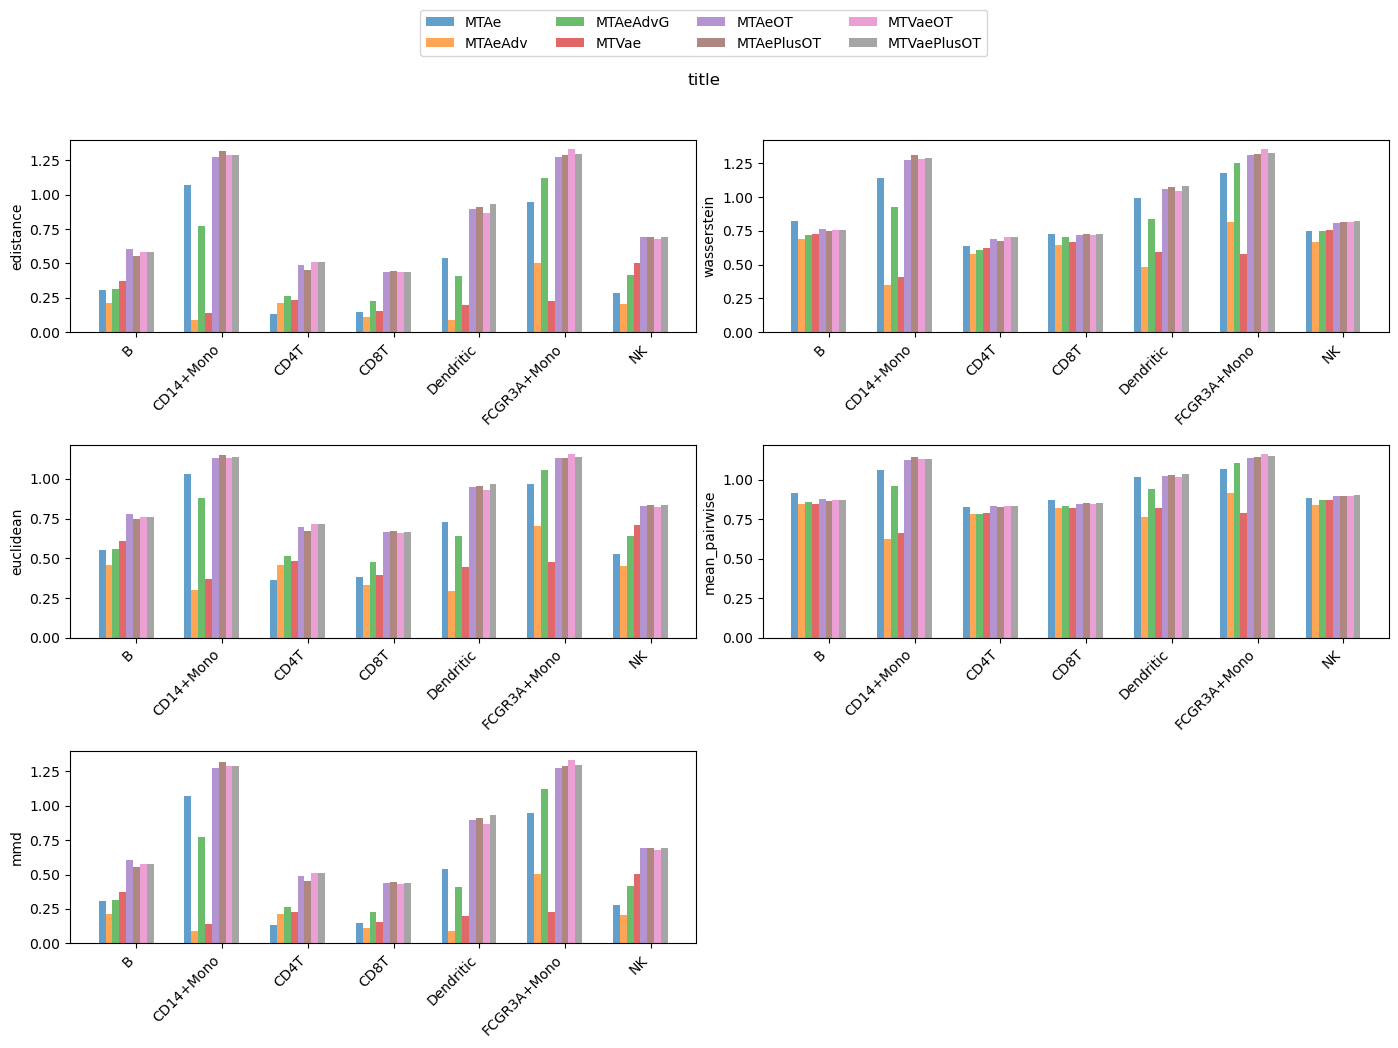

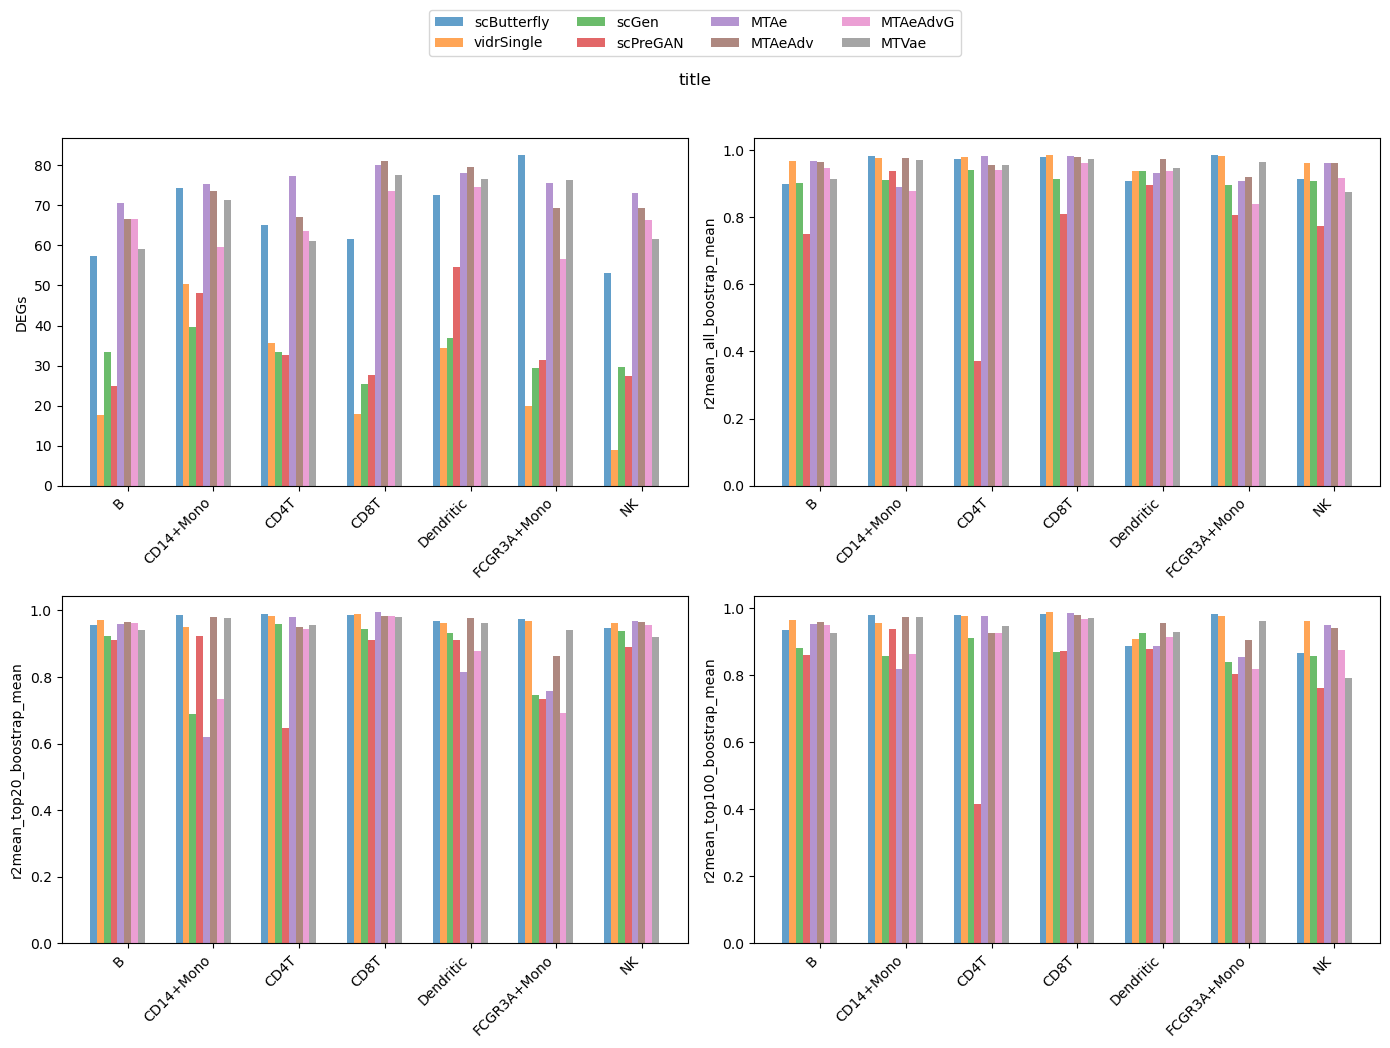

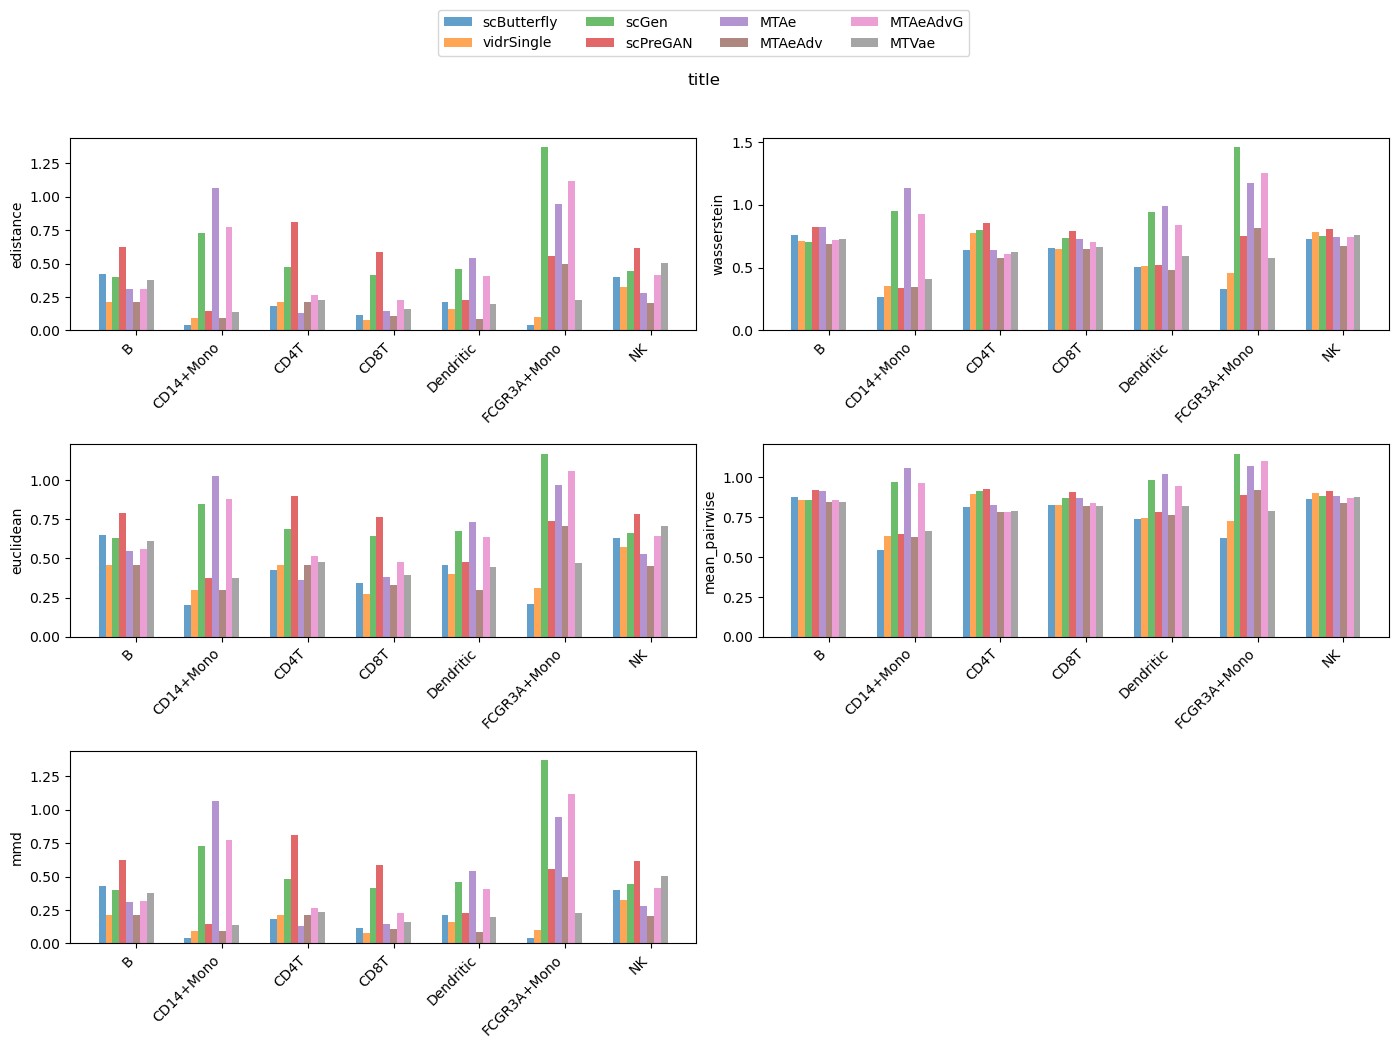

In [74]:
# averaging across seeds
datasets =  []
for seed in [1, 2, 19193]:
    datasets.append(get_dataset_literature_and_multi_task_per_seed_pbmc(seed))
    
dataset = pd.concat(datasets)
mean_dataset_pbmc = get_dataset_averaging_across_seeds(dataset)
plot_2d_metrics_per_cell_type(dataset=mean_dataset_pbmc, title="title", models=MODELS_MULTI_TASK, metrics=BASELINE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset_pbmc, title="title", models=MODELS_MULTI_TASK, metrics=DISTANCE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset_pbmc, title="title", models=LITERATURE_SINGLE_MODELS + selected_models, metrics=BASELINE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset_pbmc, title="title", models=LITERATURE_SINGLE_MODELS + selected_models, metrics=DISTANCE_METRICS)

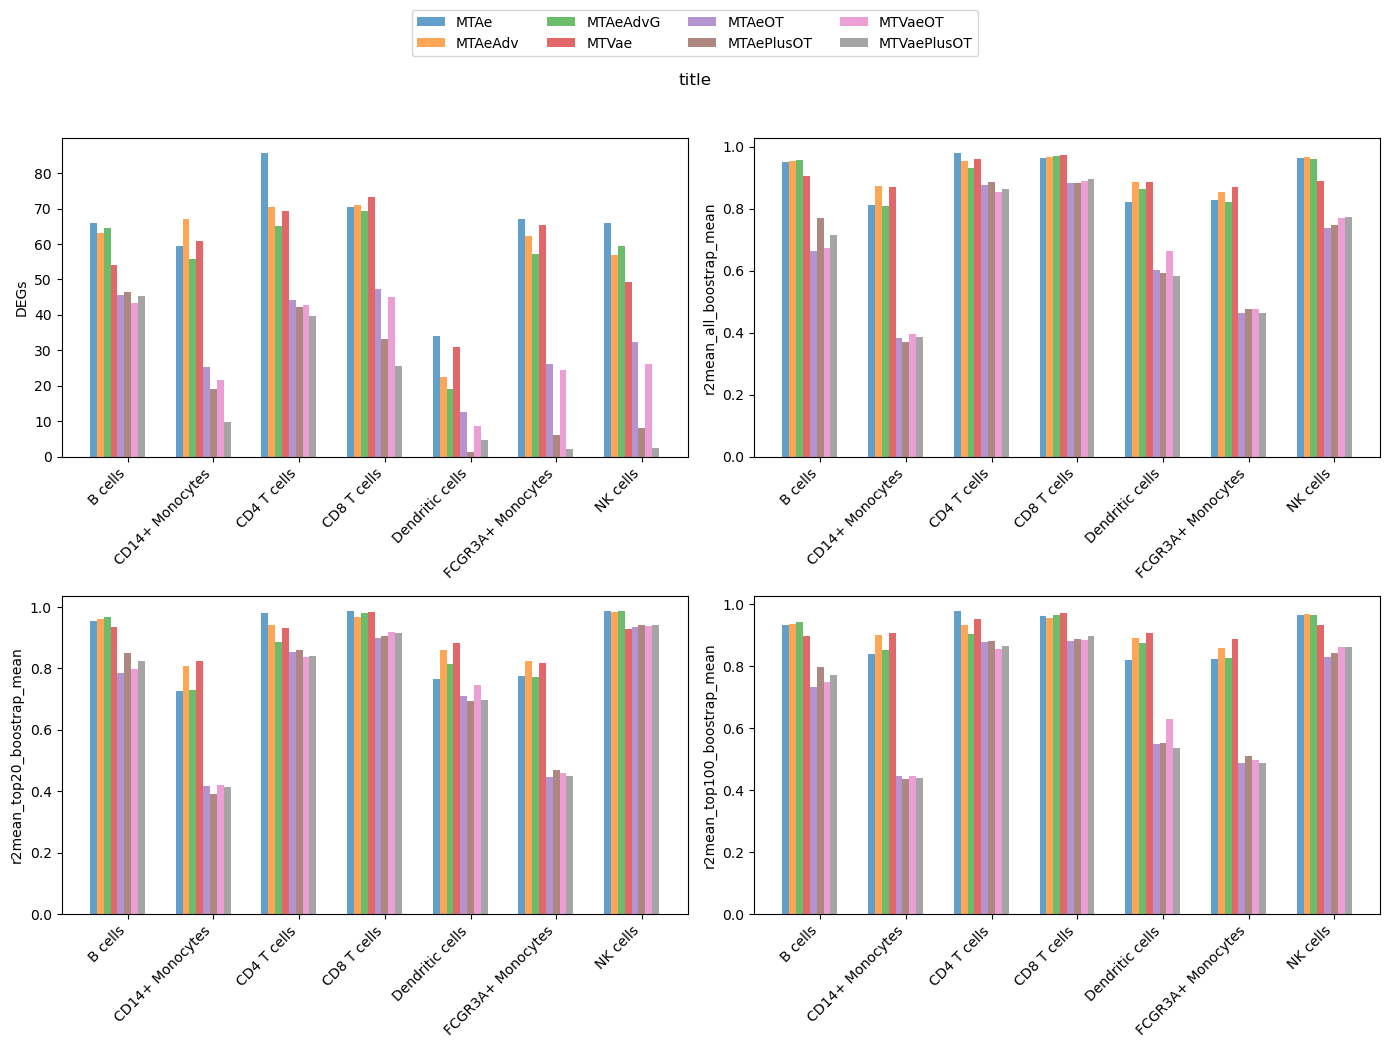

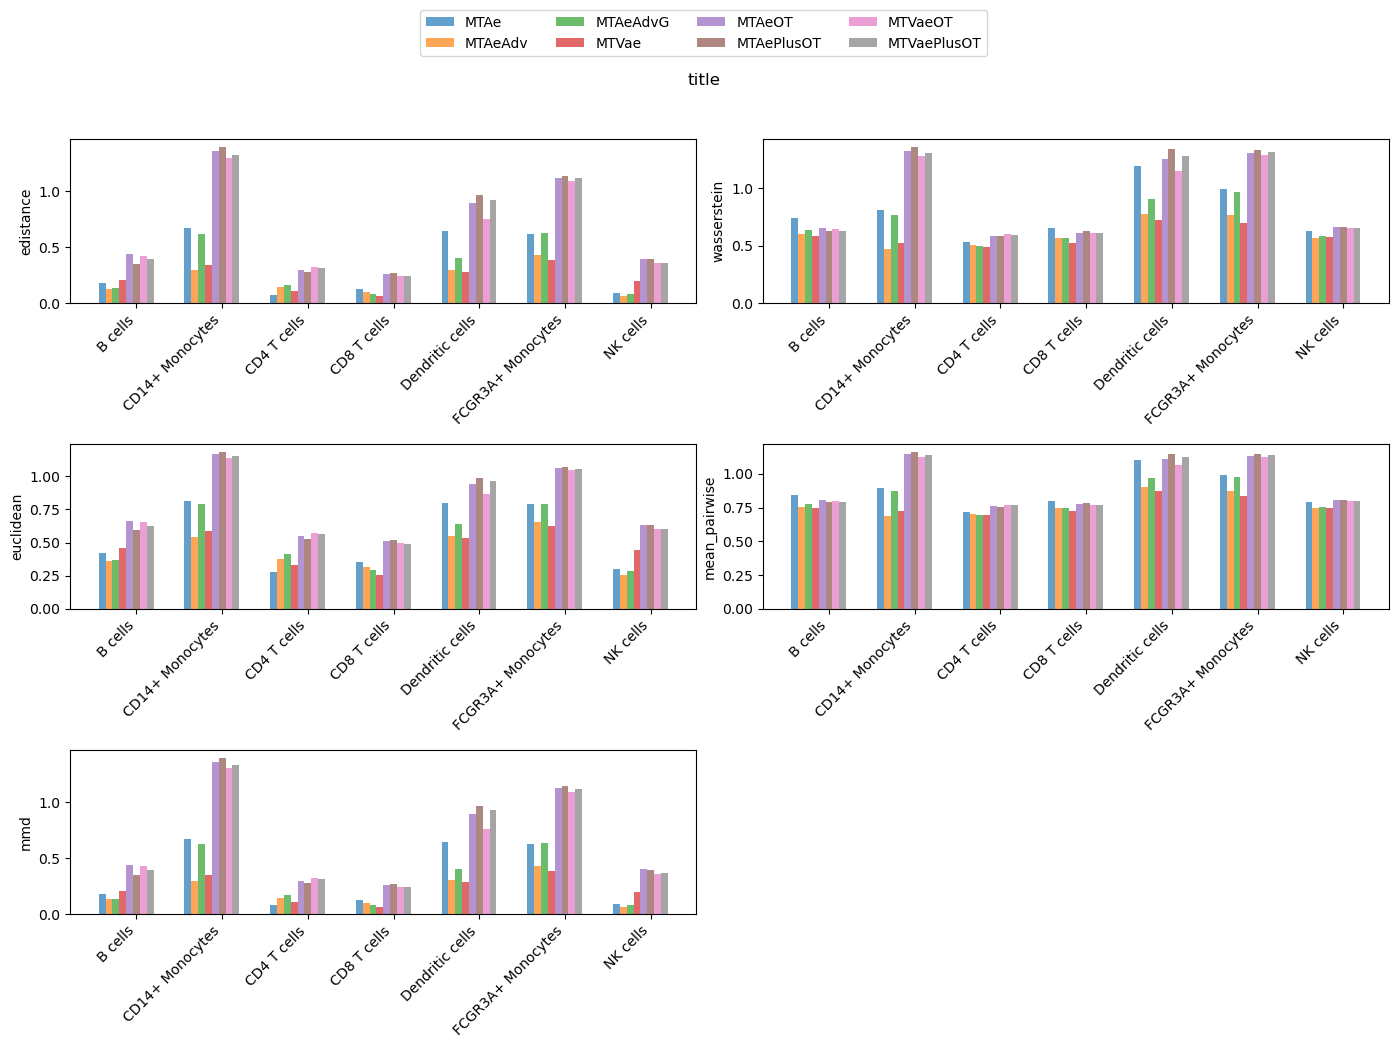

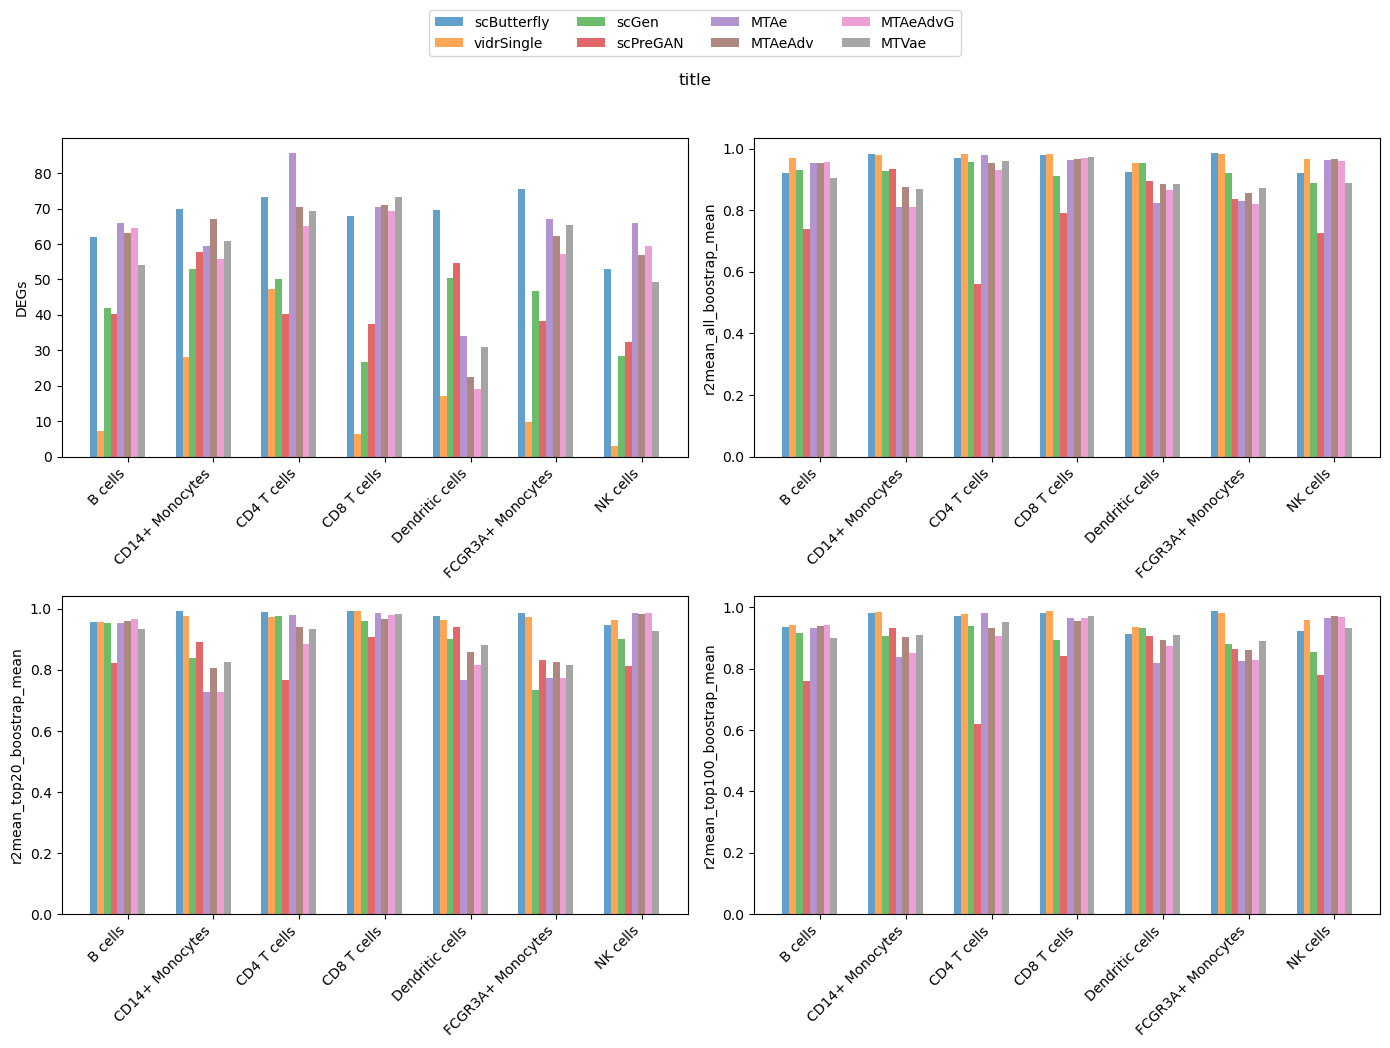

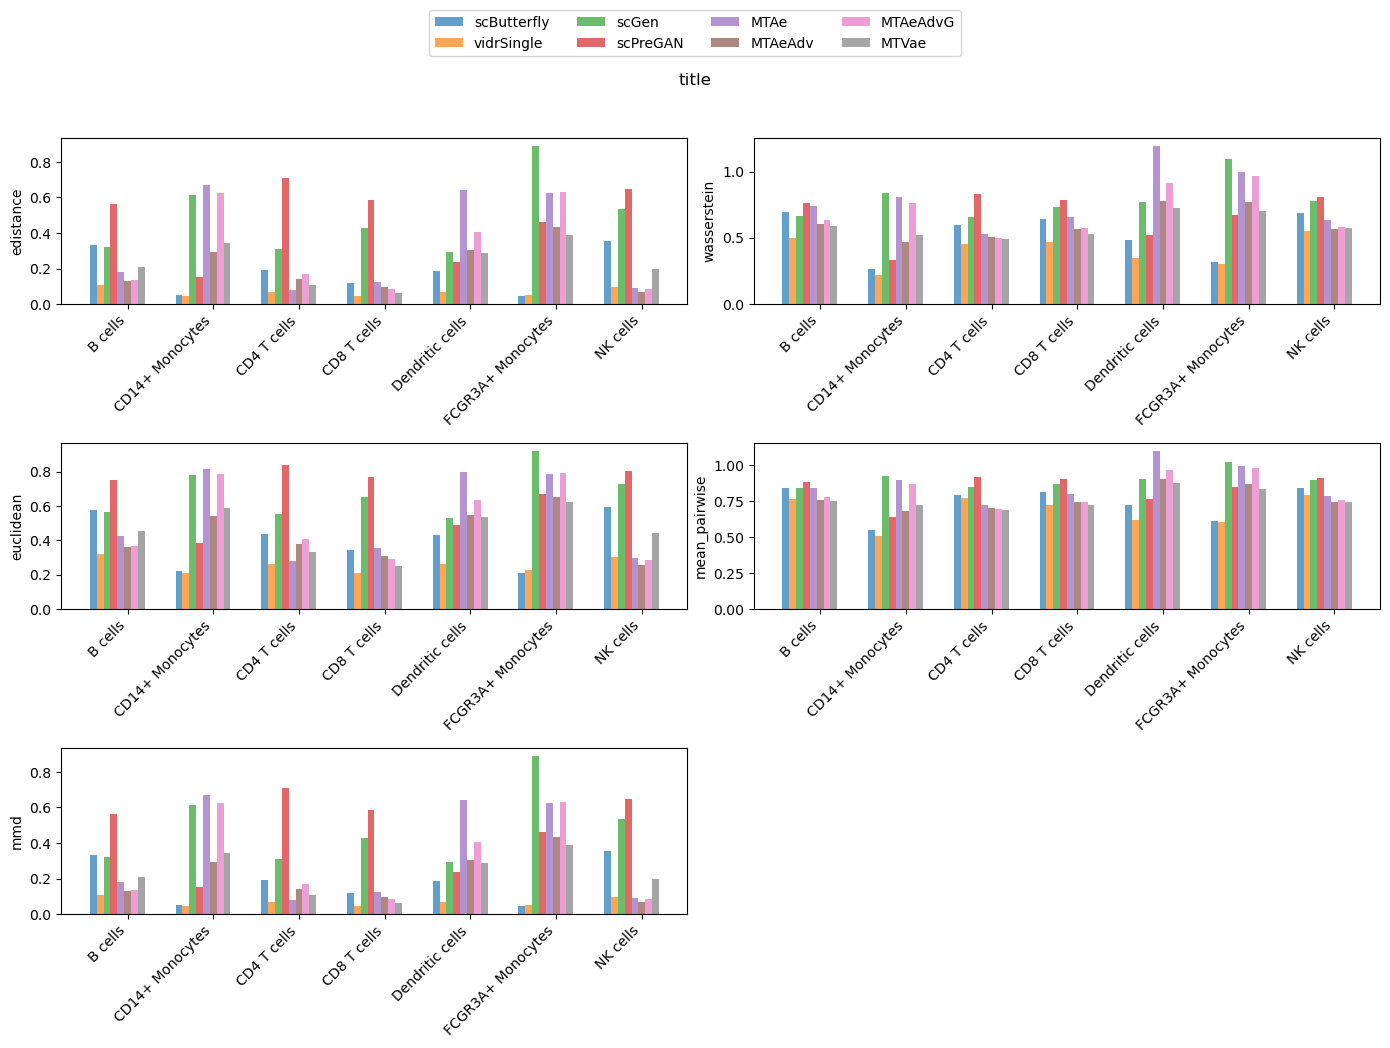

In [75]:
datasets =  []
for seed in [1, 2, 19193]:
    datasets.append(get_dataset_literature_and_multi_task_per_seed_cross_study(seed))
    
dataset = pd.concat(datasets)
mean_dataset = get_dataset_averaging_across_seeds(dataset)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=MODELS_MULTI_TASK, metrics=BASELINE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=MODELS_MULTI_TASK, metrics=DISTANCE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=LITERATURE_SINGLE_MODELS + selected_models, metrics=BASELINE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=LITERATURE_SINGLE_MODELS + selected_models, metrics=DISTANCE_METRICS)

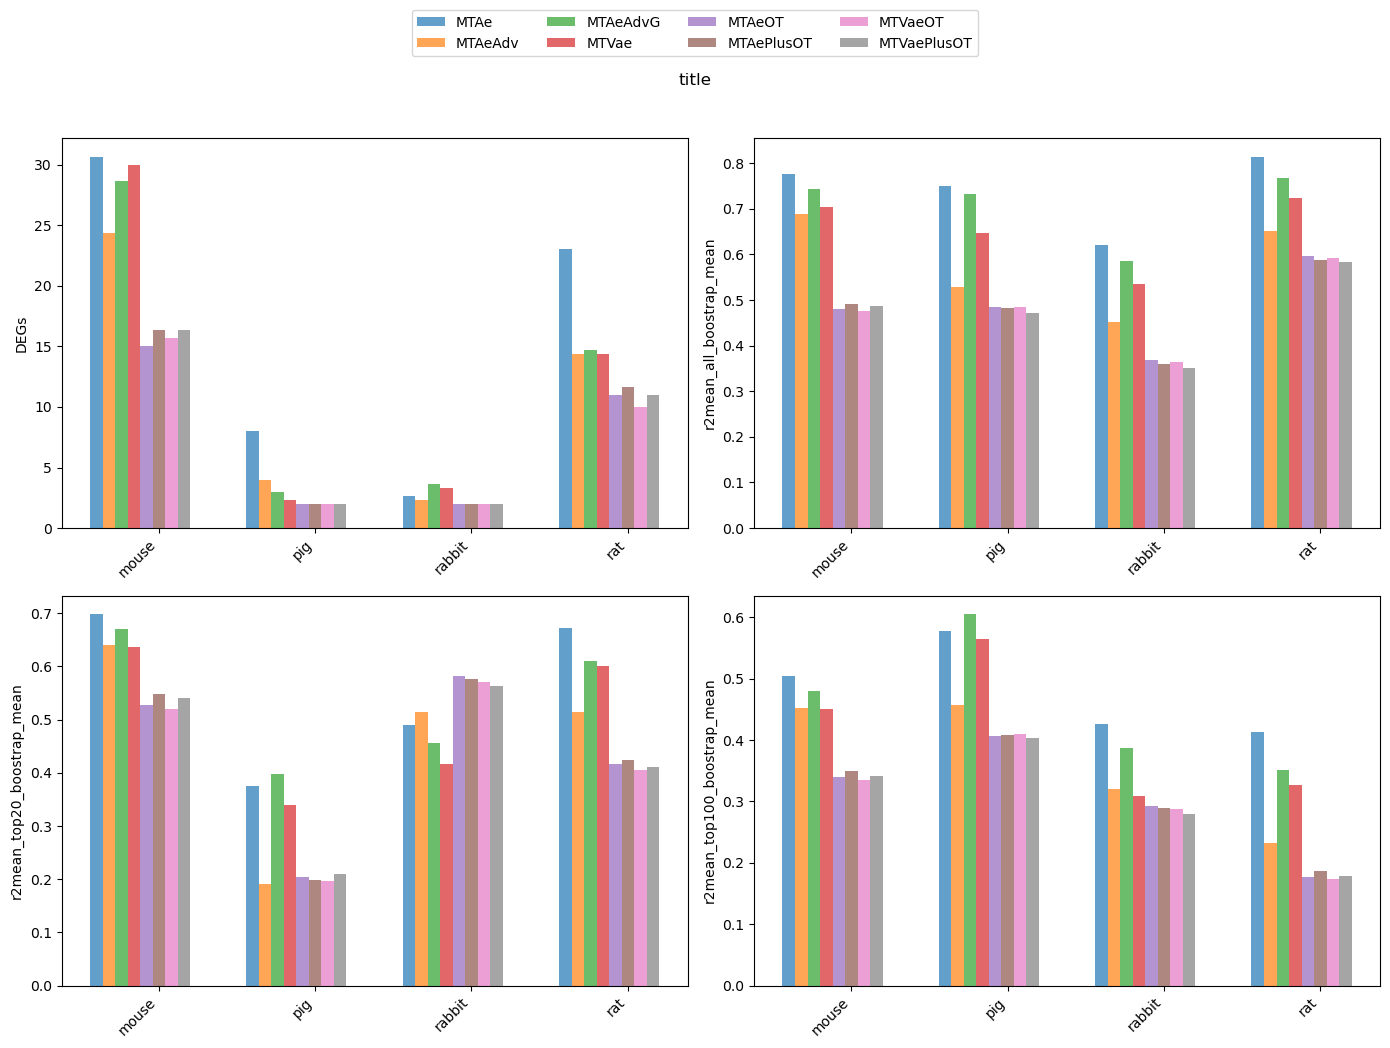

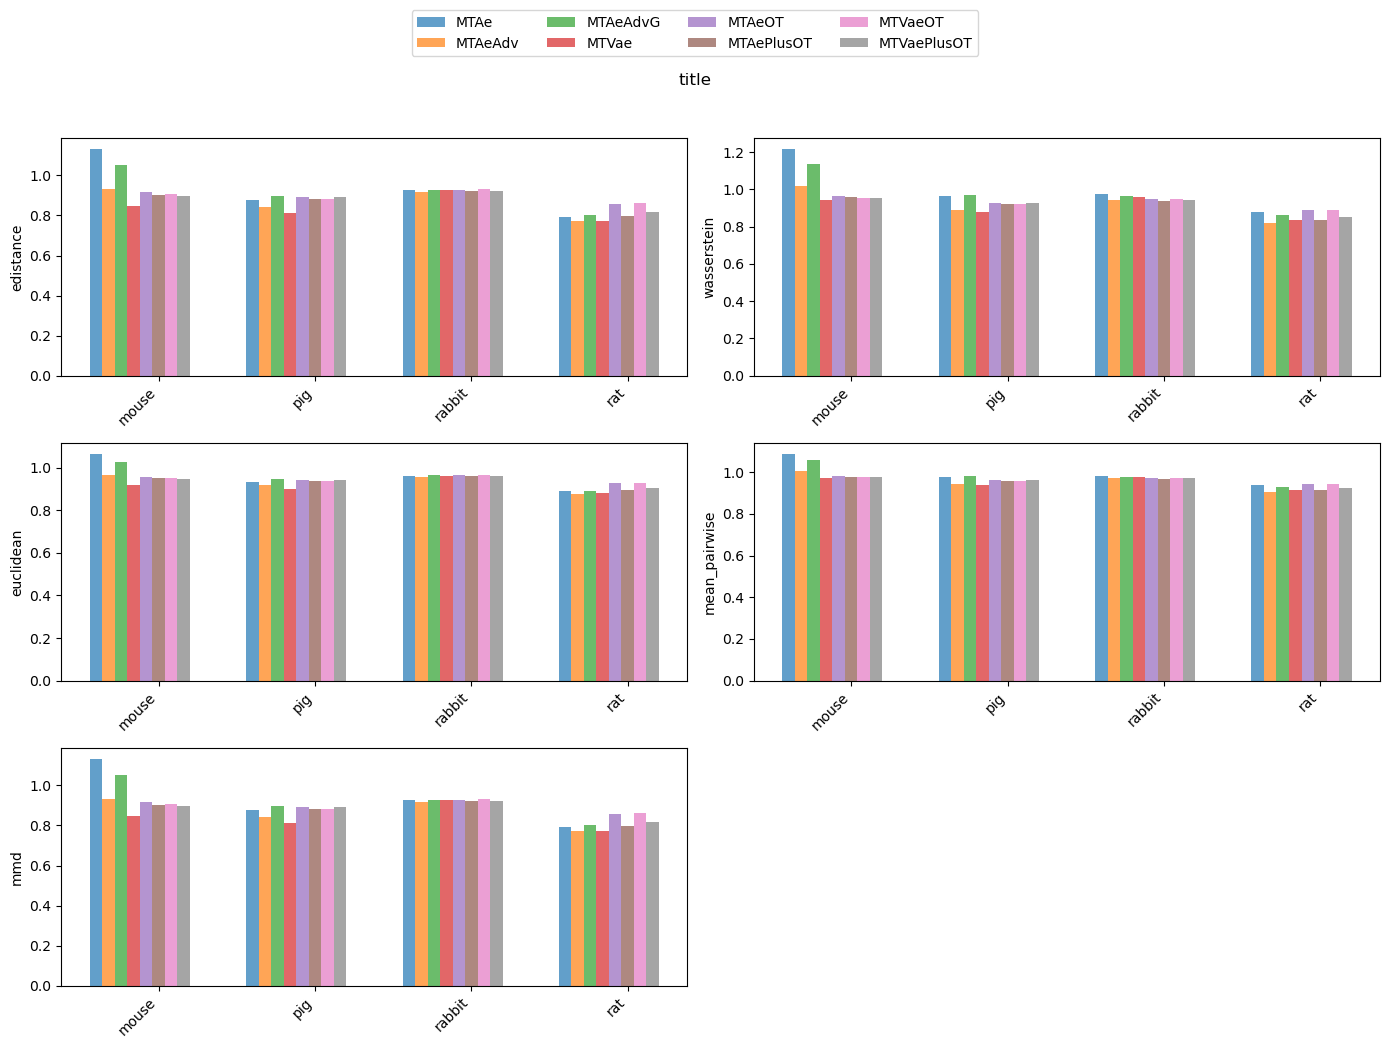

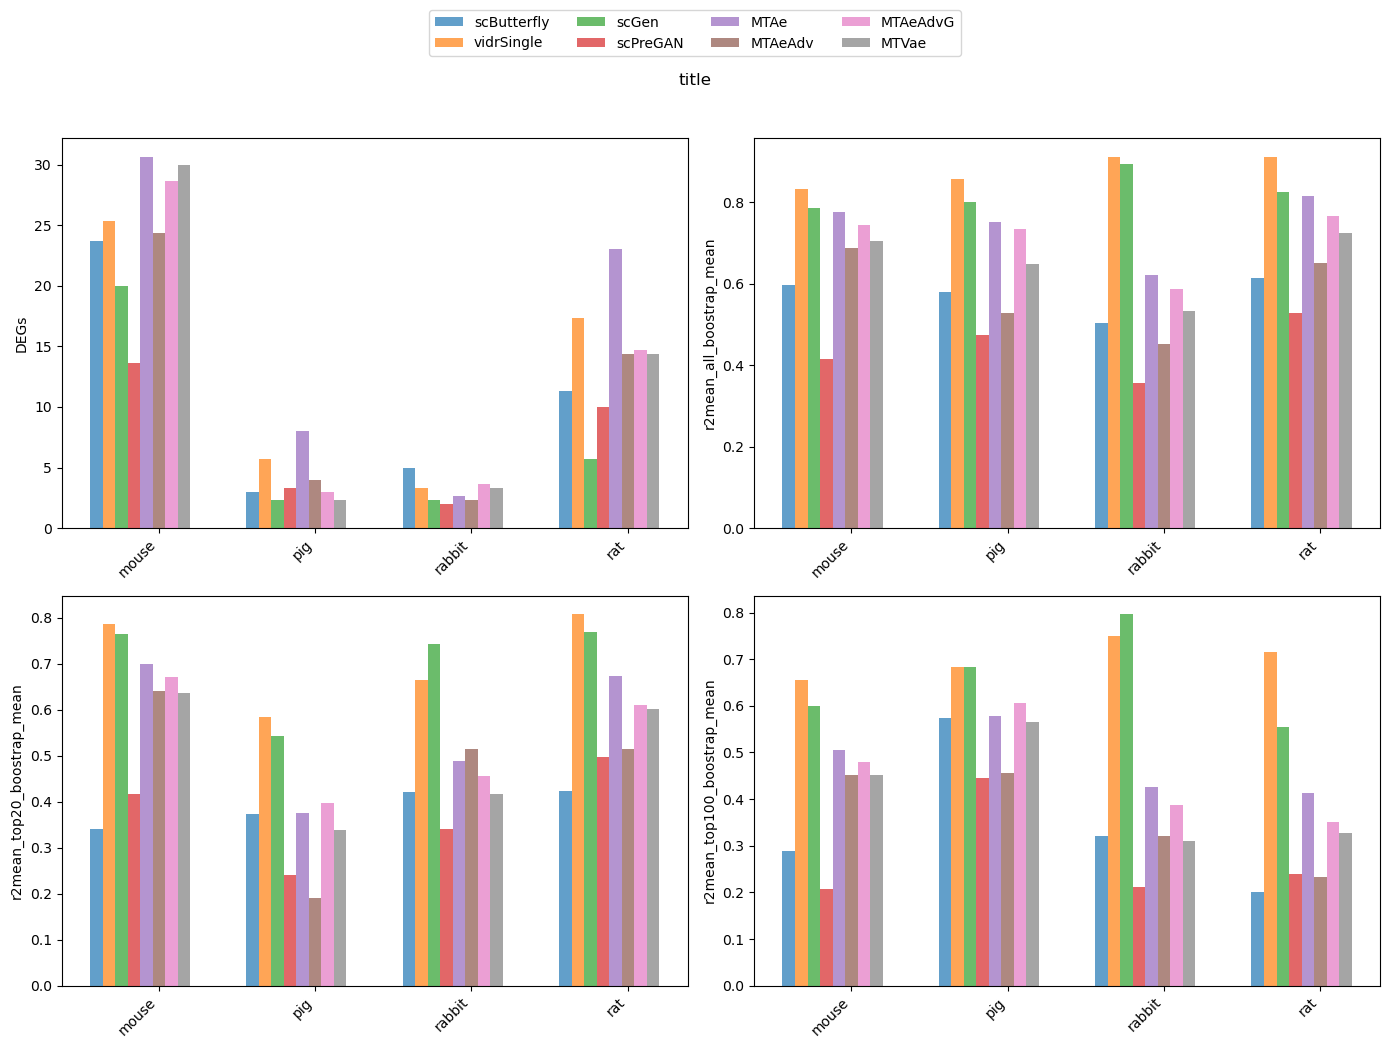

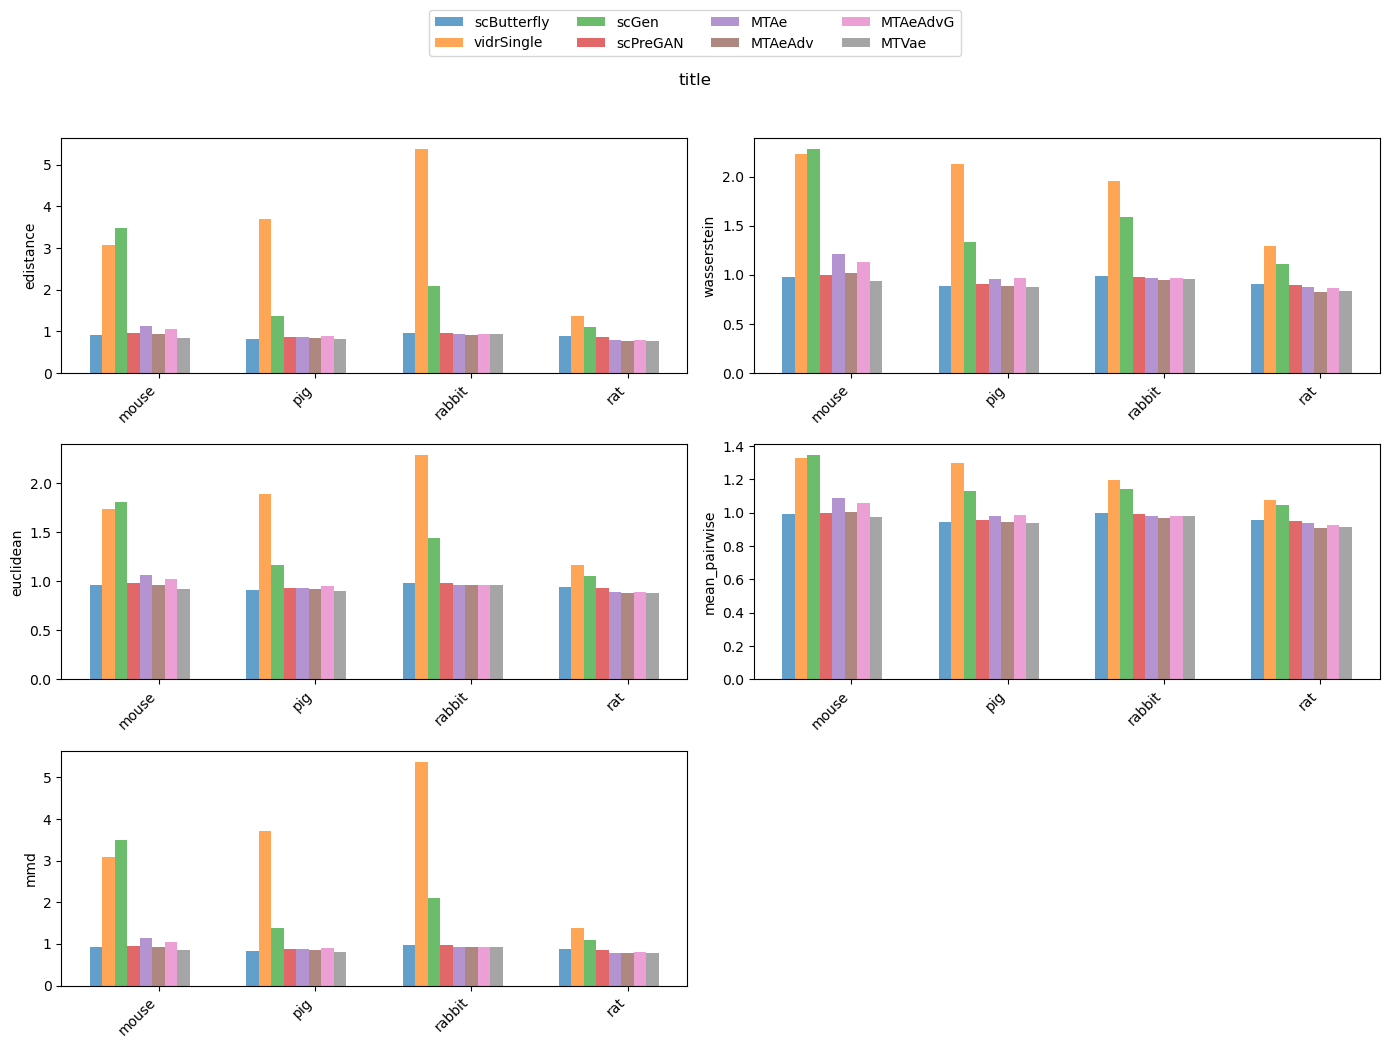

In [76]:
datasets =  []
for seed in [1, 2, 19193]:
    datasets.append(get_dataset_literature_and_multi_task_per_seed_cross_species(seed))
    
dataset = pd.concat(datasets)
mean_dataset = get_dataset_averaging_across_seeds(dataset)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=MODELS_MULTI_TASK, metrics=BASELINE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=MODELS_MULTI_TASK, metrics=DISTANCE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=LITERATURE_SINGLE_MODELS + selected_models, metrics=BASELINE_METRICS)
plot_2d_metrics_per_cell_type(dataset=mean_dataset, title="title", models=LITERATURE_SINGLE_MODELS + selected_models, metrics=DISTANCE_METRICS)

In [77]:
# compare multi task models fine turned\n",
def get_fine_tuned_multi_task_dataset(seed: int):
    dataset_multi_task = METRICS_DF[METRICS_DF["model"].isin(MODELS_MULTI_TASK)]
    dataset_multi_task = dataset_multi_task[dataset_multi_task["dataset"].isin(["NaultMultiplePipeline_NaultPipeline"])]
    dataset_multi_task = dataset_multi_task[dataset_multi_task['experiment_name'].isin([f"bugfix_seed_{seed}"])]

    dataset_multi_task_fine_tuned = METRICS_DF[METRICS_DF["model"].isin(MODELS_MULTI_TASK)]
    dataset_multi_task_fine_tuned = dataset_multi_task_fine_tuned[dataset_multi_task_fine_tuned["dataset"].isin(["NaultMultiplePipeline_NaultPipeline"])]
    dataset_multi_task_fine_tuned = dataset_multi_task_fine_tuned[dataset_multi_task_fine_tuned['experiment_name'].isin([f"no_film_hidden_bugfix_seed_{seed}"])]
    dataset_multi_task_fine_tuned['model'] = dataset_multi_task_fine_tuned['model'] + "noFilm"

    dataset = pd.concat([dataset_multi_task, dataset_multi_task_fine_tuned])
    return dataset

In [78]:
datasets =  []
for seed in [1, 2, 19193]:
    datasets.append(get_fine_tuned_multi_task_dataset(seed))
dataset = pd.concat(datasets)
mean_dataset = get_dataset_averaging_across_seeds(dataset)

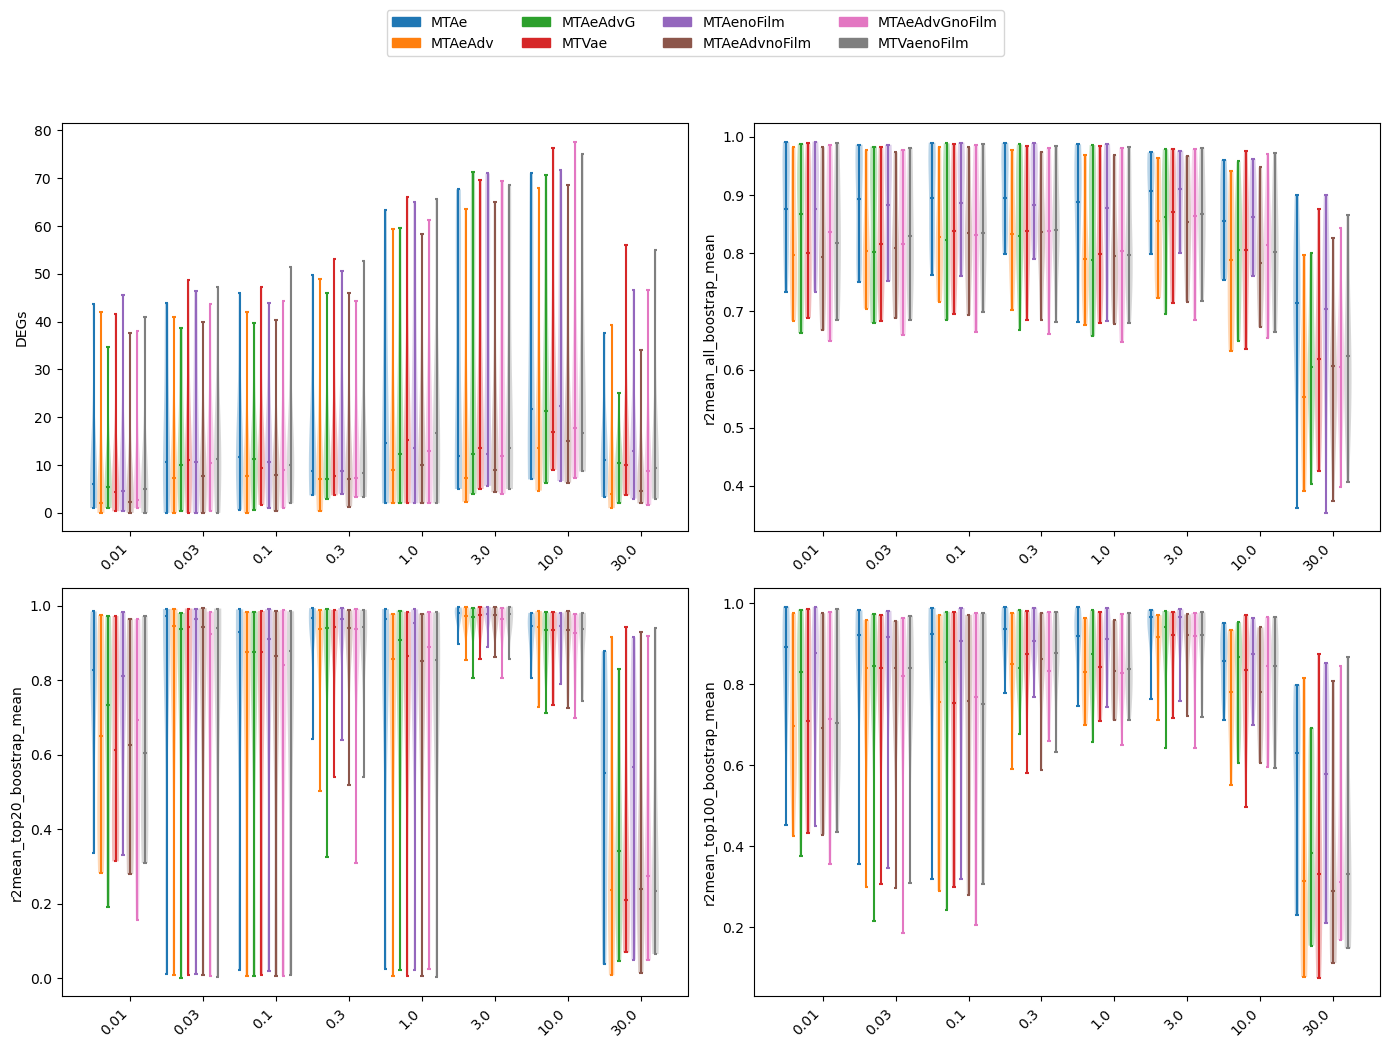

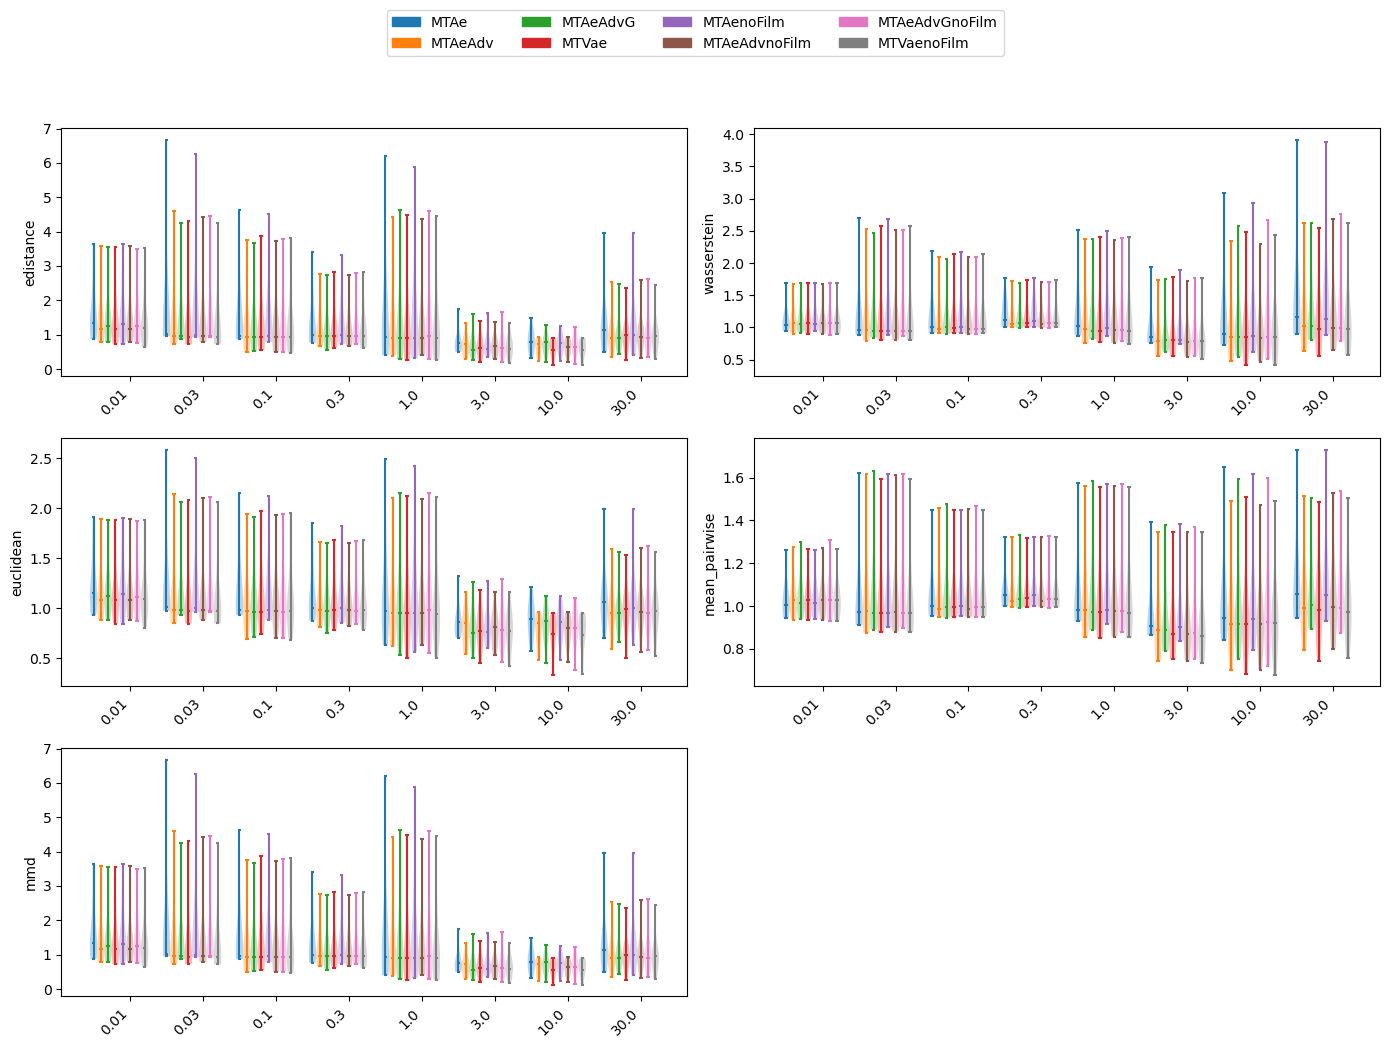

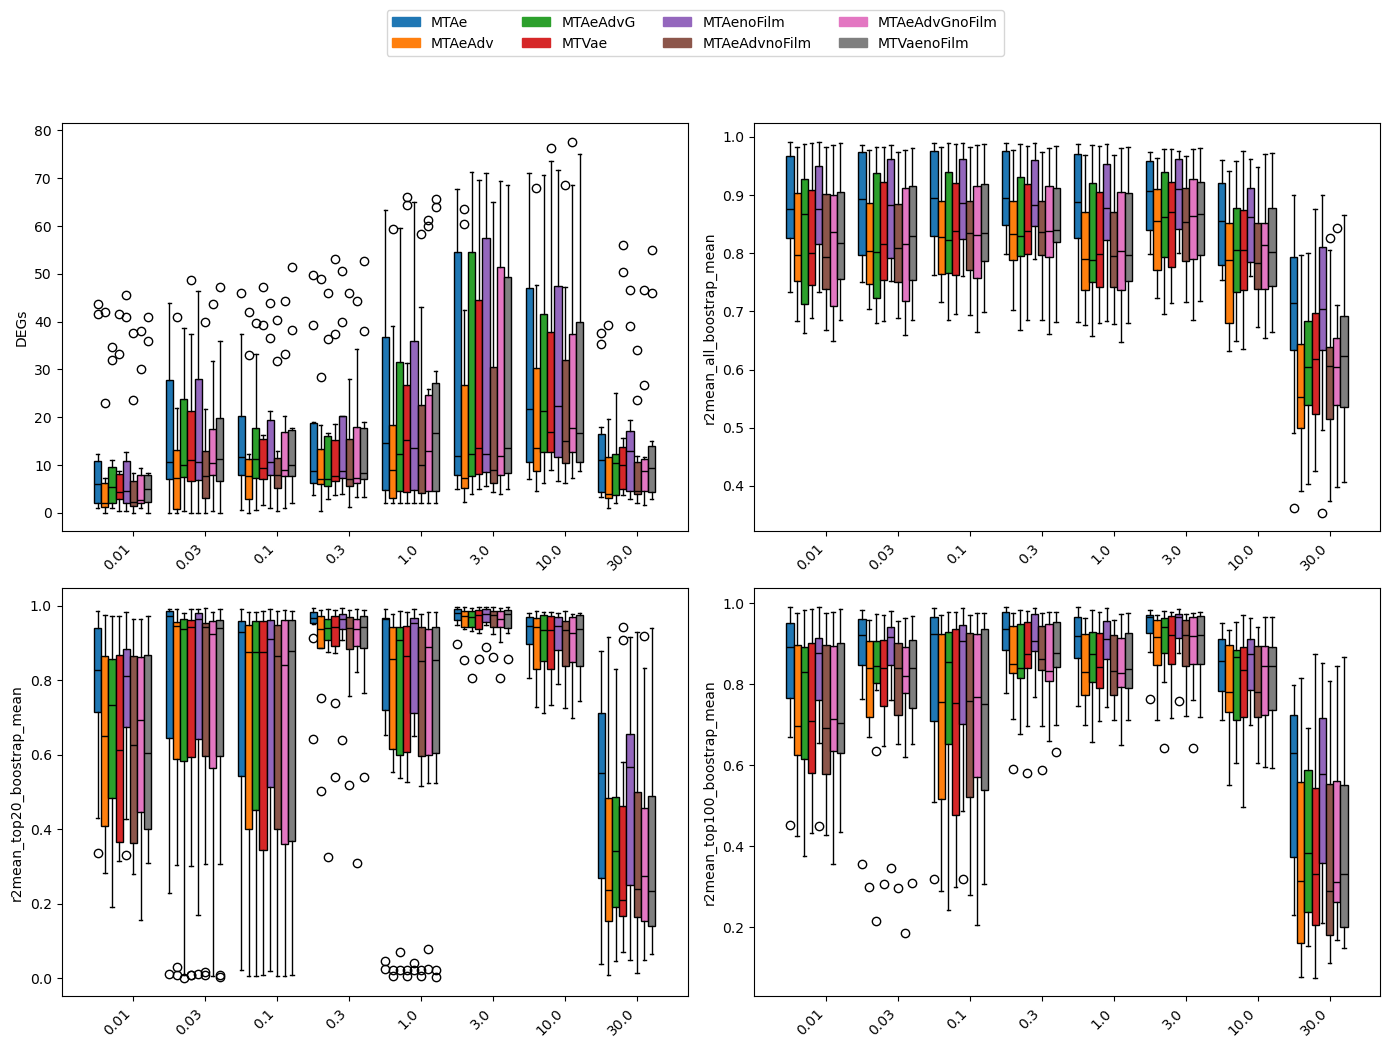

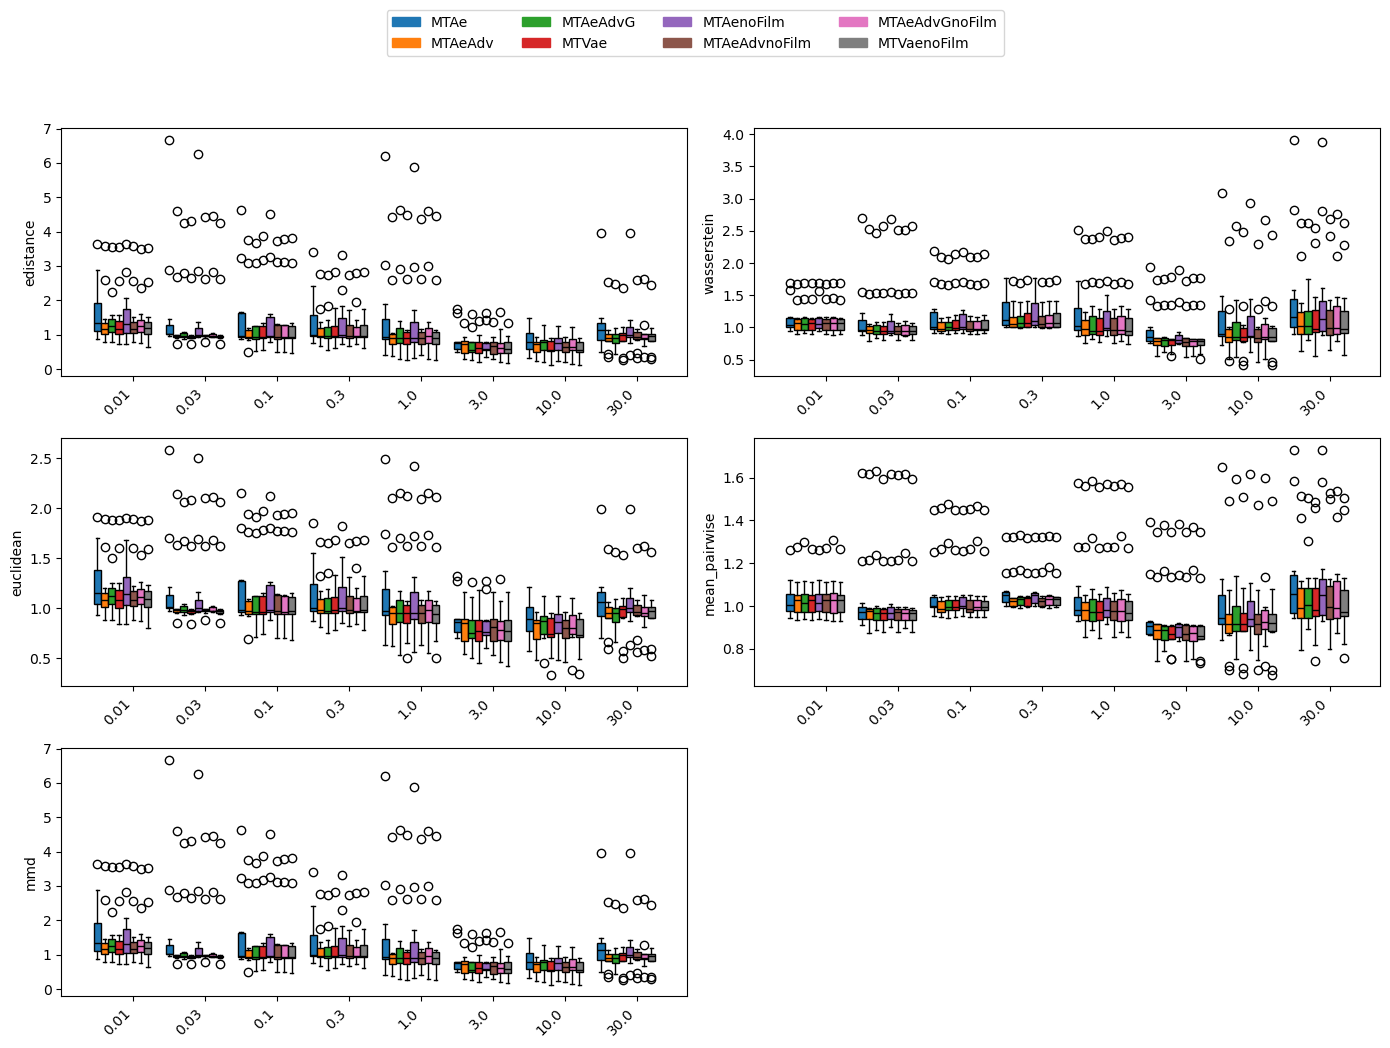

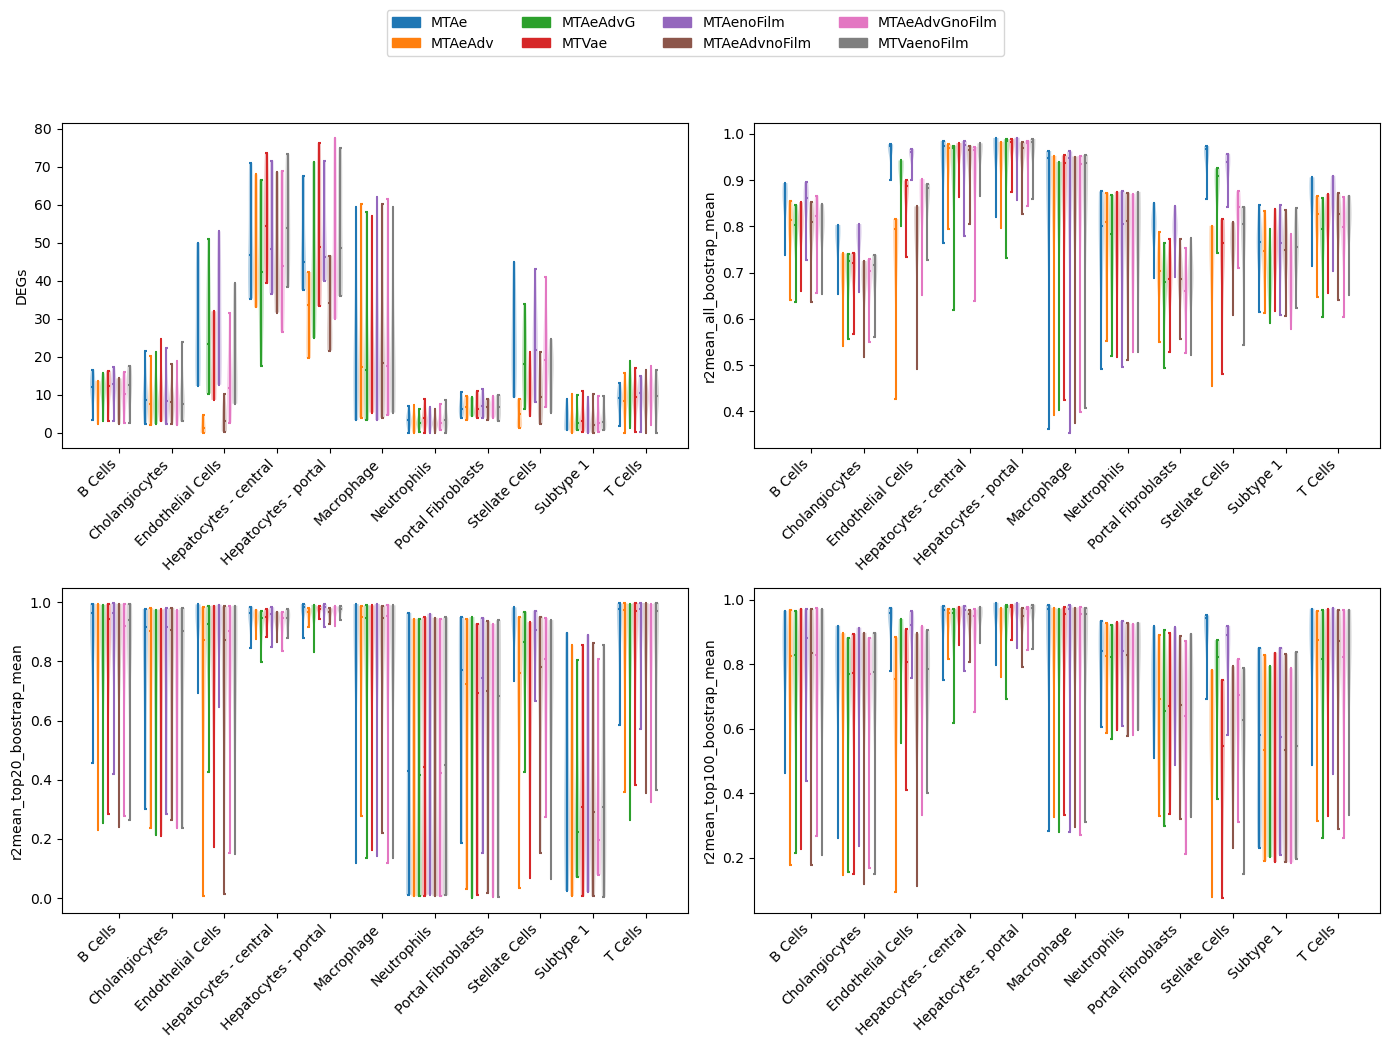

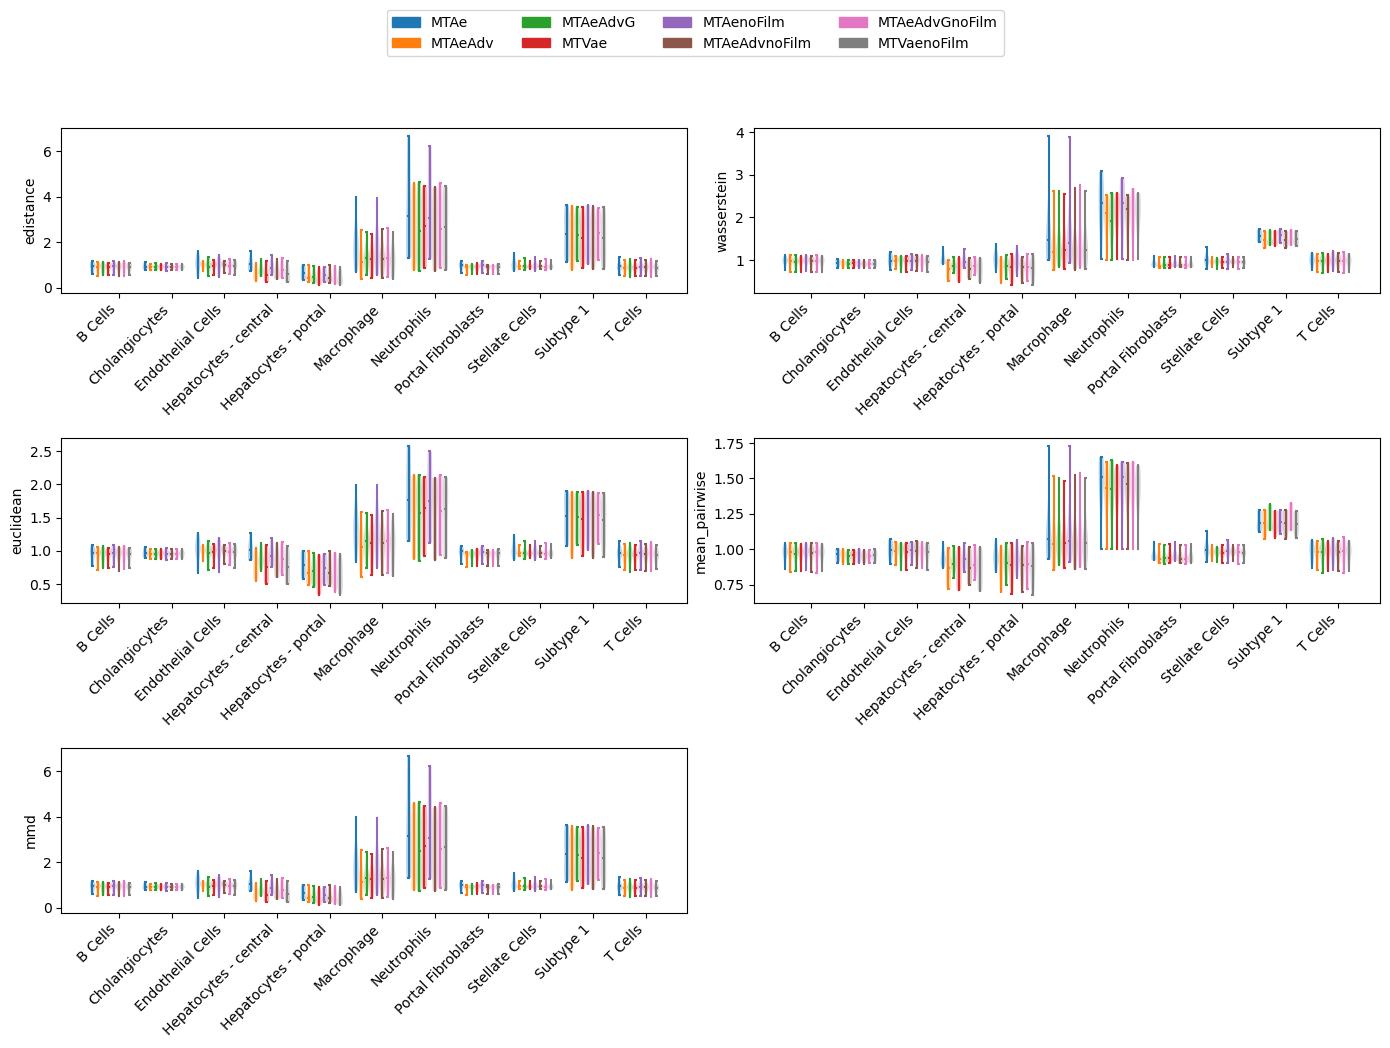

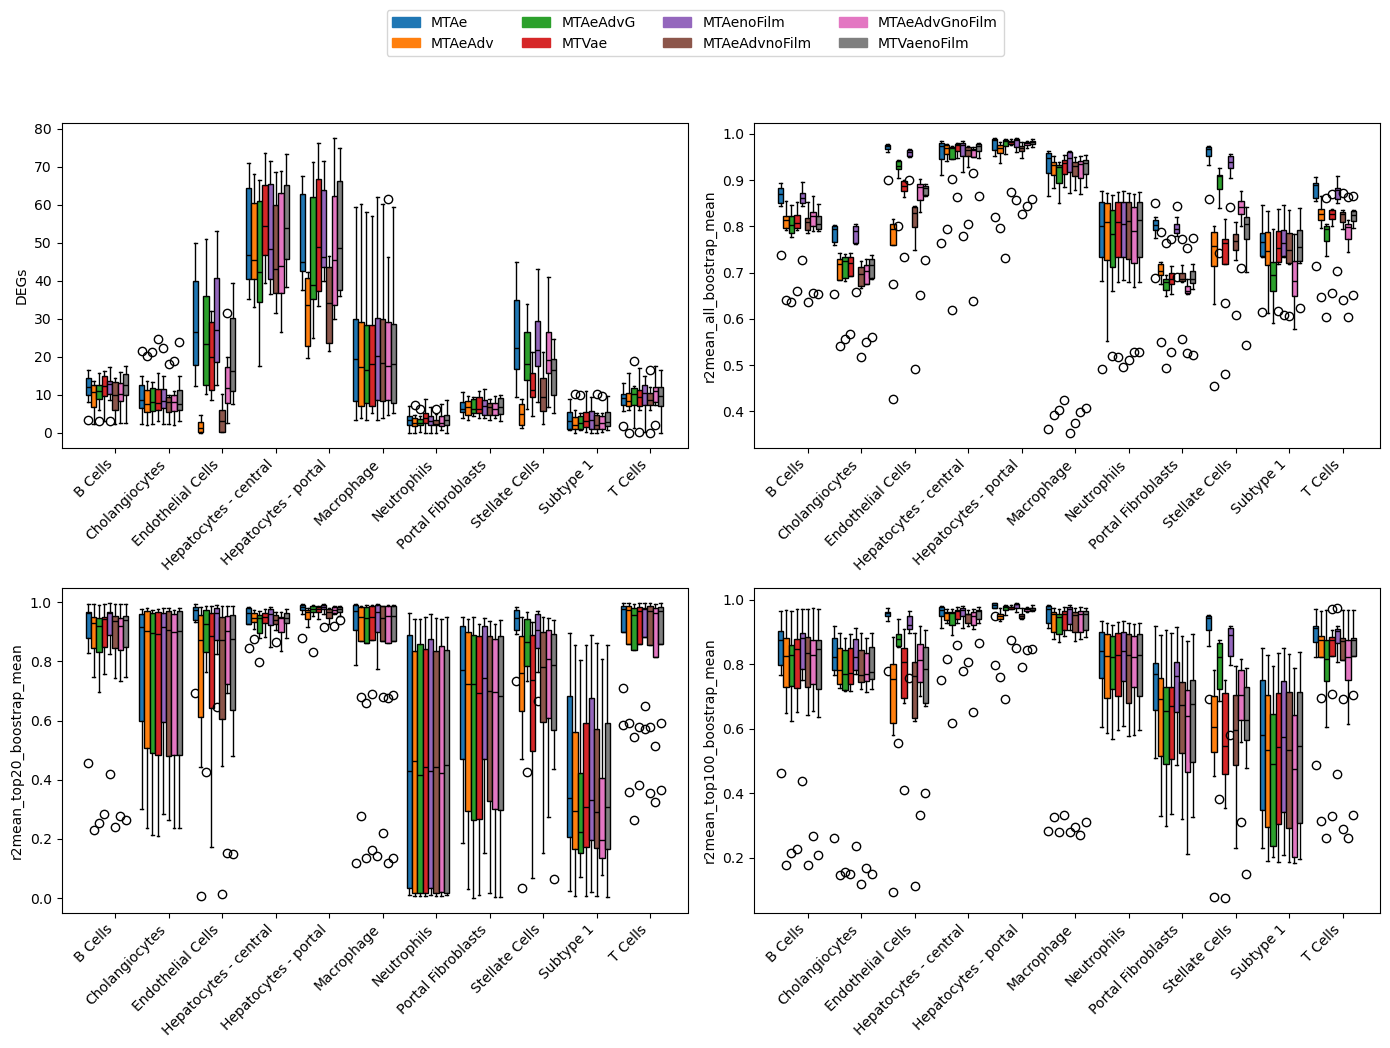

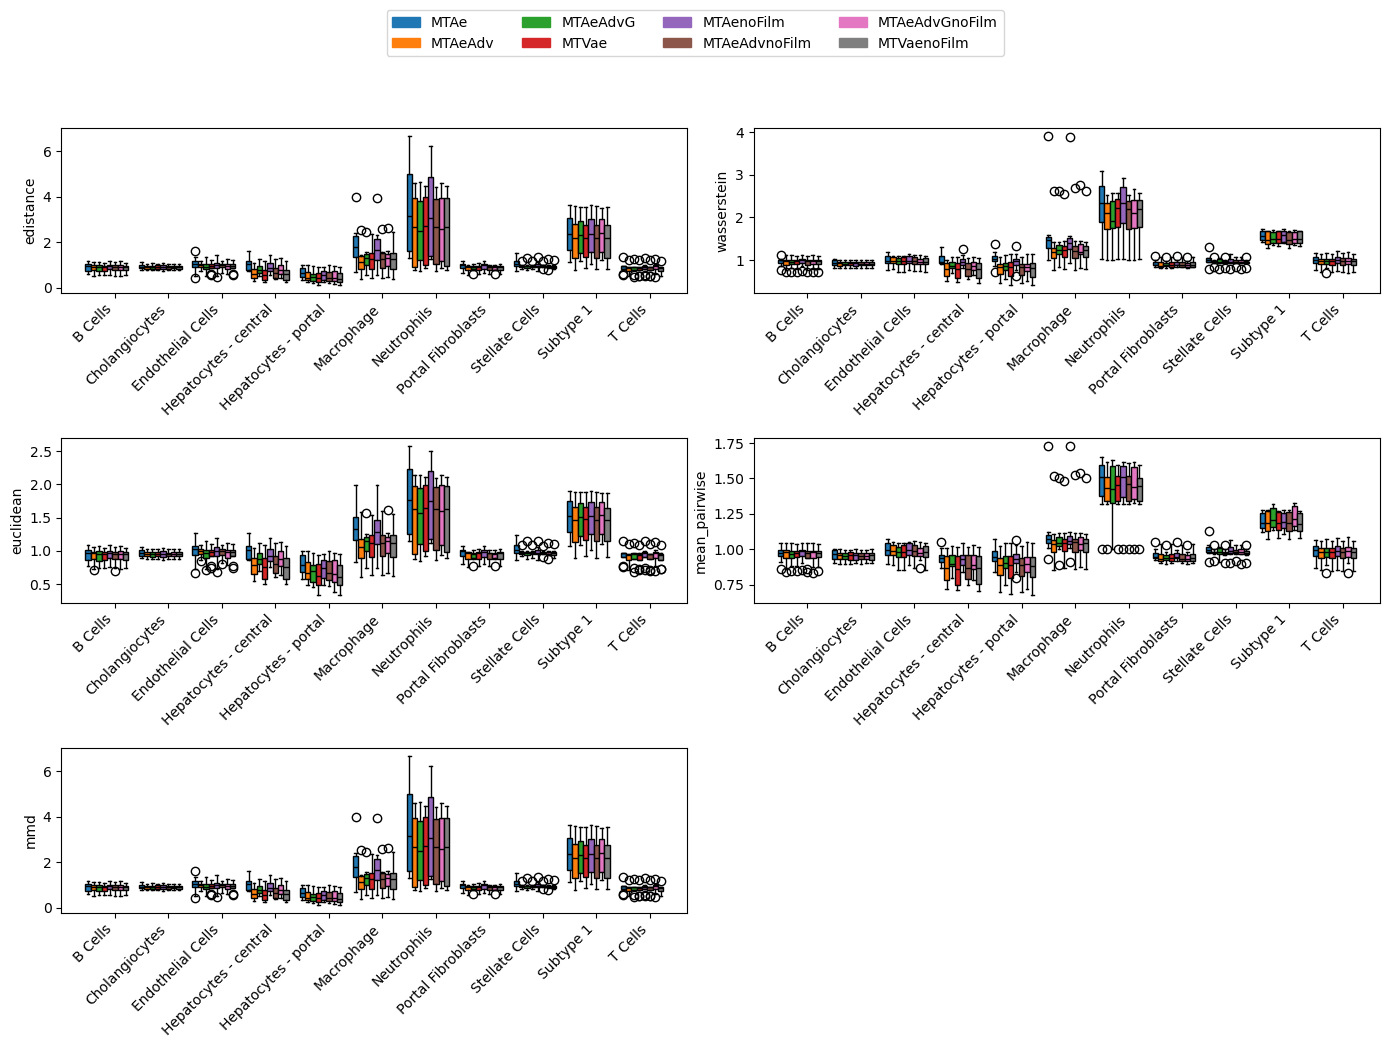

In [79]:
dim_to_reduce = [DimToReduce.X, DimToReduce.Y]
plots = [PlotType.Violin, PlotType.Boxplot]
metrics = [BASELINE_METRICS, DISTANCE_METRICS]


models = ["MTAe", "MTAeAdv", "MTAeAdvG", "MTVae"]
models_fine_tuned = models + [model + "noFilm" for model in models]

for dim in dim_to_reduce:
    for plot in plots:
        for idx, metric in enumerate(metrics):
            get_plot(
                dataset = mean_dataset,
                x_key="cell_type_test",
                y_key="dose",
                dim_to_reduce=dim,
                plot_type=plot,
                title="",
                metrics=metric,
                models=models_fine_tuned
                #file_name_to_save=f'NaultPipeline_{dim.name}_{plot.name}_metrics{idx}'
            )

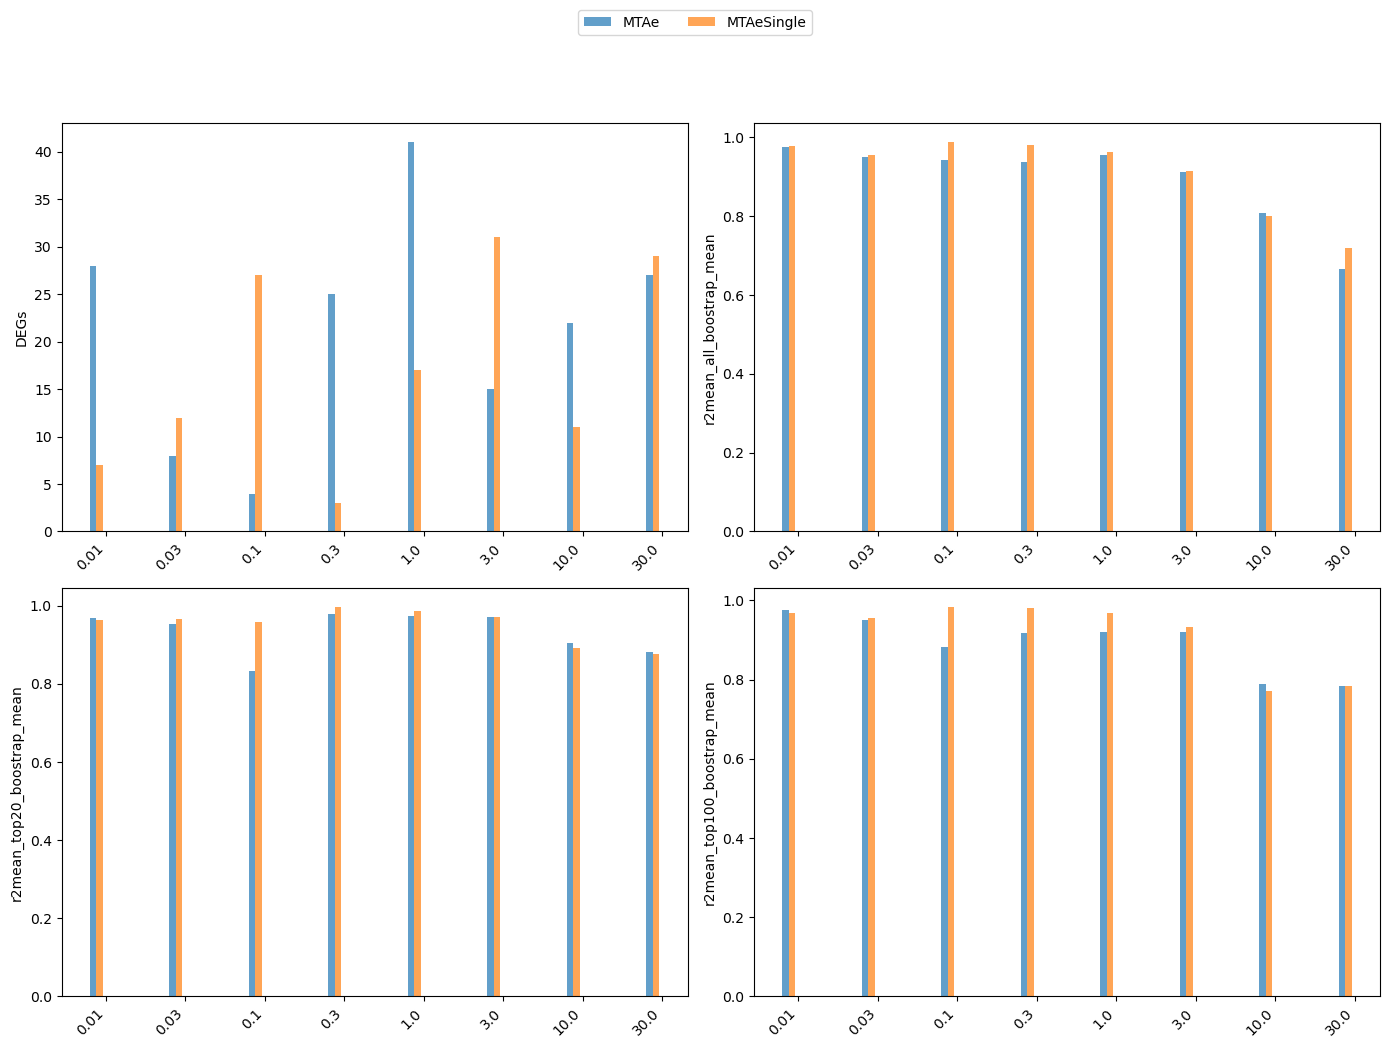

In [80]:
# compare the multi task with each single case

dataset_str = [
    "NaultMultiplePipeline_NaultPipeline",
]
dataset = METRICS_DF[METRICS_DF["dataset"].isin(dataset_str)]
seed = 1
single_experiment_names = [
    "dosage_0_01",
    "dosage_0_03",
    "dosage_0_1",
    "dosage_0_3",
    "dosage_1_0",
    "dosage_3_0",
    "dosage_10_0",
    "dosage_30_0",
]
single_experiment_names = [f"{name}_{seed}" for name in single_experiment_names]
dataset.loc[dataset["experiment_name"].isin(single_experiment_names), "model"] = "MTAeSingle"
dataset = dataset[dataset["experiment_name"].isna() | dataset["experiment_name"].isin(single_experiment_names)]

models = ["MTAe", "MTAeSingle"]

plot_2d_metrics_per_dosage(
    dataset=dataset,
    cell_type="Hepatocytes - portal",
    models=models,
    title="",
)

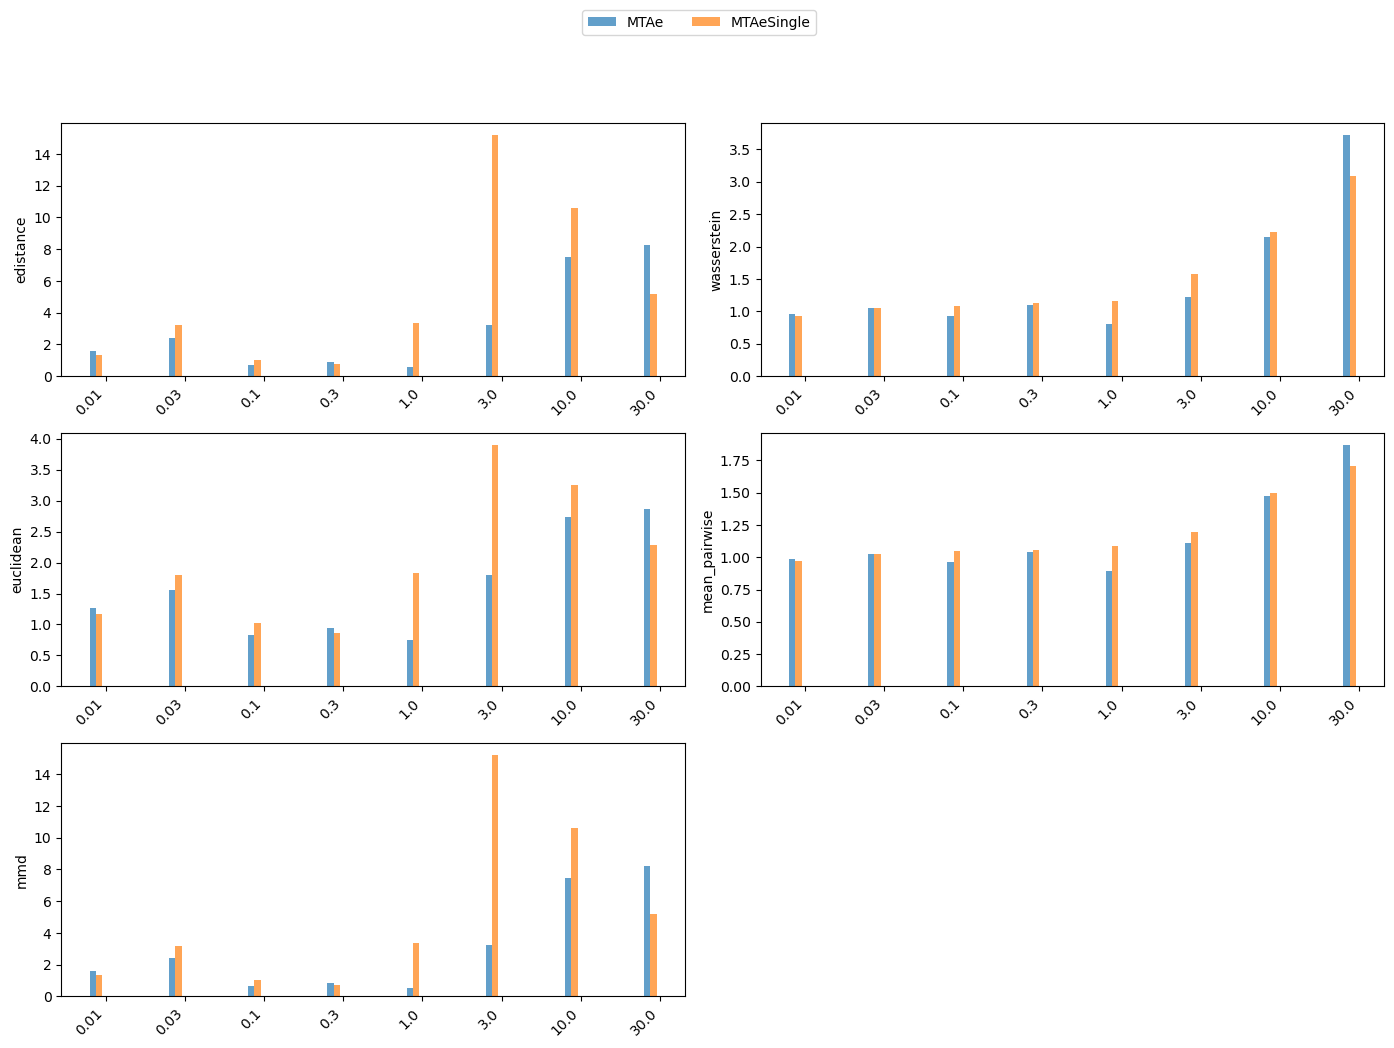

In [81]:
plot_2d_metrics_per_dosage(
    dataset=dataset,
    cell_type="Hepatocytes - portal",
    models=models,
    title="",
    metrics=DISTANCE_METRICS
)

In [82]:
def seed_utility(seed):
    dataset = METRICS_DF[METRICS_DF["model"] == "MTAe"]
    dataset = dataset[dataset["experiment_name"].str.startswith("dosage_", na=False)]
    
    dataset = dataset[
        dataset["experiment_name"].str.endswith(f"_{seed}")]
    
    def extract_seed(exp_name):
        parts = exp_name.rsplit("_", 1)  # Split at the last "_"
        if len(parts) == 2 and parts[1].isdigit():
            return parts[0], int(parts[1])  # Clean name, seed as int
        return exp_name, None  # Keep original if no match

    # Apply function to create new columns
    dataset[["experiment_name", "seed"]] = dataset["experiment_name"].apply(lambda x: pd.Series(extract_seed(x)))
    return dataset

df = []
for seed in [1, 2, 19193]:
    df.append(seed_utility(seed))
filtered_dataset = pd.concat(df)

# average across seeds and calculate std
agg_dataset = filtered_dataset.groupby(["experiment_name", "dose", "model", "dataset", "cell_type_test"])[METRICS].agg(['mean', 'std']).reset_index()

new_columns = []
for col in agg_dataset.columns:
    if col[1] == "mean" or col[1] == '':
        new_columns.append(col[0])
    else:
        new_columns.append(f"{col[0]}_{col[1]}")
agg_dataset.columns = new_columns
agg_dataset

experiment_name   dose model                              dataset  \
0              dosage_0_01   0.01  MTAe  NaultMultiplePipeline_NaultPipeline   
1         dosage_0_01_0_03   0.01  MTAe  NaultMultiplePipeline_NaultPipeline   
2         dosage_0_01_0_03   0.03  MTAe  NaultMultiplePipeline_NaultPipeline   
3     dosage_0_01_0_03_0_1   0.01  MTAe  NaultMultiplePipeline_NaultPipeline   
4     dosage_0_01_0_03_0_1   0.03  MTAe  NaultMultiplePipeline_NaultPipeline   
...                    ...    ...   ...                                  ...   
1019  dosage_3_0_10_0_30_0   3.00  MTAe  NaultMultiplePipeline_NaultPipeline   
1020  dosage_3_0_10_0_30_0  10.00  MTAe  NaultMultiplePipeline_NaultPipeline   
1021  dosage_3_0_10_0_30_0  30.00  MTAe  NaultMultiplePipeline_NaultPipeline   
1022       dosage_3_0_30_0   3.00  MTAe  NaultMultiplePipeline_NaultPipeline   
1023       dosage_3_0_30_0  30.00  MTAe  NaultMultiplePipeline_NaultPipeline   

            cell_type_test       DEGs   DEGs_std  r2mean_all_boostrap_mean  \
0     Hepatocytes - portal   5.333333   3.785939                  0.976771   
1     Hepatocytes - portal   2.333333   2.309401                  0.968721   
2     Hepatocytes - portal   7.000000   5.291503                  0.950829   
3     Hepatocytes - portal  12.333333   1.527525                  0.962286   
4     Hepatocytes - portal   8.000000   1.000000                  0.938152   
...                    ...        ...        ...                       ...   
1019  Hepatocytes - portal  41.000000  11.532563                  0.924894   
1020  Hepatocytes - portal  35.000000  22.113344                  0.834401   
1021  Hepatocytes - portal  26.000000  15.132746                  0.659837   
1022  Hepatocytes - portal  46.666667   1.527525                  0.935651   
1023  Hepatocytes - portal  43.666667   1.527525                  0.666778   

      r2mean_all_boostrap_mean_std  r2mean_top20_boostrap_mean  ...  \
0                         0.001784                    0.959596  ...   
1                         0.007252                    0.943297  ...   
2                         0.003789                    0.952418  ...   
3                         0.000553                    0.924224  ...   
4                         0.000972                    0.928009  ...   
...                            ...                         ...  ...   
1019                      0.026388                    0.971717  ...   
1020                      0.033022                    0.896368  ...   
1021                      0.034121                    0.867837  ...   
1022                      0.006301                    0.976477  ...   
1023                      0.007915                    0.891802  ...   

      edistance  edistance_std  wasserstein  wasserstein_std  euclidean  \
0      1.306252       0.231449     0.933491         0.014845   1.139812   
1      1.072593       0.132960     0.911915         0.009558   1.034373   
2      2.115048       0.344001     1.028694         0.028601   1.451011   
3      1.153890       0.026627     0.931067         0.004922   1.074145   
4      1.823104       0.061732     1.032176         0.008847   1.350094   
...         ...            ...          ...              ...        ...   
1019   3.397098       2.818217     1.175130         0.390627   1.715387   
1020   7.436918       7.064954     1.877293         0.476008   2.529162   
1021  18.644160      10.689268     4.290173         0.784578   4.162785   
1022   2.205843       0.664878     1.078076         0.117272   1.474473   
1023  12.010564       2.401289     4.132157         0.226924   3.454099   

      euclidean_std  mean_pairwise  mean_pairwise_std        mmd    mmd_std  
0          0.103051       0.967527           0.007741   1.306251   0.231449  
1          0.063221       0.956383           0.004809   1.072593   0.132959  
2          0.120085       1.011696           0.014116   2.115047   0.344001  
3          0.012398       0.965104           0.

In [83]:
import seaborn as sns

def compare(dataset, best_threshold=5, worst_threshold=5):
    best_experiments = []
    worst_experiments = []

    cell_types = dataset["cell_type_test"].unique()
    print(cell_types) # apparently I have tested only for the Hepatocytes - portal

    for idx, metrics_set in enumerate([BASELINE_METRICS, DISTANCE_METRICS]):
        best_experiments_cell_type = []
        worst_experiments_cell_type = []
        for cell_type in cell_types:
            dataset = dataset[dataset["cell_type_test"] == cell_type]
            for metric in metrics_set:
                plt.figure()
                sns.boxplot(y=dataset[metric])
                dataset = dataset.sort_values(by=[metric], ascending=False if idx == 0 else True)
                #print("best")
                #print(sorted(dataset['experiment_name'].values[:best_threshold]))
                best_experiments_cell_type.append(dataset['experiment_name'].values[:best_threshold])
                #print("worst")
                #print(sorted(dataset['experiment_name'].values[-worst_threshold:]))
                worst_experiments_cell_type.append(dataset['experiment_name'].values[-worst_threshold:])
                plt.show()
    
        best_cell_type_common_elements = set.intersection(*map(set, best_experiments_cell_type))  
        worst_cell_type_common_elements = set.intersection(*map(set, worst_experiments_cell_type))
        print("best cell type common", best_cell_type_common_elements)
        print("worst cell type common", worst_cell_type_common_elements)
        if len(best_cell_type_common_elements) == 0:
            raise ValueError("Increase best threshold")
        if len(worst_cell_type_common_elements) == 0:
            raise ValueError("Increase worst threshold")
        best_experiments.append(list(best_cell_type_common_elements))
        worst_experiments.append(list(worst_cell_type_common_elements))
        
    best_common_elements = set.intersection(*map(set, best_experiments))  
    worst_common_elements = set.intersection(*map(set, worst_experiments))    
    print("best for all metrics set common", best_common_elements)
    print("worst for all metrics set common", worst_common_elements)
    return best_common_elements, worst_common_elements

def compare_combinations_with_aggregation(dose: float, best_threshold=5, worst_threshold=5):
    dataset = agg_dataset[agg_dataset["dose"] == dose]
    return compare(dataset, best_threshold, worst_threshold)

def compare_combinations(seed: int, dose: float, best_threshold=5, worst_threshold=5):
    dataset = METRICS_DF[METRICS_DF["model"] == "MTAe"]
    dataset = dataset[dataset["experiment_name"].str.startswith("dosage_", na=False)]

    dataset = dataset[
        dataset["experiment_name"].str.endswith(f"_{seed}")
    ]

    # experiments per dose
    dataset = dataset[dataset["dose"] == dose]
    print("Num of experiments", len(dataset["experiment_name"].unique()))
    compare(dataset, best_threshold, worst_threshold)

Num of experiments 128
['Hepatocytes - portal']


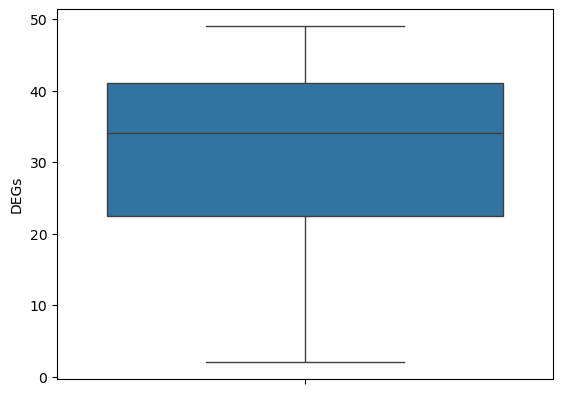

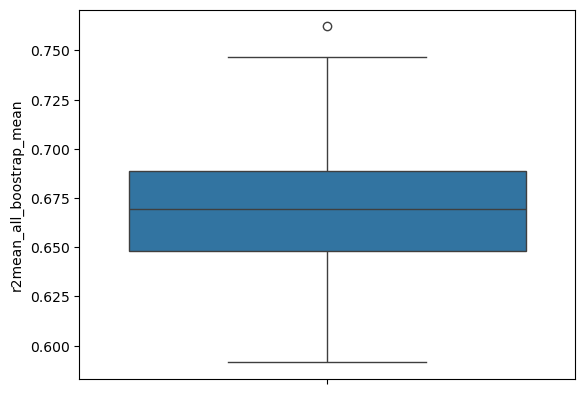

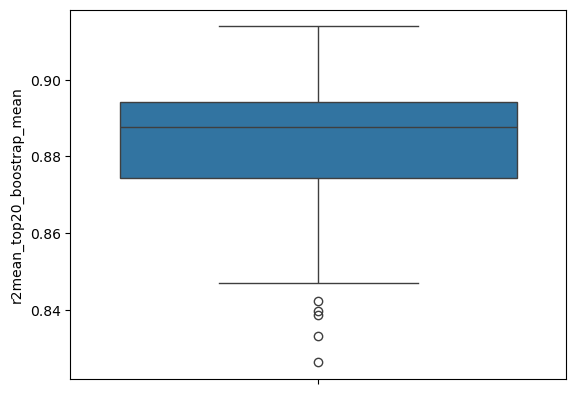

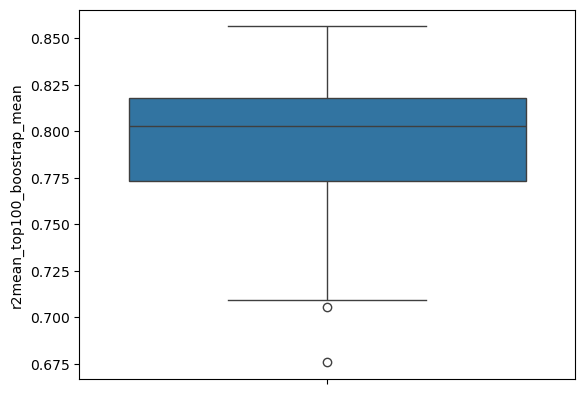

best cell type common {'dosage_0_1_0_3_10_0_30_0_1'}
worst cell type common {'dosage_0_01_0_1_0_3_1_0_10_0_30_0_1'}


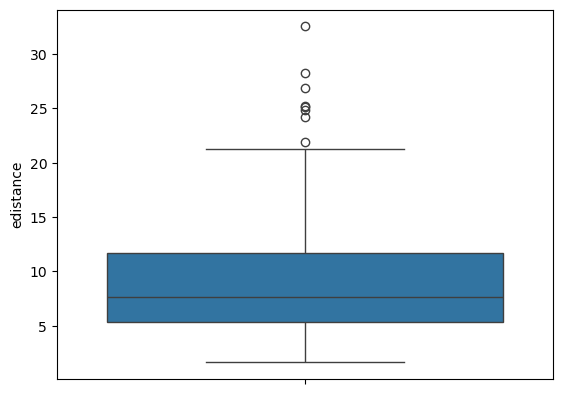

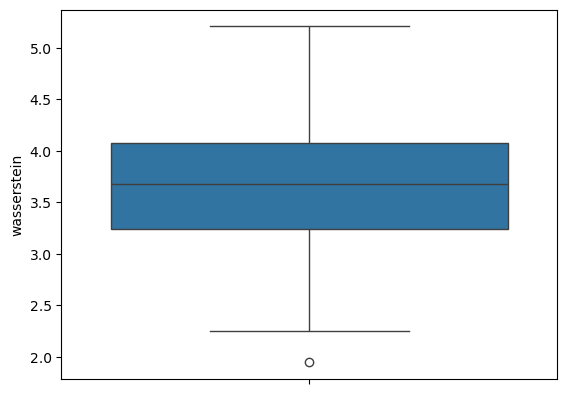

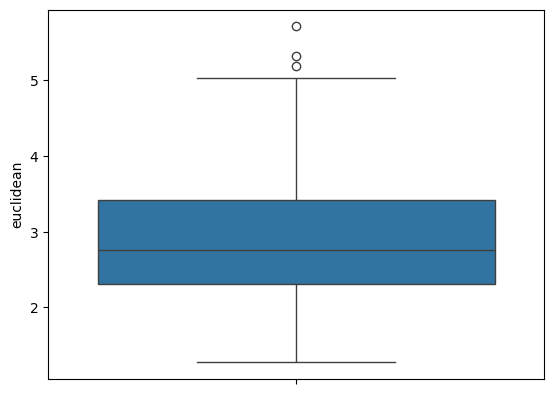

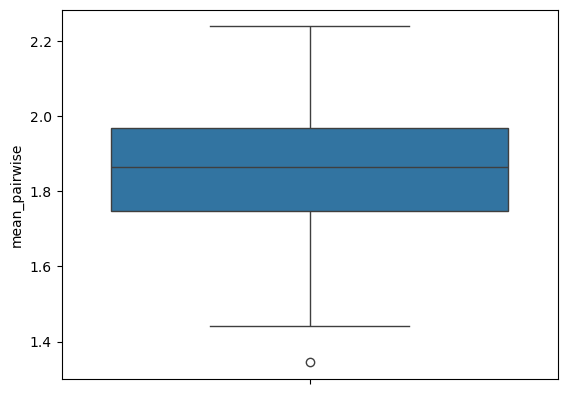

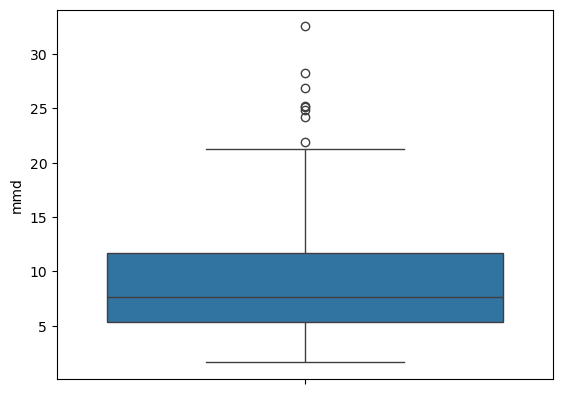

best cell type common {'dosage_1_0_3_0_10_0_30_0_1', 'dosage_0_01_0_03_0_1_3_0_10_0_30_0_1', 'dosage_1_0_10_0_30_0_1', 'dosage_0_1_0_3_10_0_30_0_1', 'dosage_0_1_1_0_3_0_10_0_30_0_1'}
worst cell type common {'dosage_0_01_0_1_0_3_1_0_10_0_30_0_1', 'dosage_0_03_0_1_0_3_1_0_10_0_30_0_1', 'dosage_0_3_10_0_30_0_1'}
best for all metrics set common {'dosage_0_1_0_3_10_0_30_0_1'}
worst for all metrics set common {'dosage_0_01_0_1_0_3_1_0_10_0_30_0_1'}


In [84]:
compare_combinations(seed=1, dose=30)

Num of experiments 128
['Hepatocytes - portal']


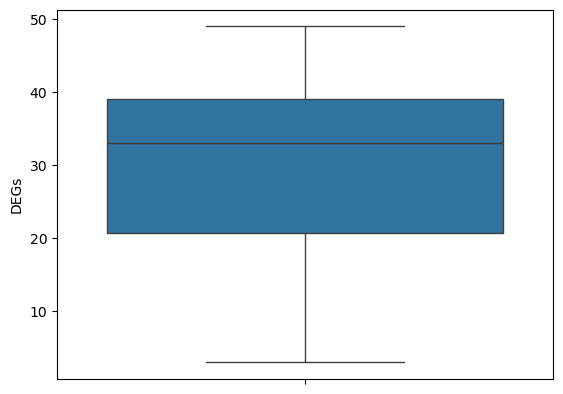

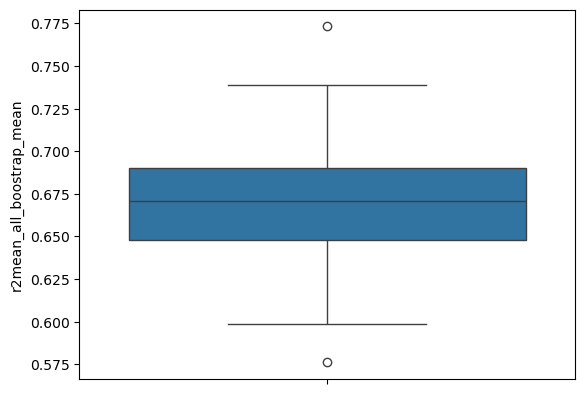

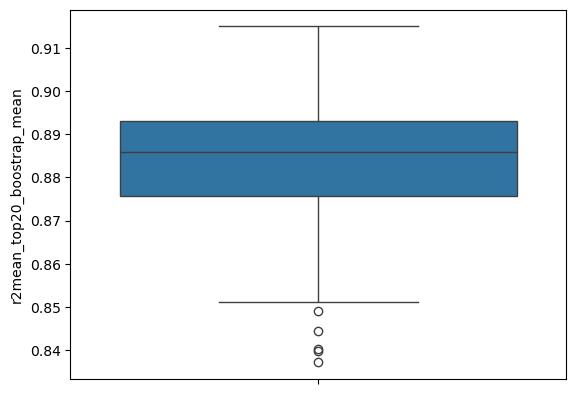

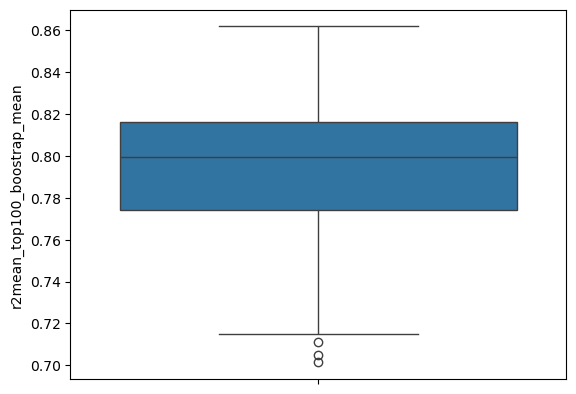

best cell type common {'dosage_0_3_3_0_10_0_30_0_2', 'dosage_0_01_0_3_10_0_30_0_2'}
worst cell type common {'dosage_0_03_0_3_1_0_10_0_30_0_2'}


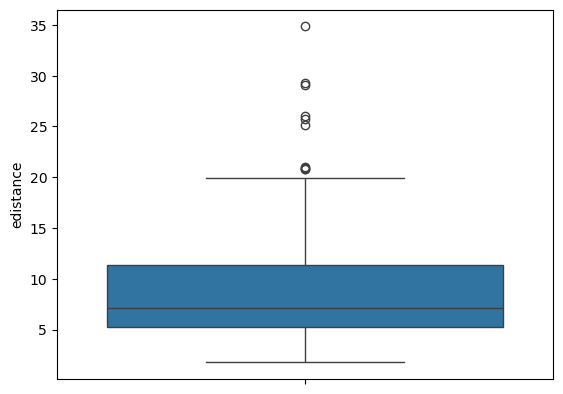

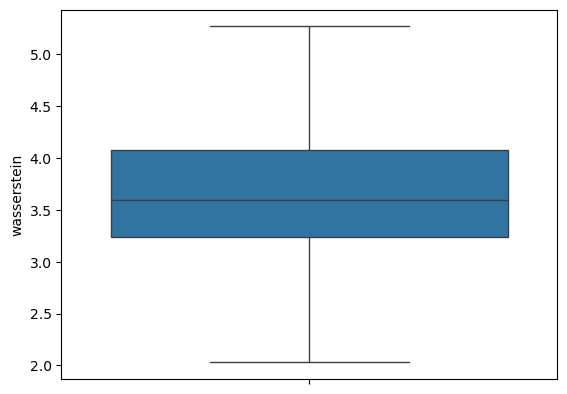

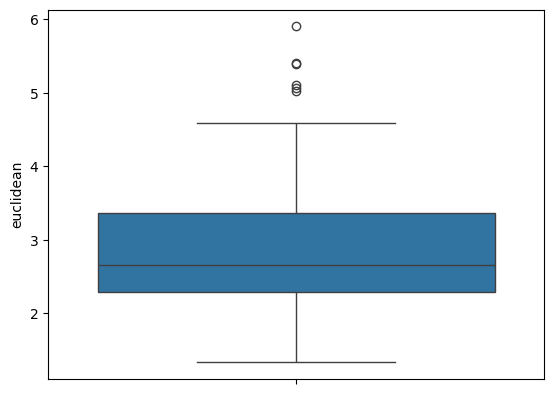

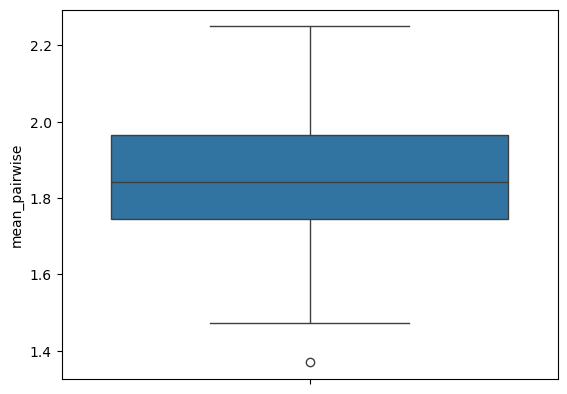

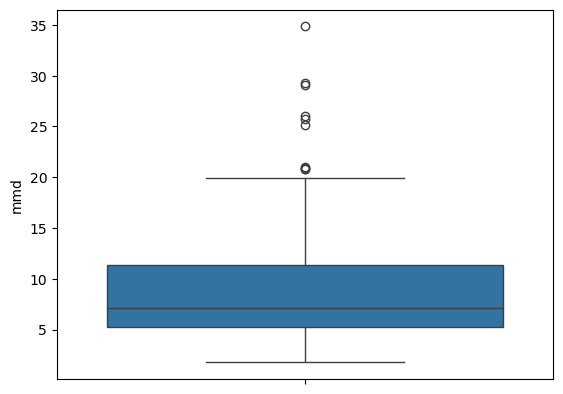

best cell type common {'dosage_0_03_0_1_1_0_30_0_2', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0_2', 'dosage_0_3_3_0_10_0_30_0_2', 'dosage_0_01_0_1_0_3_3_0_30_0_2', 'dosage_0_01_0_3_10_0_30_0_2'}
worst cell type common {'dosage_0_01_0_3_1_0_10_0_30_0_2', 'dosage_0_01_1_0_10_0_30_0_2', 'dosage_0_03_0_3_1_0_10_0_30_0_2'}
best for all metrics set common {'dosage_0_3_3_0_10_0_30_0_2', 'dosage_0_01_0_3_10_0_30_0_2'}
worst for all metrics set common {'dosage_0_03_0_3_1_0_10_0_30_0_2'}


In [85]:
compare_combinations(seed=2, dose=30)

Num of experiments 128
['Hepatocytes - portal']


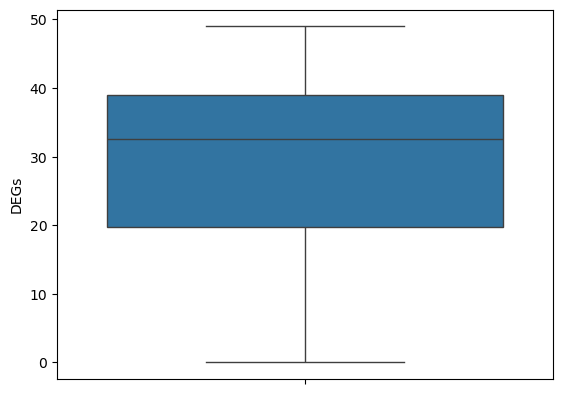

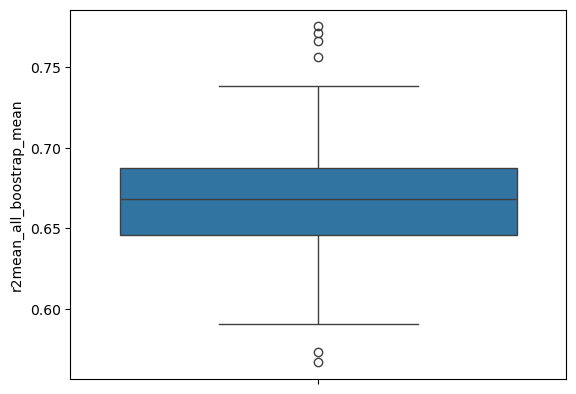

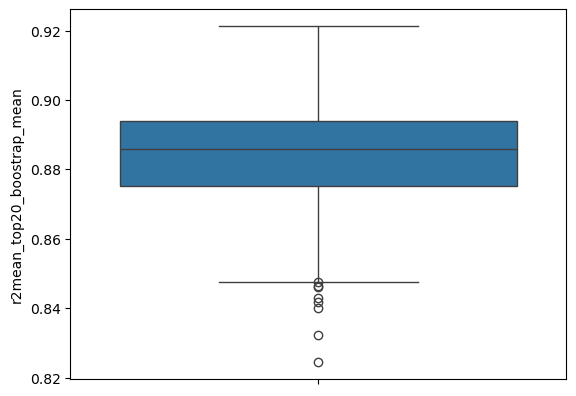

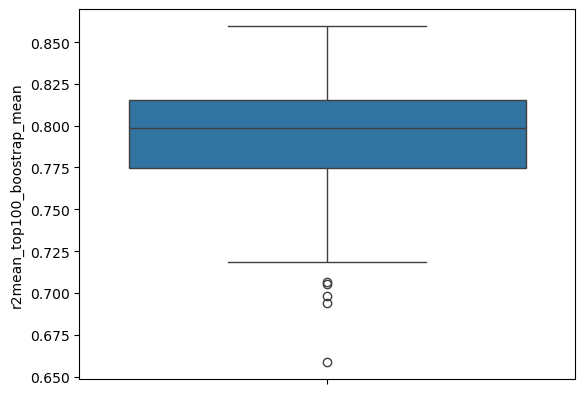

best cell type common {'dosage_0_03_0_1_3_0_10_0_30_0_19193'}
worst cell type common {'dosage_10_0_30_0_19193', 'dosage_0_01_0_03_0_1_1_0_10_0_30_0_19193', 'dosage_0_01_1_0_10_0_30_0_19193'}


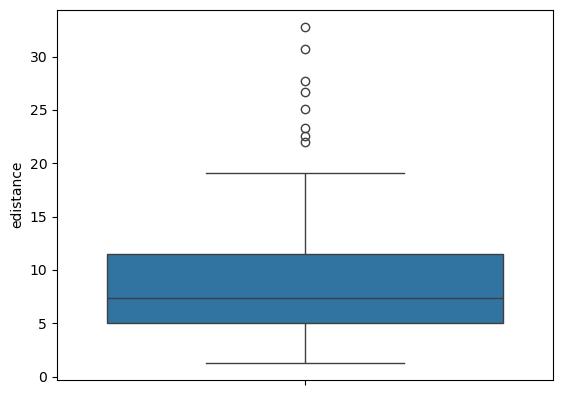

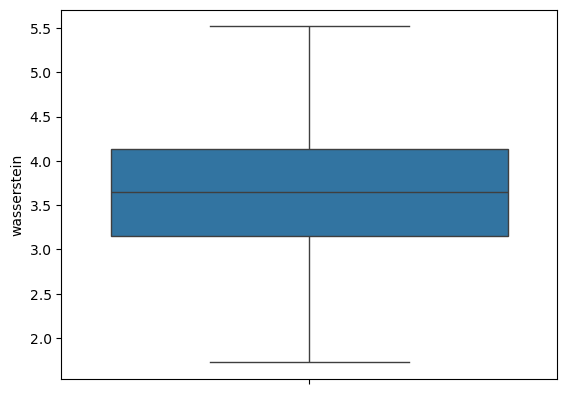

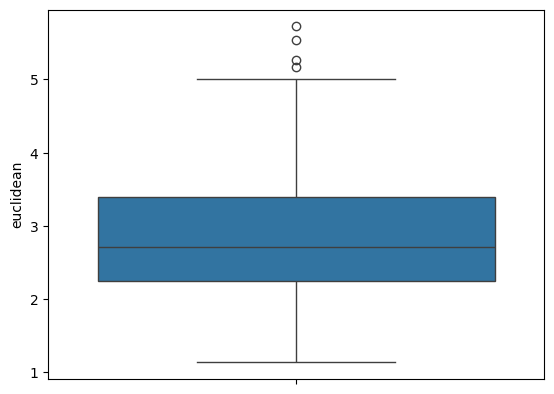

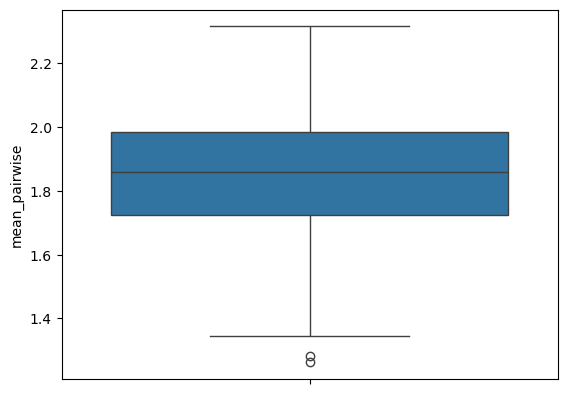

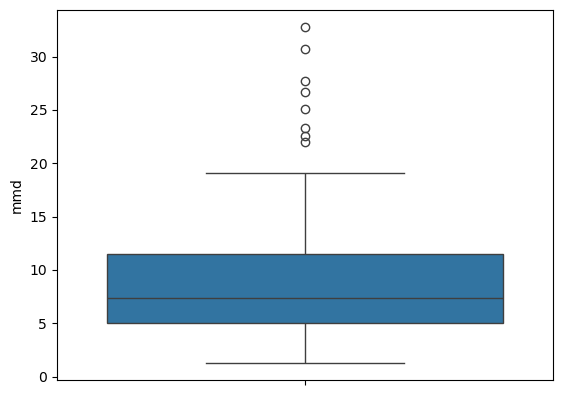

best cell type common {'dosage_0_03_0_3_1_0_10_0_30_0_19193', 'dosage_0_01_1_0_3_0_10_0_30_0_19193', 'dosage_0_03_0_1_3_0_10_0_30_0_19193', 'dosage_0_01_0_03_1_0_3_0_10_0_30_0_19193', 'dosage_1_0_3_0_10_0_30_0_19193'}
worst cell type common {'dosage_10_0_30_0_19193', 'dosage_0_01_0_1_0_3_1_0_3_0_10_0_30_0_19193', 'dosage_0_01_0_03_0_1_1_0_10_0_30_0_19193'}
best for all metrics set common {'dosage_0_03_0_1_3_0_10_0_30_0_19193'}
worst for all metrics set common {'dosage_10_0_30_0_19193', 'dosage_0_01_0_03_0_1_1_0_10_0_30_0_19193'}


In [86]:
compare_combinations(seed=19193, dose=30)

['Hepatocytes - portal']


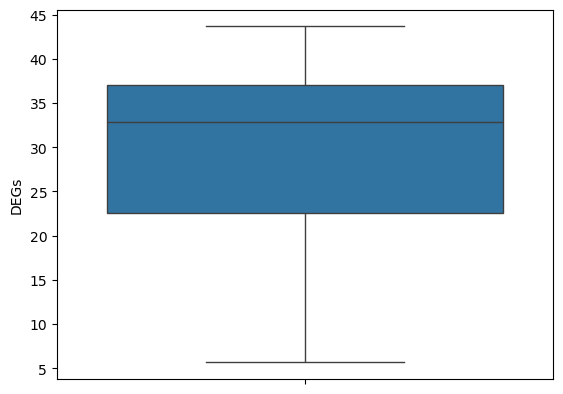

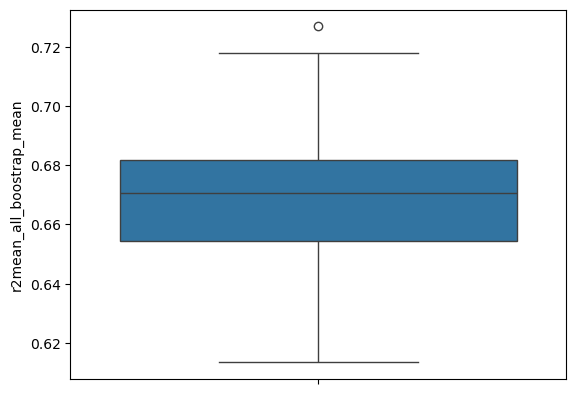

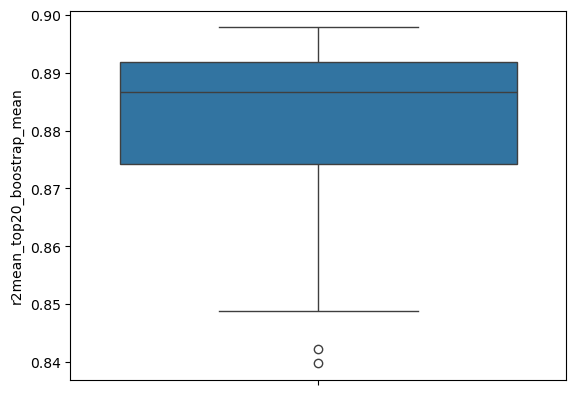

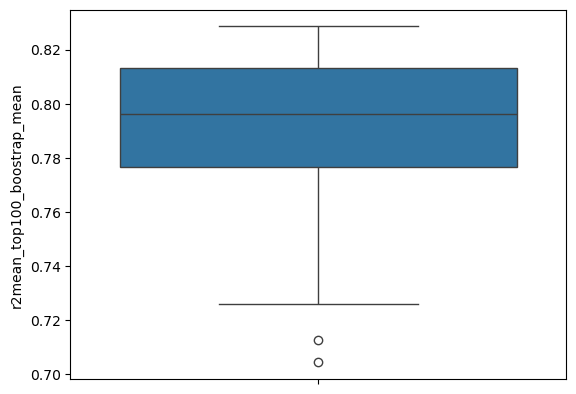

best cell type common {'dosage_0_03_0_3_3_0_30_0'}
worst cell type common {'dosage_0_01_0_1_0_3_1_0_10_0_30_0', 'dosage_0_1_10_0_30_0', 'dosage_0_01_1_0_10_0_30_0', 'dosage_0_01_0_03_10_0_30_0', 'dosage_0_3_10_0_30_0', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_10_0_30_0'}


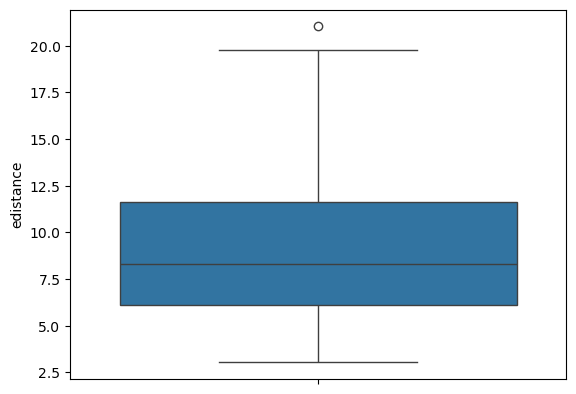

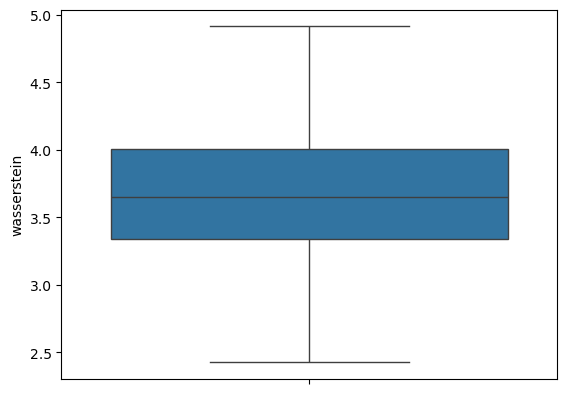

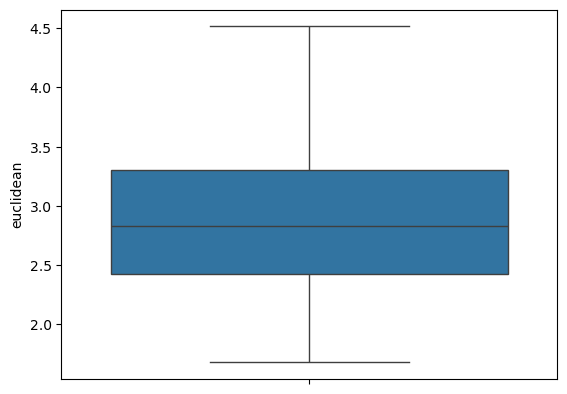

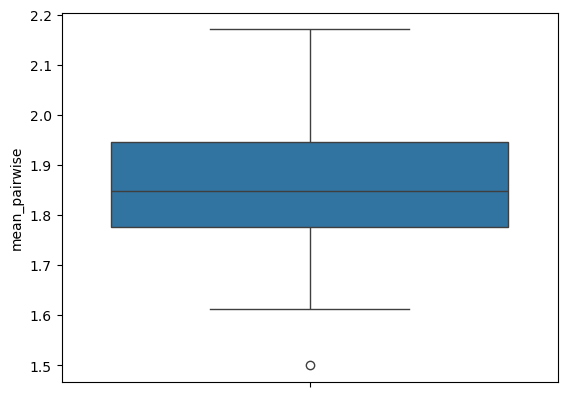

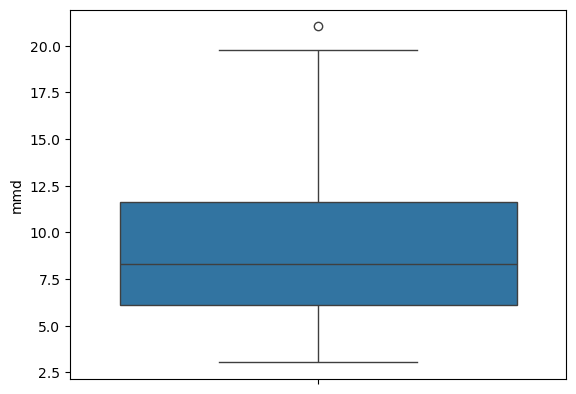

best cell type common {'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_3_0_10_0_30_0', 'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_3_0_30_0', 'dosage_0_01_0_1_0_3_3_0_30_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_1_3_0_30_0', 'dosage_0_03_0_1_1_0_30_0', 'dosage_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_03_0_3_3_0_30_0'}
worst cell type common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_1_0_10_0_30_0', 'dosage_0_01_0_03_10_0_30_0', 'dosage_0_3_10_0_30_0', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_0_03_0_3_3_0_10_0_30_0', 'dosage_10_0_30_0'}
best for all metrics set common {'dosage_0_03_0_3_3_0_30_0'}
worst for all metrics set common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_1_0_10_0_30_0', 'dosage_0_01_0_03_10_0_30_0', 'dosage_0_3_10_0_30_0', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_10_0_30_0'}


({'dosage_0_03_0_3_3_0_30_0'},
 {'dosage_0_01_0_03_0_1_1_0_10_0_30_0',
  'dosage_0_01_0_03_10_0_30_0',
  'dosage_0_01_1_0_10_0_30_0',
  'dosage_0_03_0_1_1_0_10_0_30_0',
  'dosage_0_3_10_0_30_0',
  'dosage_10_0_30_0'})

In [87]:
compare_combinations_with_aggregation(dose=30, best_threshold=15, worst_threshold=10)


In [88]:
best_experiment = 'dosage_0_03_0_3_3_0_30_0'
dataset = agg_dataset[agg_dataset['experiment_name'] == best_experiment]
dataset

experiment_name   dose model  \
781  dosage_0_03_0_3_3_0_30_0   0.03  MTAe   
782  dosage_0_03_0_3_3_0_30_0   0.30  MTAe   
783  dosage_0_03_0_3_3_0_30_0   3.00  MTAe   
784  dosage_0_03_0_3_3_0_30_0  30.00  MTAe   

                                 dataset        cell_type_test       DEGs  \
781  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal   8.333333   
782  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  22.000000   
783  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  43.000000   
784  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  41.333333   

     DEGs_std  r2mean_all_boostrap_mean  r2mean_all_boostrap_mean_std  \
781  1.527525                  0.934048                      0.003496   
782  5.291503                  0.957140                      0.008718   
783  2.645751                  0.944264                      0.003168   
784  3.785939                  0.695878                      0.020644   

     r2mean_top20_boostrap_mean  ...  edistance  edistance_std  wasserstein  \
781                    0.915455  ...   1.483386       0.136264     0.996930   
782                    0.984623  ...   0.825010       0.089116     1.101287   
783                    0.973042  ...   1.159227       0.169924     0.901305   
784                    0.897838  ...   5.083560       1.822413     3.121266   

     wasserstein_std  euclidean  euclidean_std  mean_pairwise  \
781         0.013918   1.217099       0.055548       0.996859   
782         0.059180   0.907435       0.048558       1.038189   
783         0.045692   1.074652       0.080785       0.957793   
784         0.409283   2.232226       0.388701       1.711385   

     mean_pairwise_std       mmd   mmd_std  
781           0.006814  1.483387  0.136263  
782           0.031787  0.825011  0.089116  
783           0.024928  1.159228  0.169925  
784           0.112284  5.083562  1.822414  

[4 rows x 23 columns]

In [89]:
def compare_multi_task_with_other_models(dose_to_test, best_threshold=10, worst_threshold=10):
    best_experiment_set, worst_experiment_set = compare_combinations_with_aggregation(dose=dose_to_test, best_threshold=best_threshold, worst_threshold=worst_threshold)
    dataset = agg_dataset[agg_dataset['experiment_name'] == list(best_experiment_set)[0]]
    dataset["model"] = agg_dataset["model"]
    for metric in METRICS:
        dataset[metric] = agg_dataset[metric]
        dataset["dataset"] = agg_dataset["dataset"]
        dataset["cell_type_test"] = agg_dataset["cell_type_test"]
        dataset["dose"] = agg_dataset["dose"]
    dataset = dataset[dataset["dose"] == dose_to_test]

    other_models = ["ButterflyPipeline", "VidrMultiplePipeline"]
    models_to_compare = METRICS_DF[METRICS_DF["model"].isin(other_models)]
    models_to_compare = models_to_compare[models_to_compare["dose"] == dose_to_test]
    models_to_compare = models_to_compare[
        models_to_compare["dataset"].isin(
            ["NaultSinglePipeline_NaultPipeline", "NaultMultiplePipeline_NaultPipeline"]
        )
    ]
    models_to_compare = models_to_compare[models_to_compare["experiment_name"] == "seed_1"] # this needs to be averaged
    concat_dataset = pd.concat([dataset, models_to_compare])

    plot_2d_metrics_per_dosage(
        dataset=concat_dataset,
        title="",
        cell_type="Hepatocytes - portal",
        models=["MTAe"] + other_models,
        metrics=BASELINE_METRICS,
    )

    plot_2d_metrics_per_dosage(
        dataset=concat_dataset,
        title="",
        cell_type="Hepatocytes - portal",
        models=["MTAe"] + other_models,
        metrics=DISTANCE_METRICS,
    )

['Hepatocytes - portal']


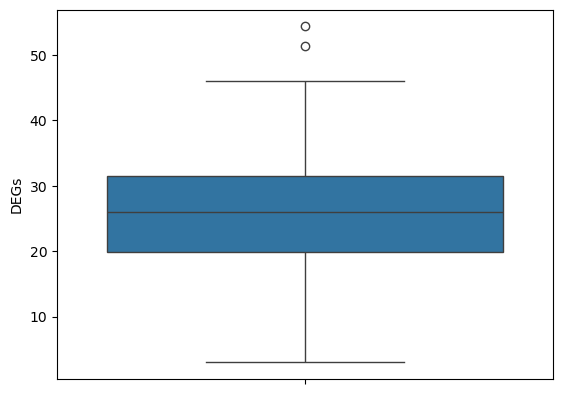

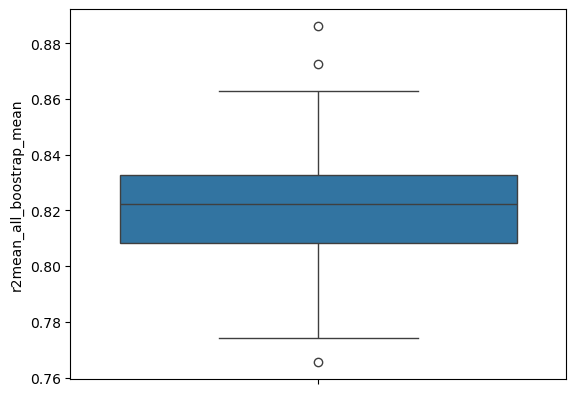

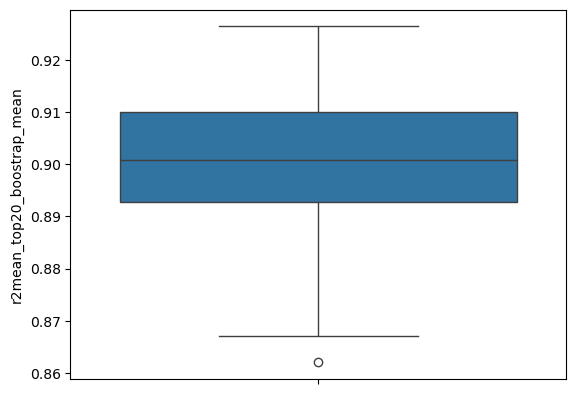

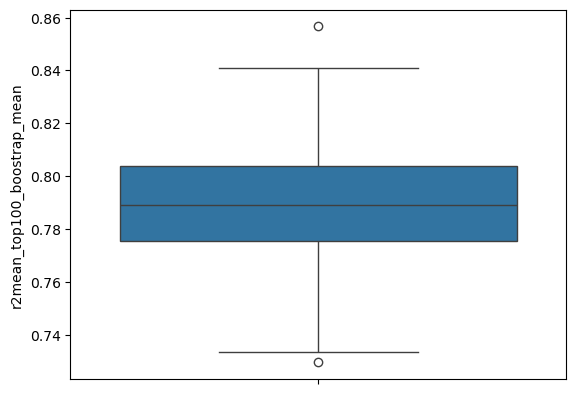

best cell type common {'dosage_0_3_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0_30_0', 'dosage_0_1_10_0_30_0', 'dosage_0_3_1_0_10_0_30_0', 'dosage_1_0_10_0_30_0', 'dosage_10_0_30_0'}
worst cell type common {'dosage_0_03_0_3_10_0', 'dosage_0_03_10_0', 'dosage_0_01_0_1_10_0', 'dosage_0_3_3_0_10_0', 'dosage_0_01_0_03_10_0'}


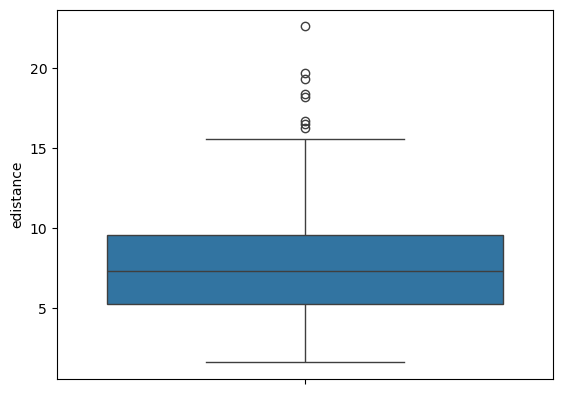

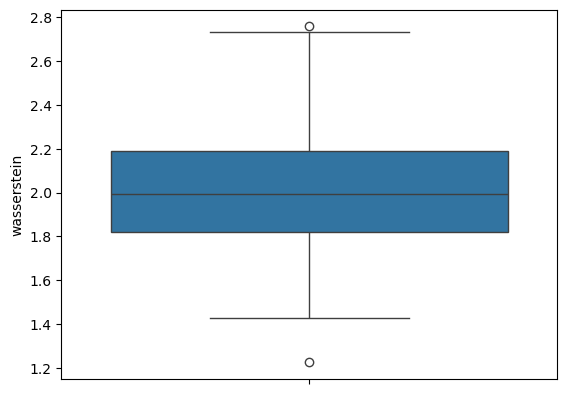

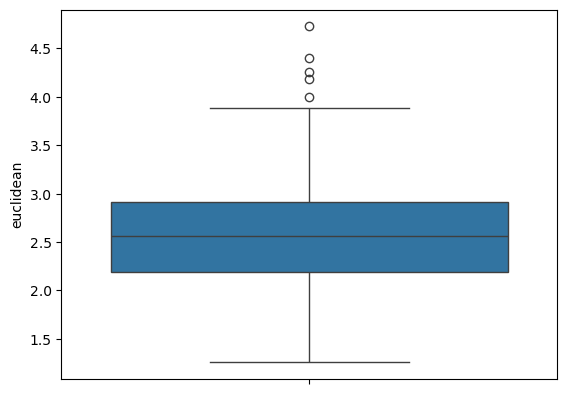

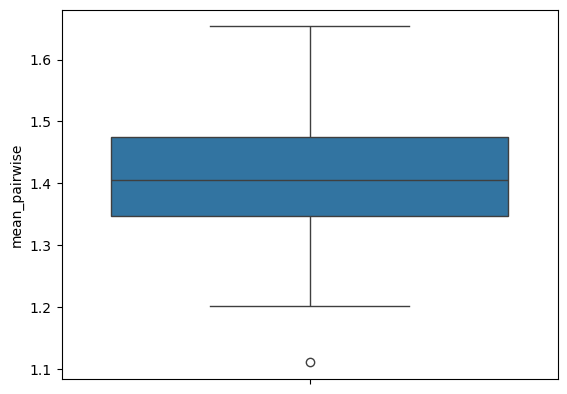

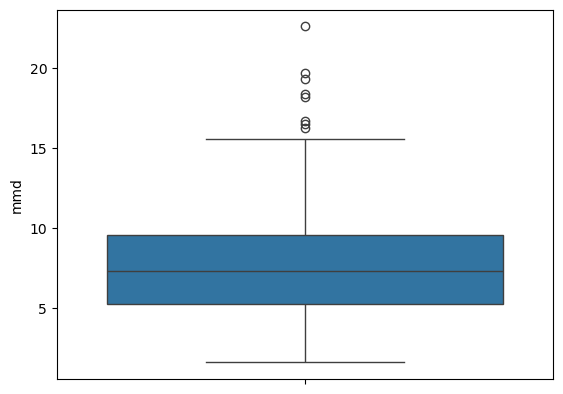

best cell type common {'dosage_0_01_0_03_0_1_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0_30_0', 'dosage_0_1_10_0_30_0', 'dosage_0_01_0_1_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_10_0_30_0', 'dosage_0_03_0_3_3_0_10_0_30_0', 'dosage_10_0_30_0'}
worst cell type common {'dosage_0_1_1_0_3_0_10_0', 'dosage_0_03_0_3_10_0', 'dosage_3_0_10_0', 'dosage_0_3_3_0_10_0', 'dosage_0_01_0_03_10_0', 'dosage_0_01_3_0_10_0'}
best for all metrics set common {'dosage_0_1_10_0_30_0', 'dosage_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0_30_0'}
worst for all metrics set common {'dosage_0_01_0_03_10_0', 'dosage_0_03_0_3_10_0', 'dosage_0_3_3_0_10_0'}


/tmp/ipykernel_1889726/2943155124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1889726/2943155124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1889726/2943155124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

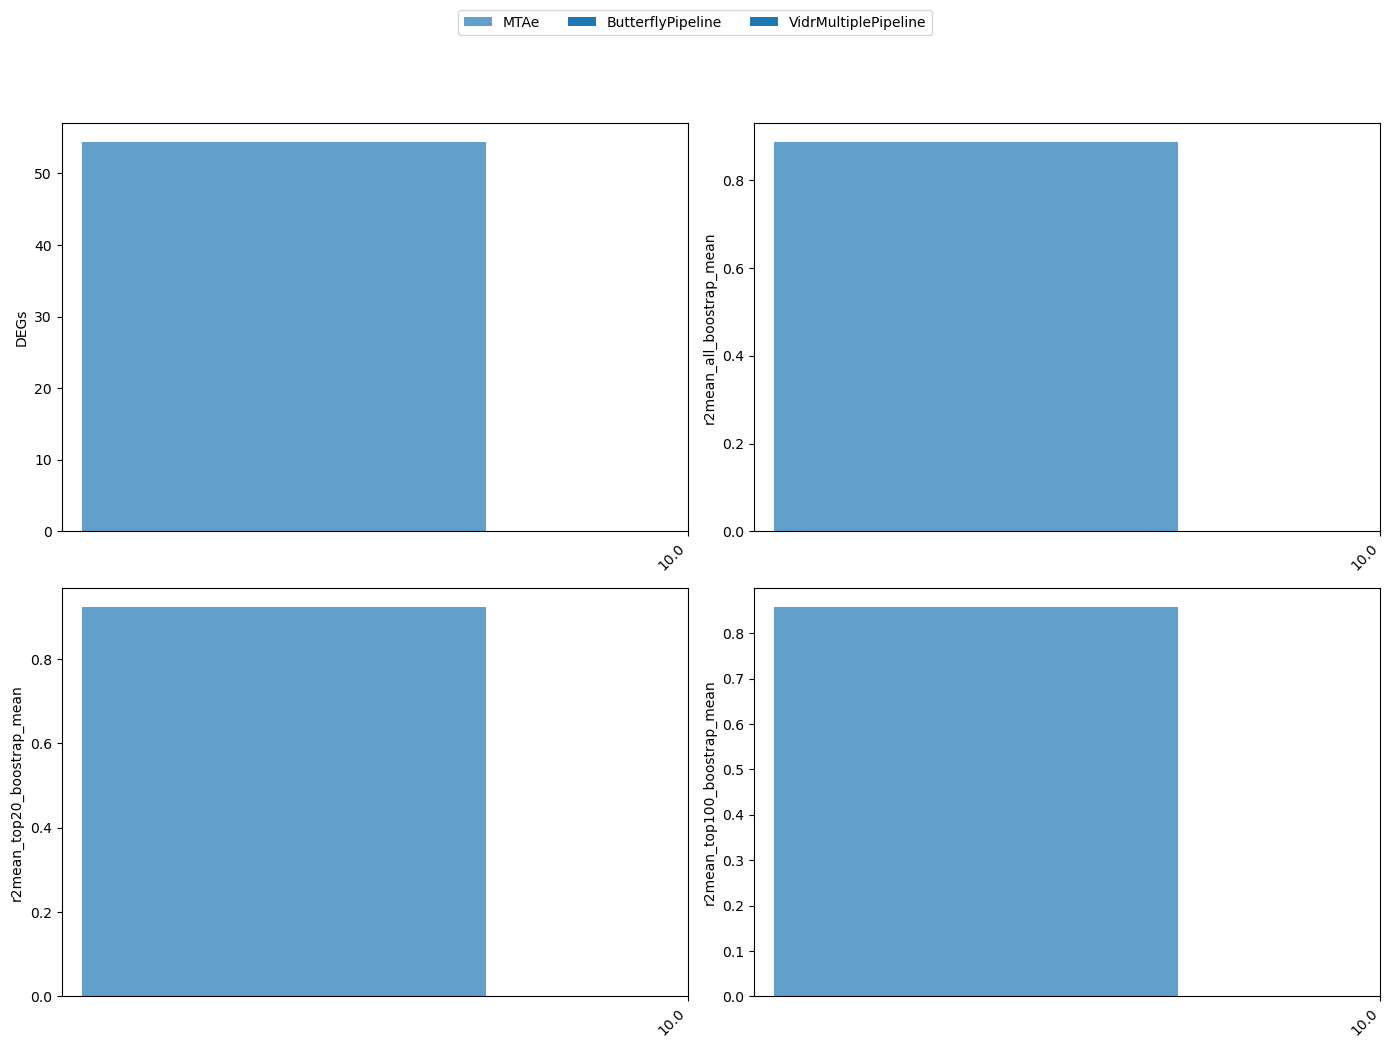

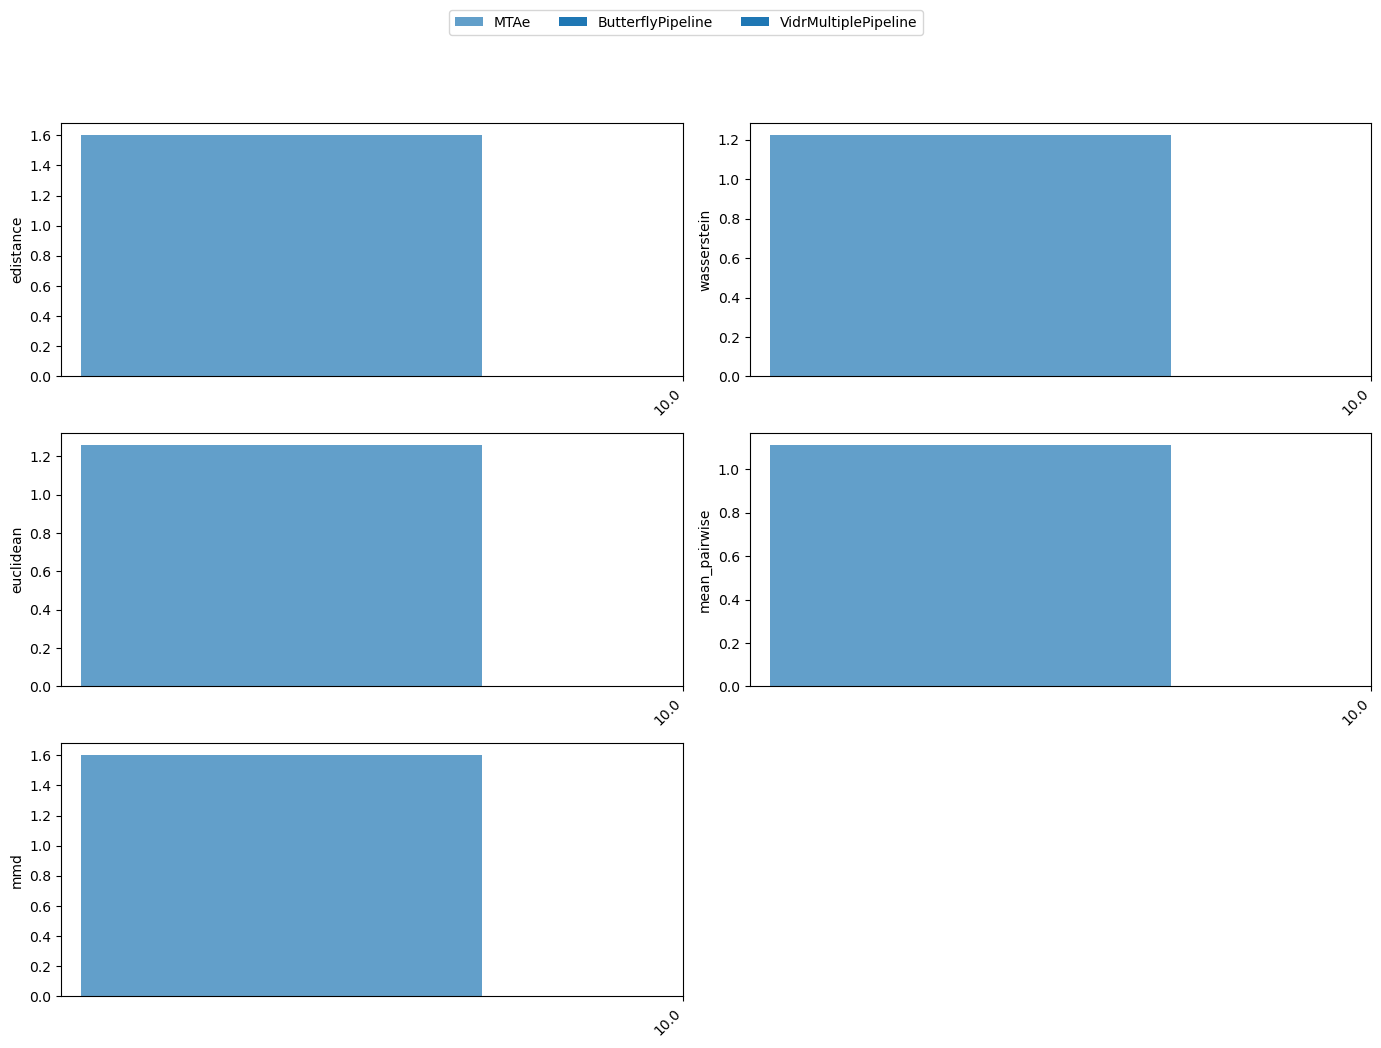

In [90]:
compare_multi_task_with_other_models(dose_to_test=10, best_threshold=10, worst_threshold=10)

['Hepatocytes - portal']


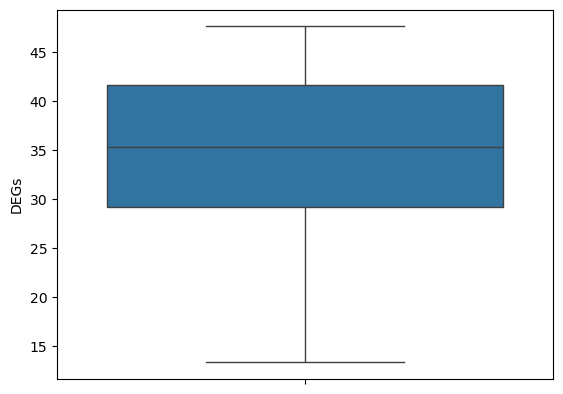

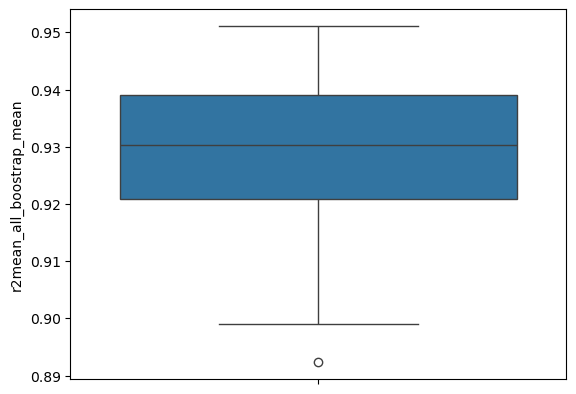

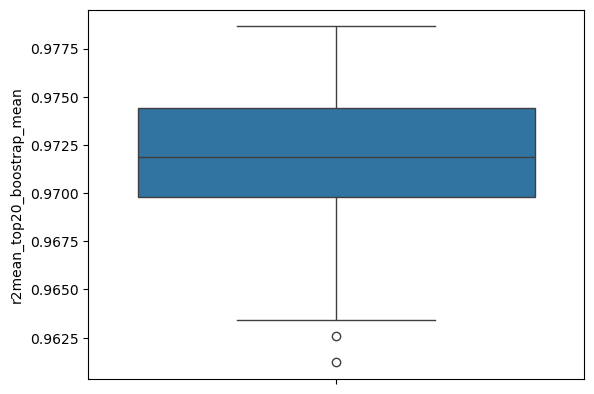

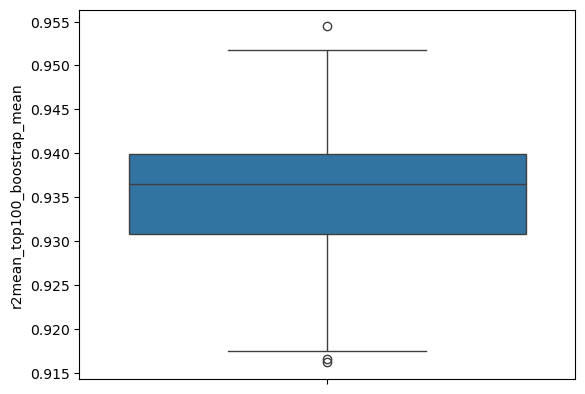

best cell type common {'dosage_0_03_0_3_1_0_3_0_10_0_30_0', 'dosage_0_3_1_0_3_0_30_0', 'dosage_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_03_0_3_1_0_3_0'}
worst cell type common {'dosage_0_01_0_03_3_0_10_0', 'dosage_0_03_0_1_0_3_3_0_10_0', 'dosage_0_03_3_0_10_0', 'dosage_0_03_0_1_3_0_10_0', 'dosage_0_01_3_0_10_0_30_0'}


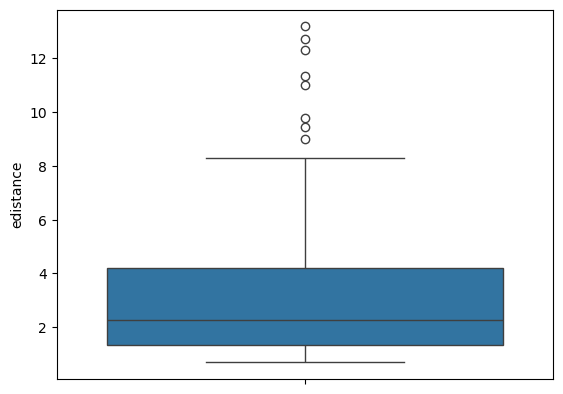

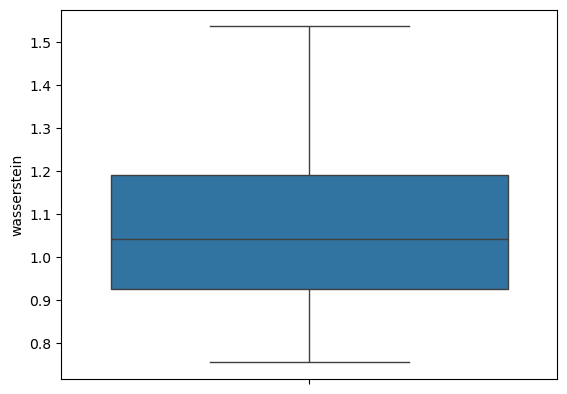

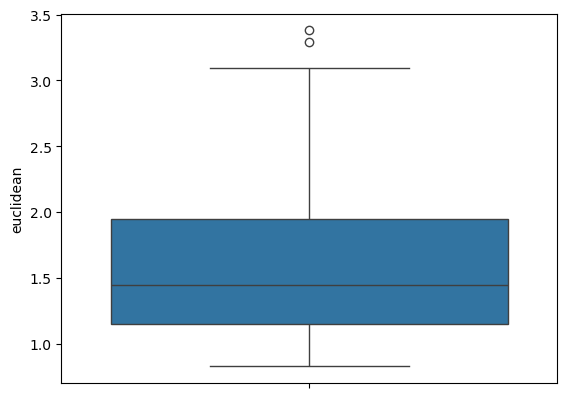

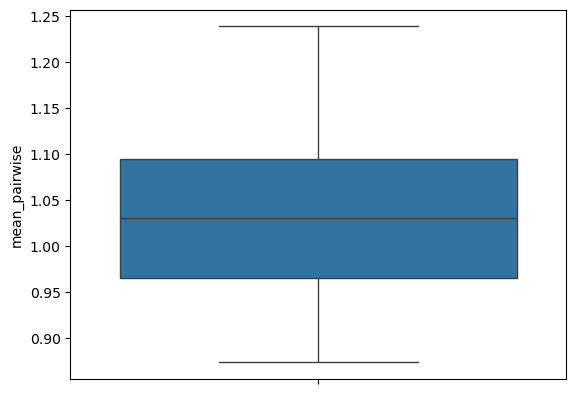

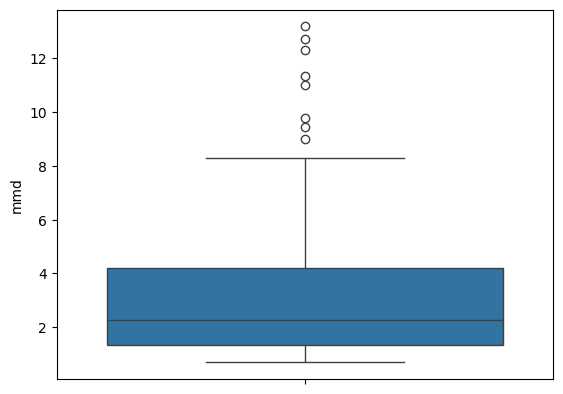

best cell type common {'dosage_0_01_0_03_0_1_3_0_30_0', 'dosage_0_01_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_3_0_30_0', 'dosage_0_1_0_3_3_0_30_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_03_1_0_3_0_30_0', 'dosage_0_3_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0', 'dosage_0_01_0_03_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_3_0', 'dosage_0_01_0_1_0_3_1_0_3_0_30_0', 'dosage_0_1_0_3_1_0_3_0_30_0', 'dosage_0_3_1_0_3_0_30_0', 'dosage_0_01_0_3_1_0_3_0_30_0', 'dosage_0_1_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_03_0_3_3_0_30_0'}
worst cell type common {'dosage_0_01_0_03_1_0_3_0_10_0', 'dosage_0_01_0_1_1_0_3_

/tmp/ipykernel_1889726/2943155124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1889726/2943155124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1889726/2943155124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

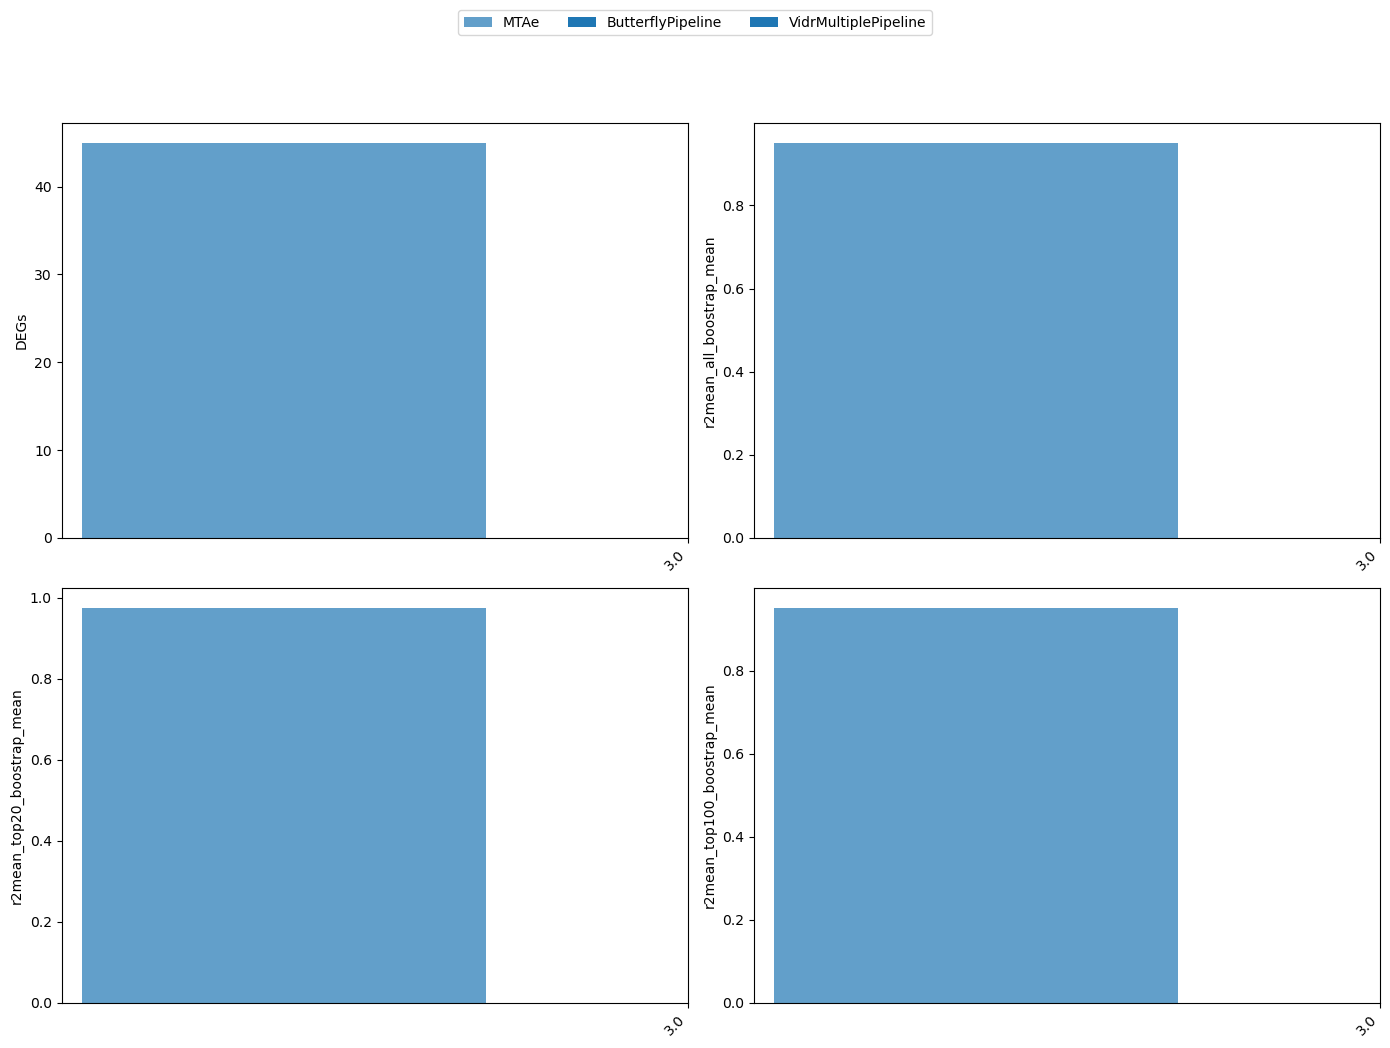

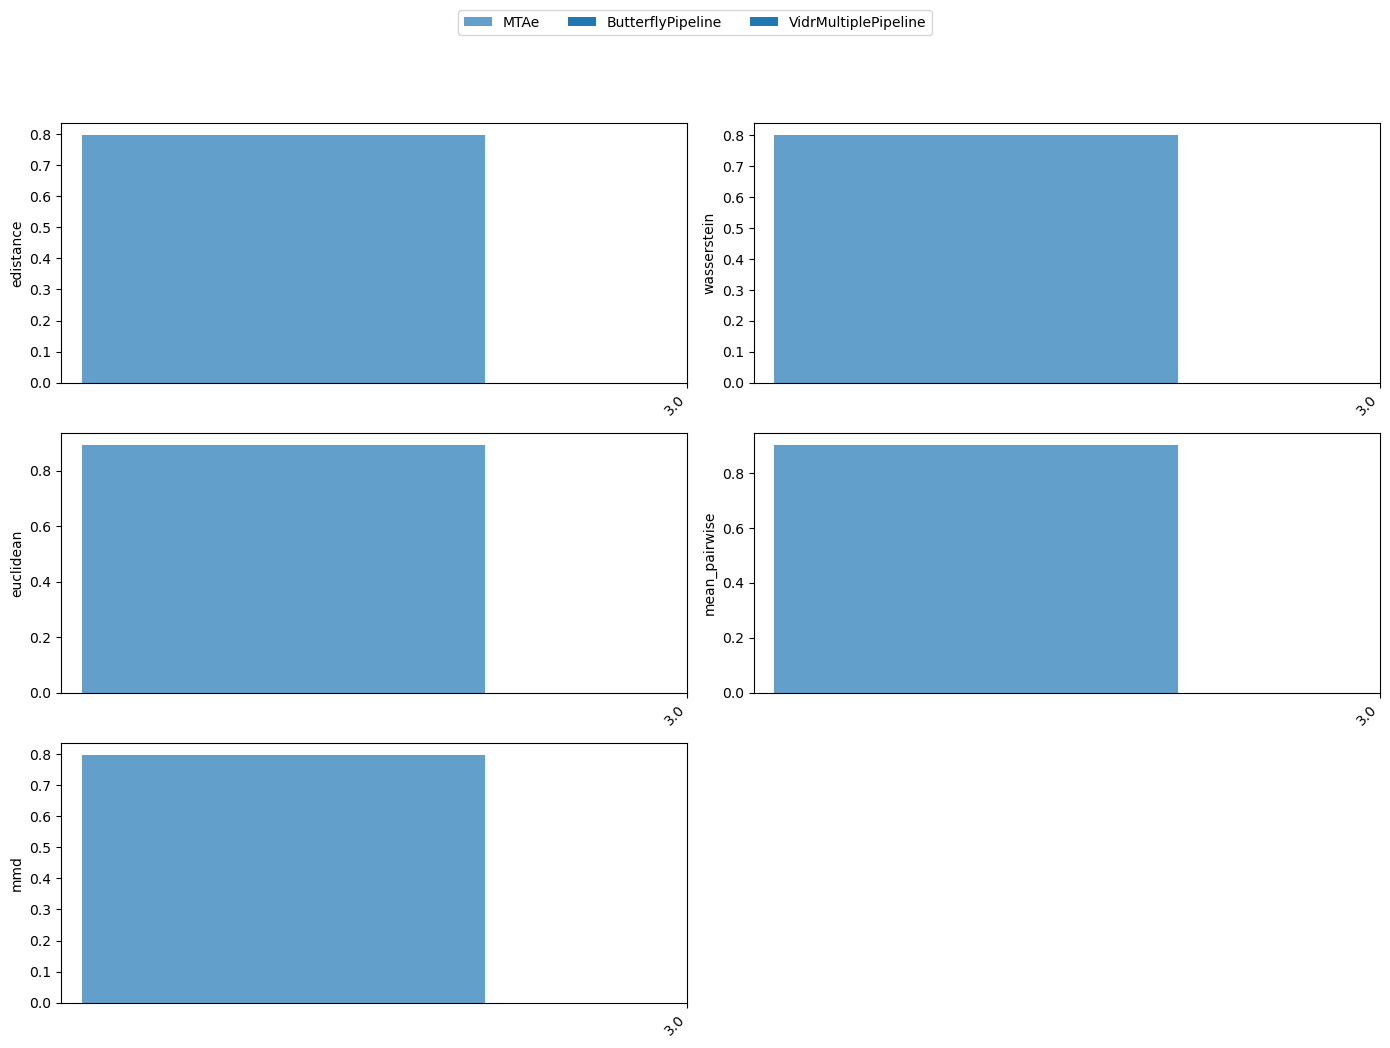

In [91]:
compare_multi_task_with_other_models(dose_to_test=3, best_threshold=30, worst_threshold=30)


['Hepatocytes - portal']


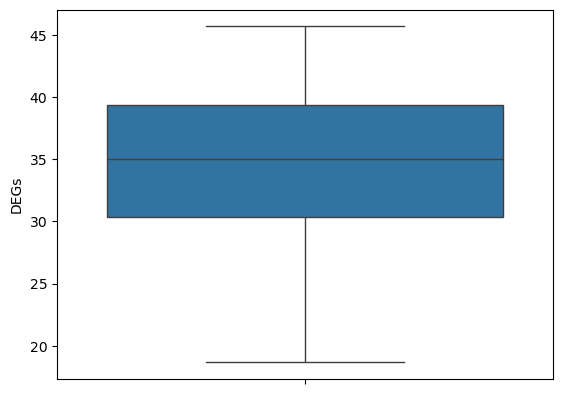

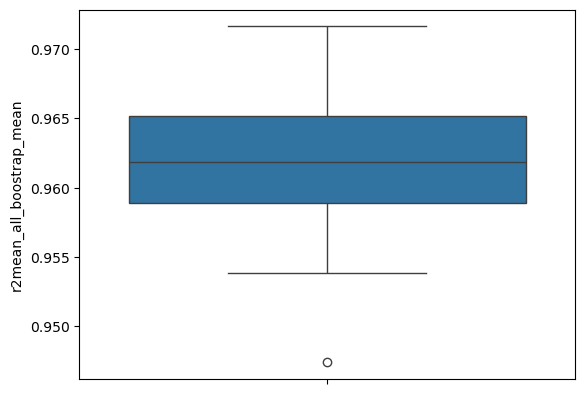

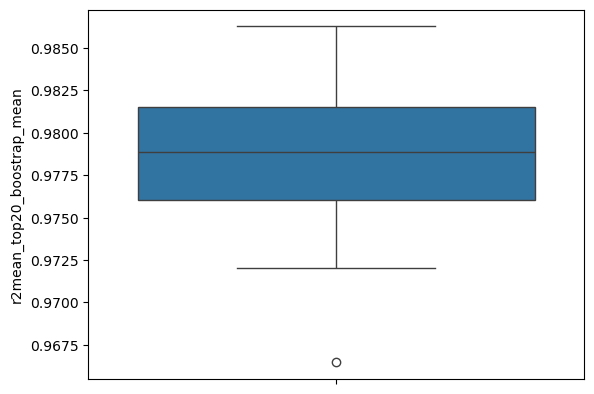

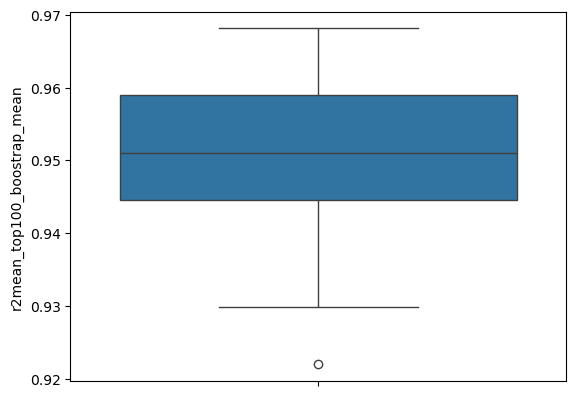

best cell type common {'dosage_0_3_1_0_3_0', 'dosage_1_0_10_0', 'dosage_0_03_0_1_0_3_1_0_3_0', 'dosage_0_3_1_0_10_0_30_0', 'dosage_1_0_3_0_10_0', 'dosage_0_03_1_0_3_0', 'dosage_0_03_0_3_1_0_3_0', 'dosage_0_01_0_1_0_3_1_0_3_0', 'dosage_0_01_0_03_0_3_1_0_10_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_1_1_0_3_0'}
worst cell type common {'dosage_0_01_0_03_1_0_10_0', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_03_0_1_0_3_1_0_30_0', 'dosage_0_03_1_0_30_0'}


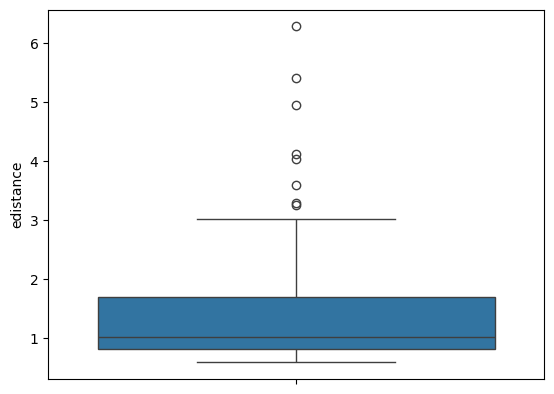

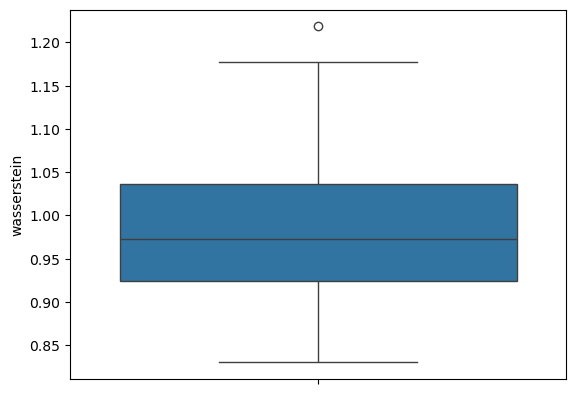

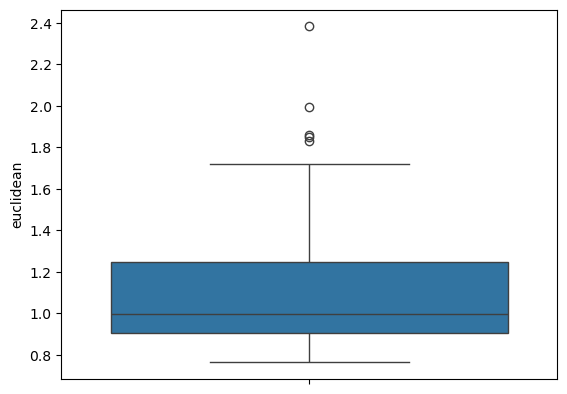

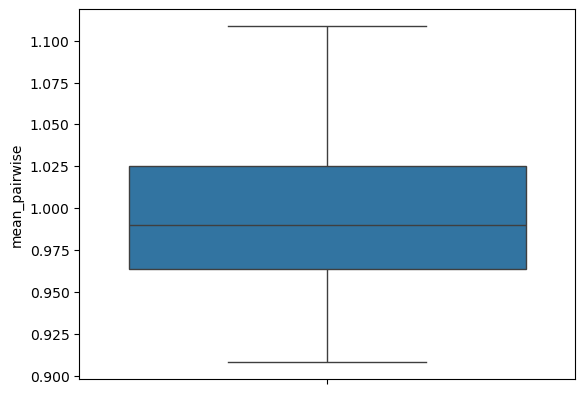

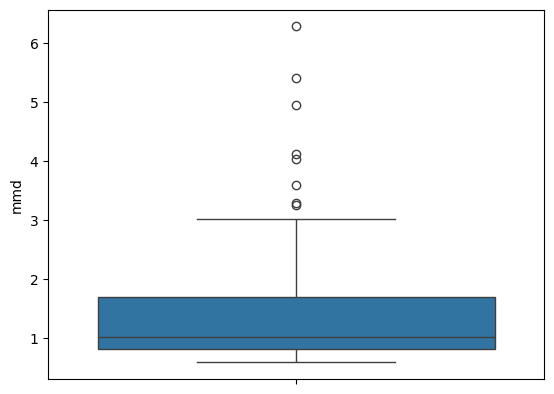

best cell type common {'dosage_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0', 'dosage_0_01_0_1_0_3_1_0', 'dosage_0_01_0_1_1_0_3_0_30_0', 'dosage_0_3_1_0_30_0', 'dosage_0_01_0_03_0_1_1_0_30_0', 'dosage_0_01_0_03_1_0_10_0_30_0', 'dosage_0_03_1_0_30_0', 'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_03_0_1_1_0_30_0', 'dosage_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_10_0', 'dosage_0_03_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_1_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0', 'dosage_0_01_0_03_1_0_3_0_30_0', 'dosage_0_1_0_3_1_0_3_0_10_0', 'dosage_1_0_3_0_10_0', 'dosage_0_1_0_3_1_0_30_0', 'dosage_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_1_0_3_0_30_0', 'dosage_0_03_0_3_1_0_10_0_30_0', 'dosage_0_3_1

/tmp/ipykernel_1889726/2943155124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1889726/2943155124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1889726/2943155124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

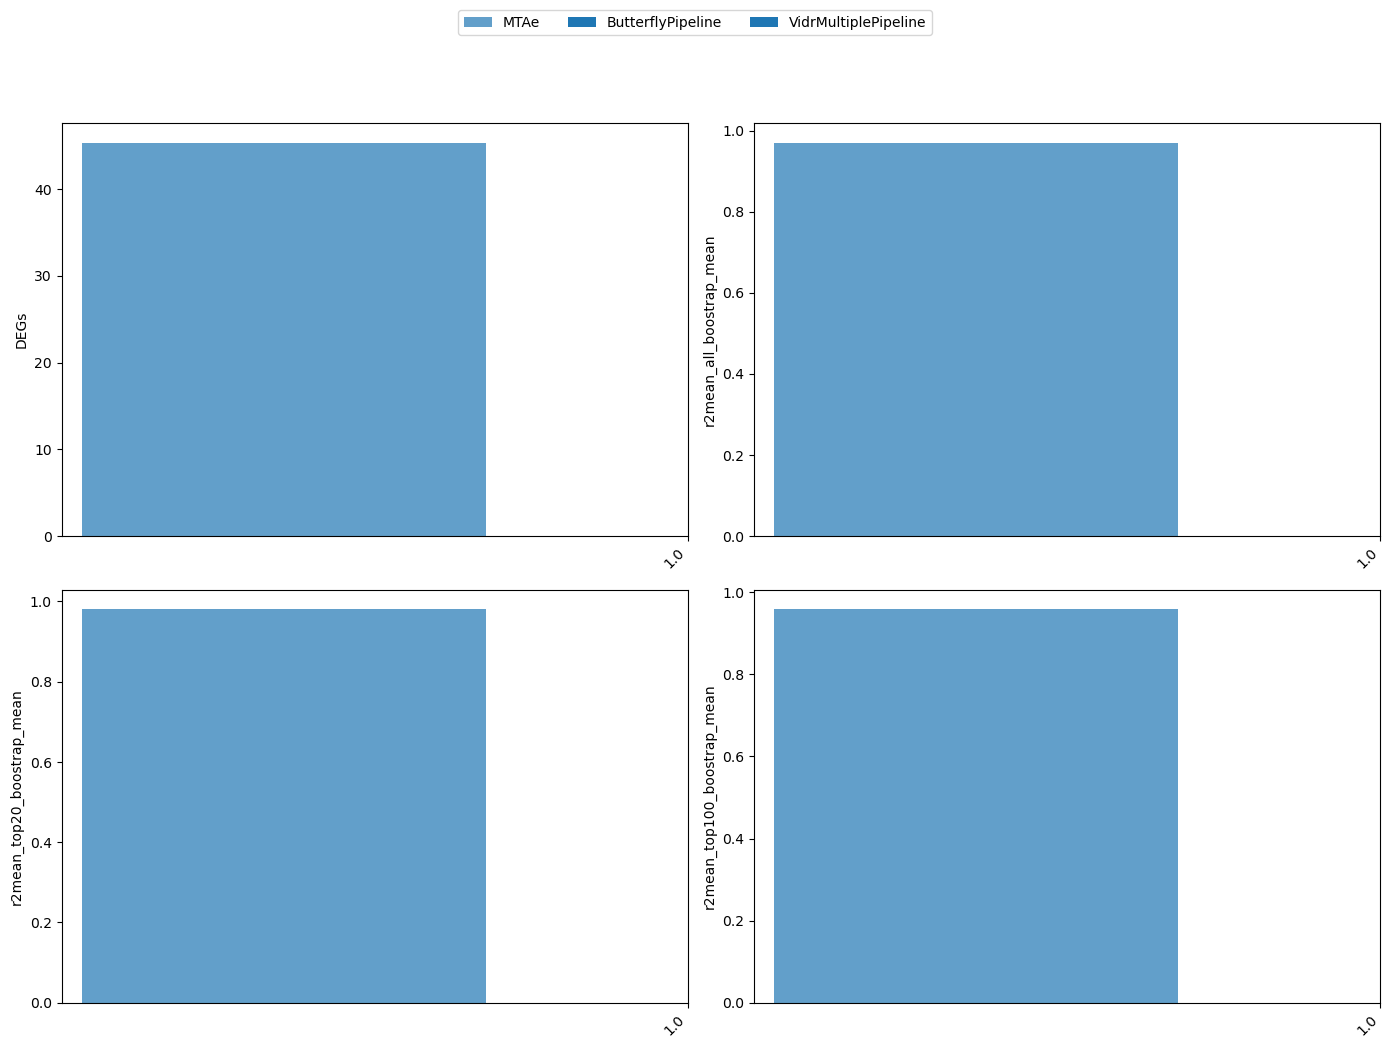

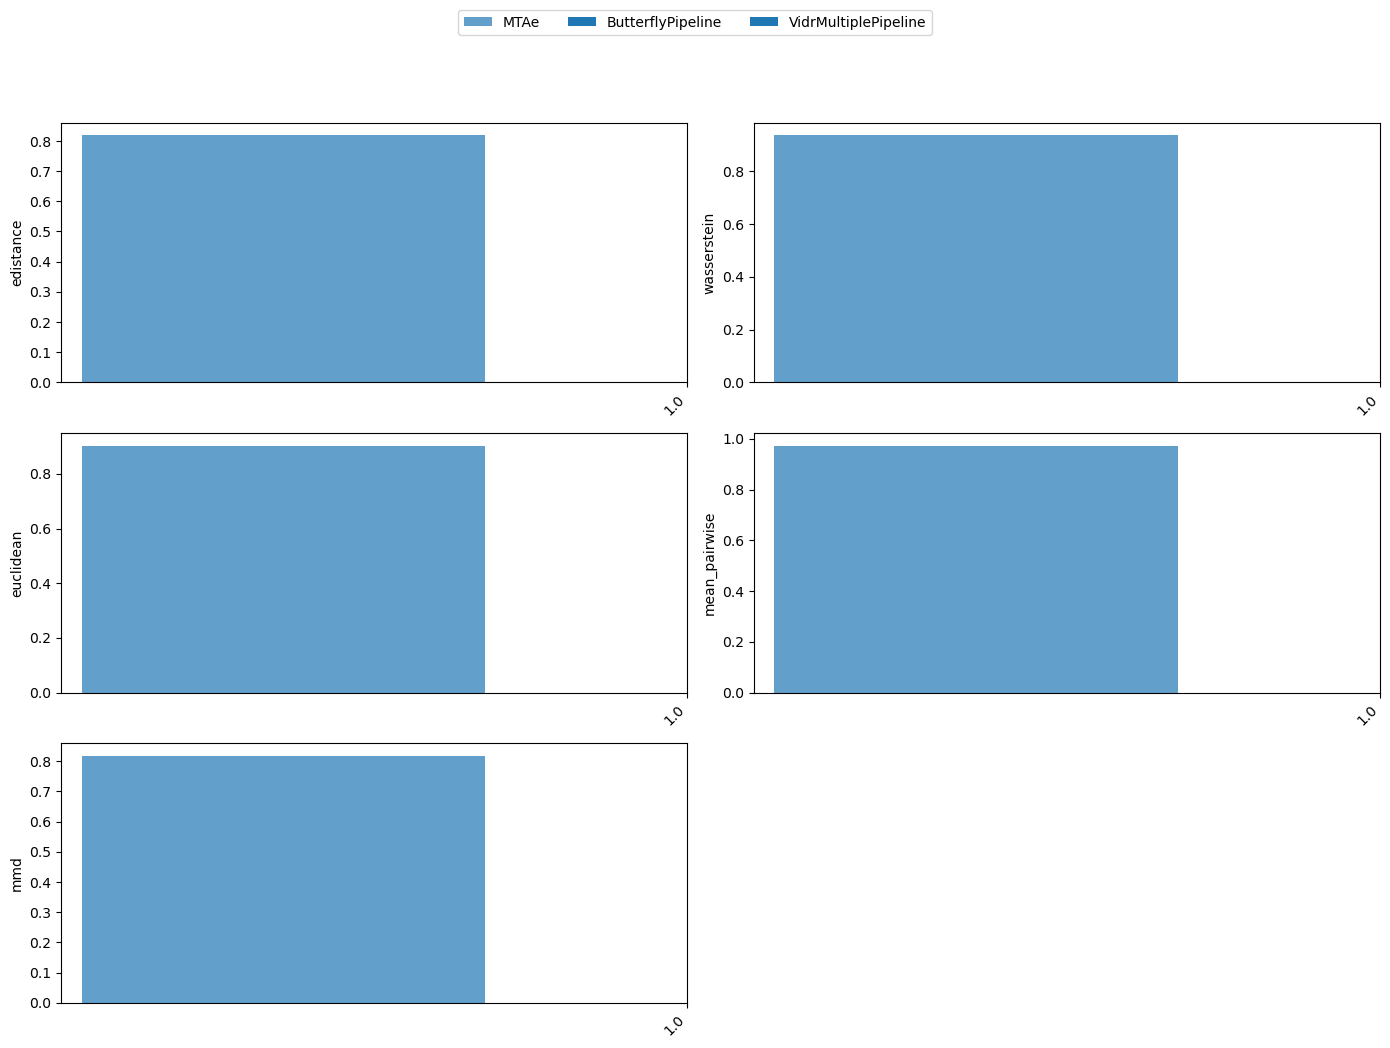

In [92]:
compare_multi_task_with_other_models(dose_to_test=1, best_threshold=50, worst_threshold=30)


['Hepatocytes - portal']


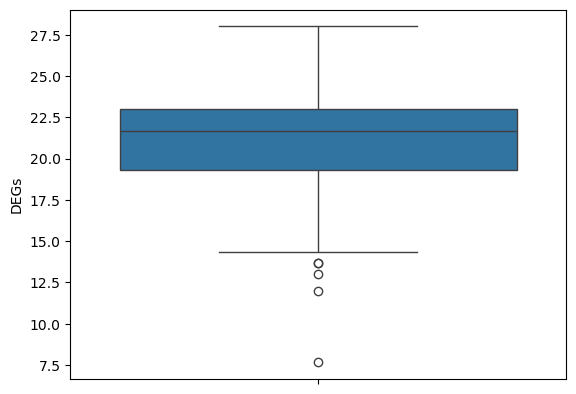

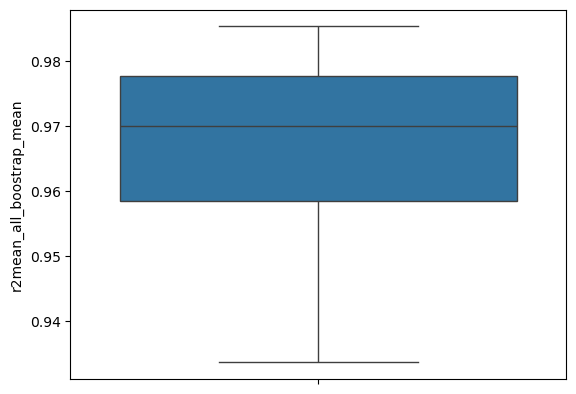

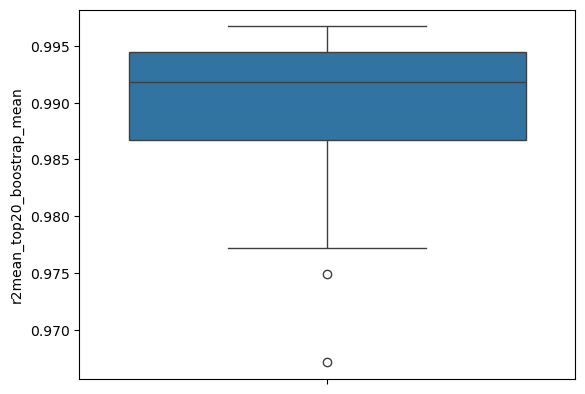

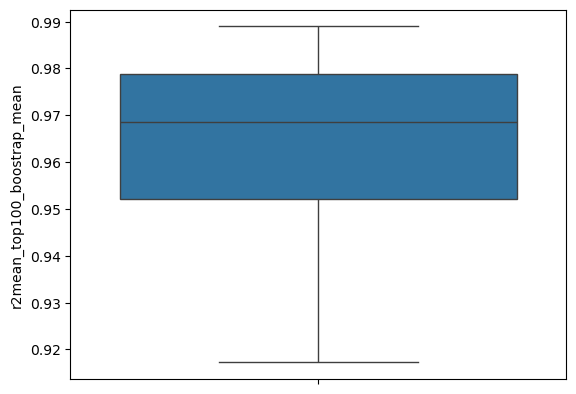

best cell type common {'dosage_0_01_0_1_0_3_1_0_10_0', 'dosage_0_03_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0', 'dosage_0_01_0_03_0_1_0_3_3_0_10_0', 'dosage_0_03_0_3_3_0', 'dosage_0_03_0_1_0_3_3_0_10_0', 'dosage_0_01_0_3_1_0_10_0', 'dosage_0_1_0_3_1_0_10_0', 'dosage_0_3_3_0', 'dosage_0_01_0_03_0_1_0_3_1_0', 'dosage_0_03_0_3_3_0_10_0', 'dosage_0_3_1_0_10_0', 'dosage_0_3_3_0_10_0', 'dosage_0_01_0_03_0_3_1_0_3_0_10_0', 'dosage_0_01_0_03_0_3_1_0_10_0', 'dosage_0_01_0_3_3_0', 'dosage_0_03_0_1_0_3_1_0'}
worst cell type common {'dosage_0_01_0_03_0_1_0_3_30_0', 'dosage_0_01_0_3_10_0_30_0', 'dosage_0_01_0_03_0_3_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_3_1_0_10_0_30_0'}


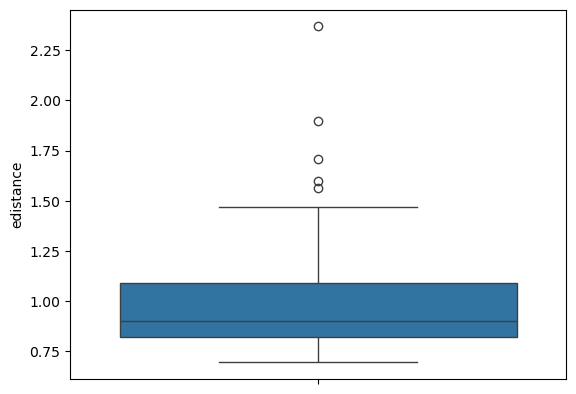

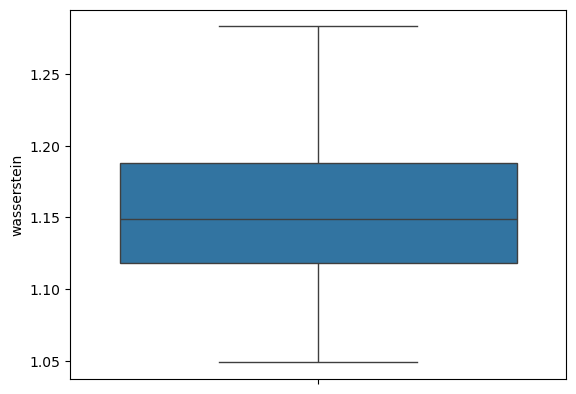

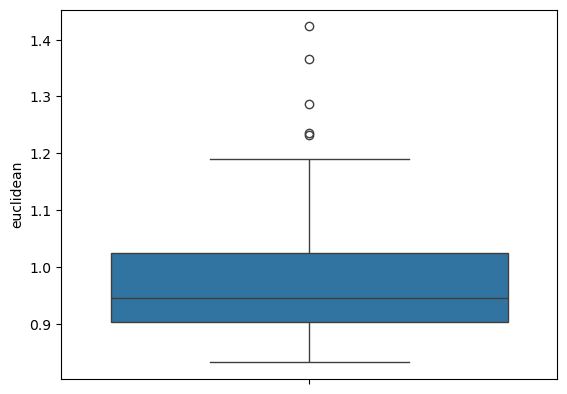

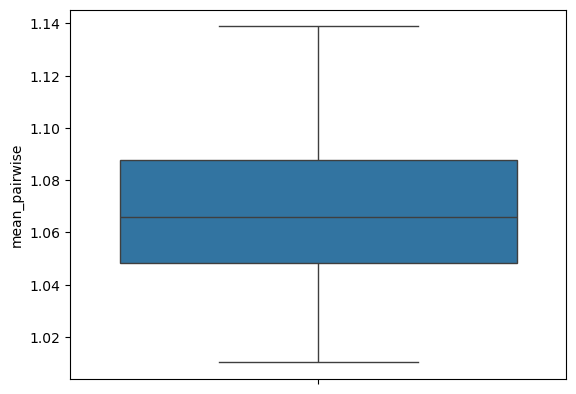

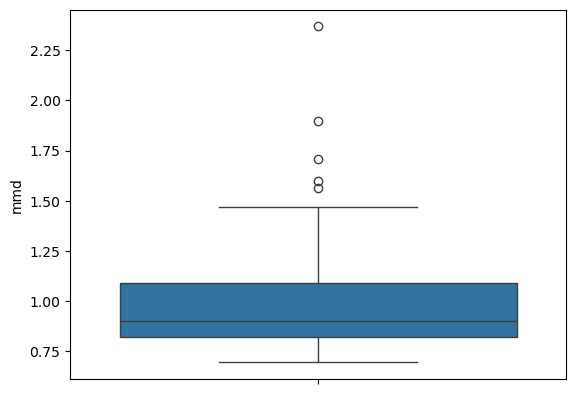

best cell type common {'dosage_0_03_0_1_0_3_3_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_30_0', 'dosage_0_01_0_1_0_3_1_0', 'dosage_0_03_0_1_0_3', 'dosage_0_01_0_3_1_0_30_0', 'dosage_0_01_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_1_0_3_30_0', 'dosage_0_03_0_1_0_3_1_0', 'dosage_0_03_0_1_0_3_1_0_10_0_30_0', 'dosage_0_1_0_3_1_0_10_0_30_0', 'dosage_0_3_1_0_10_0_30_0', 'dosage_0_01_0_1_0_3_3_0_10_0_30_0', 'dosage_0_1_0_3_3_0_30_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_10_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_03_0_3_3_0_10_0_30_0', 'dosage_0_01_0_1_0_3_1_0_10_0_30_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_1_0_3_1_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_0_1_0_3_1_0_3_0_30_0', 'dosage_0_3_1_0_3_0_30_0', 'dosage_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_3_1_0_3_0_30_0', 'dosage_0_01_0_1_0_3_3_0_30_0', 'dosage_0_01_

/tmp/ipykernel_1889726/2943155124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1889726/2943155124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1889726/2943155124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

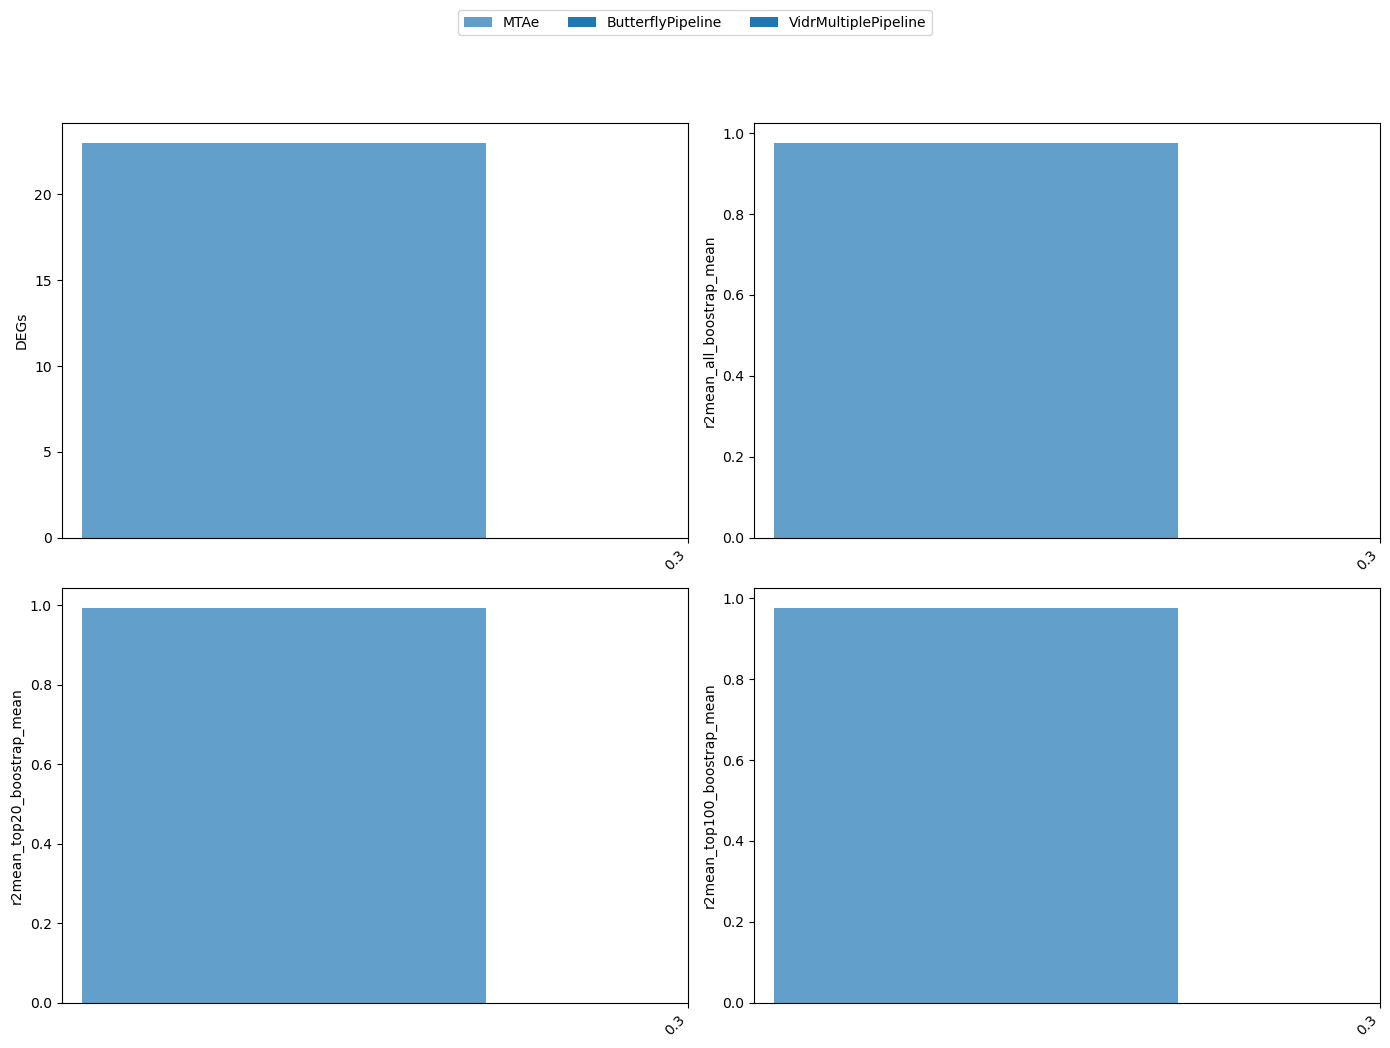

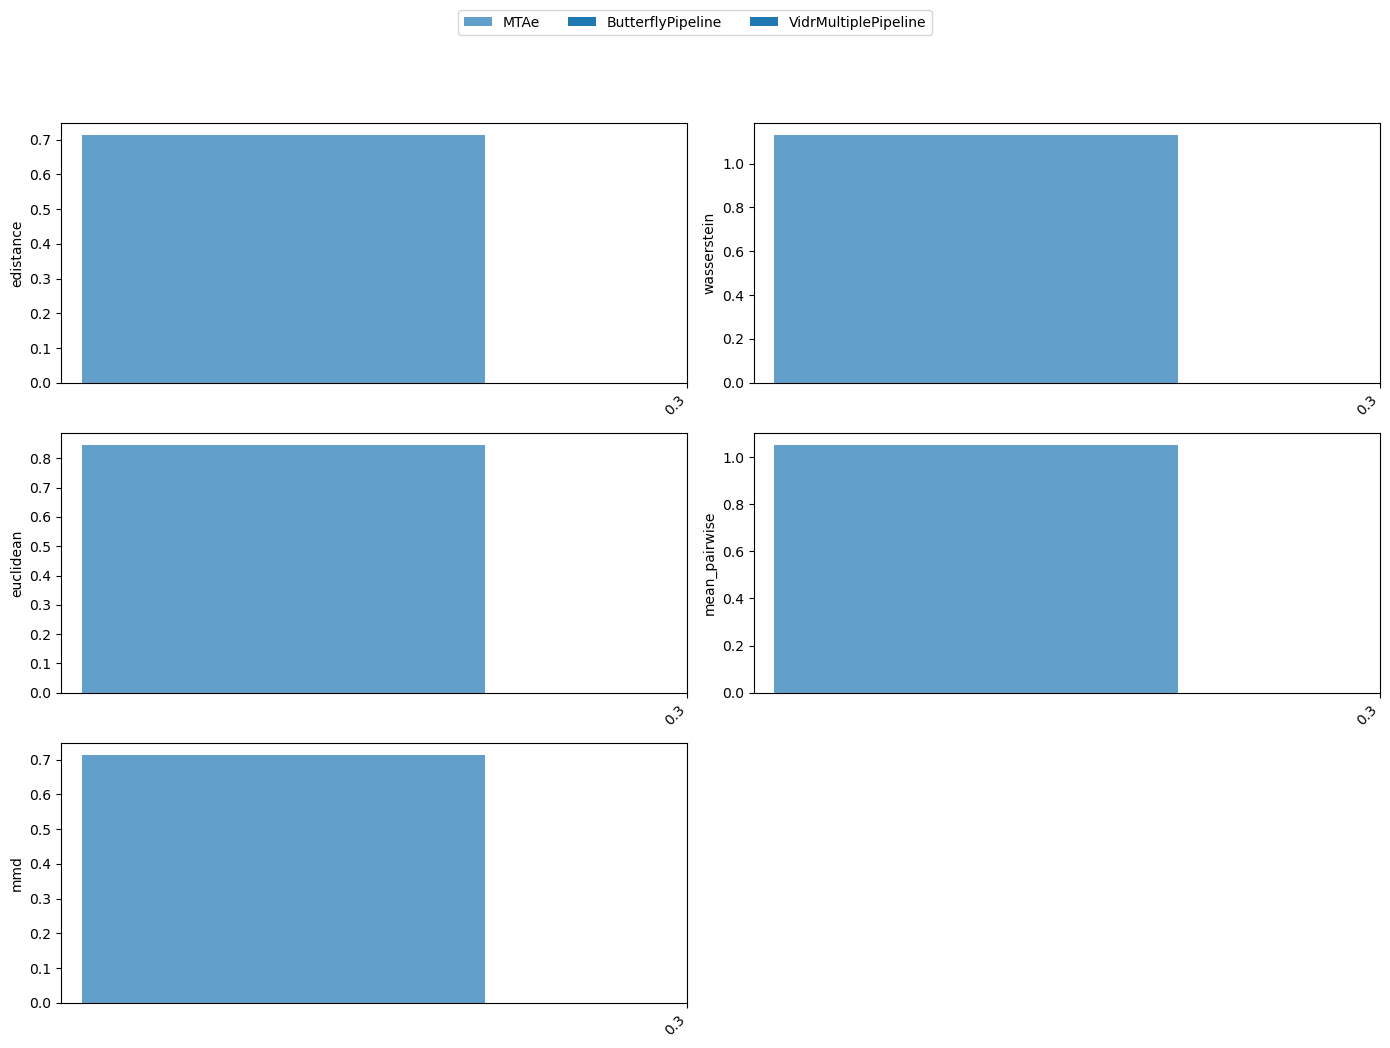

In [93]:
compare_multi_task_with_other_models(dose_to_test=0.3, best_threshold=50, worst_threshold=30)


['Hepatocytes - portal']


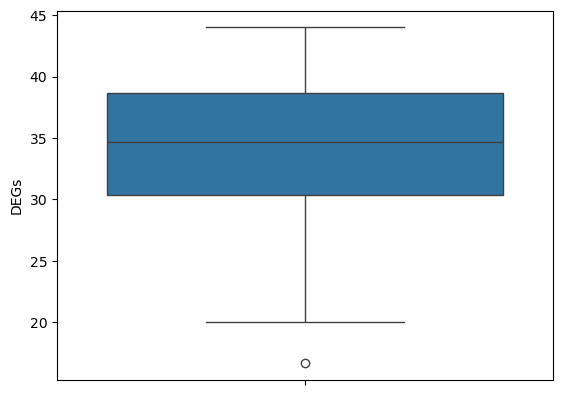

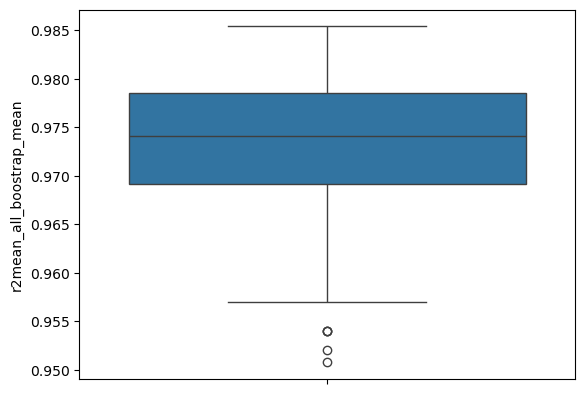

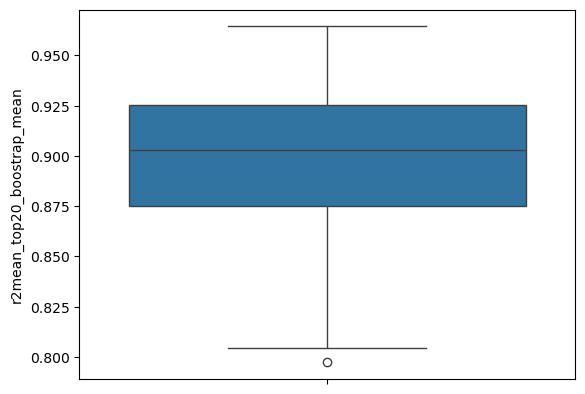

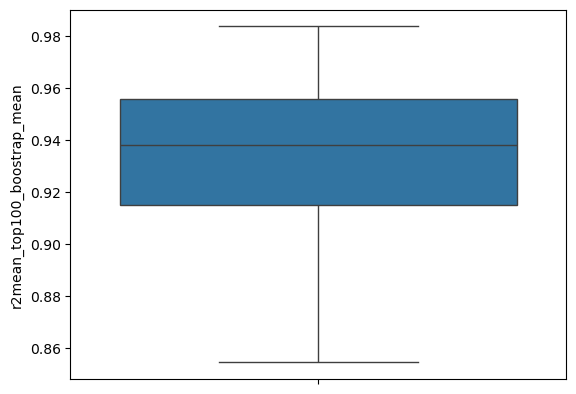

best cell type common {'dosage_0_01_0_1_1_0_3_0_10_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0', 'dosage_0_01_0_1_3_0_10_0', 'dosage_0_01_0_03_0_1_0_3_3_0_10_0', 'dosage_0_1_0_3_10_0_30_0', 'dosage_0_01_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0', 'dosage_0_01_0_03_0_1_0_3_1_0_10_0', 'dosage_0_1', 'dosage_0_01_0_1_1_0_3_0', 'dosage_0_1_1_0_10_0_30_0', 'dosage_0_1_1_0_3_0', 'dosage_0_01_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_1_0_3_1_0_3_0_10_0', 'dosage_0_1_0_3_3_0_10_0_30_0', 'dosage_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_03_0_1_0_3_10_0', 'dosage_0_1_10_0', 'dosage_0_1_0_3_1_0', 'dosage_0_1_0_3_1_0_10_0', 'dosage_0_01_0_1_10_0', 'dosage_0_03_0_1_3_0', 'dosage_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_1_0_3_3_0_10_0', 'dosage_0_1_0_3_10_0'}
worst cell type common {'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_1_0_3_30_0', 'dosage_0_03_0_1_1_0_30_0', 'dosage_0_1_0_3_1_0_30_0', 'dosage_0_1_3_0_10_0_30_0', 'dosage_0_03_0

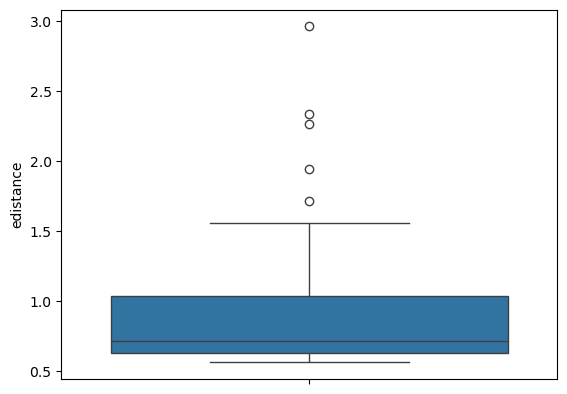

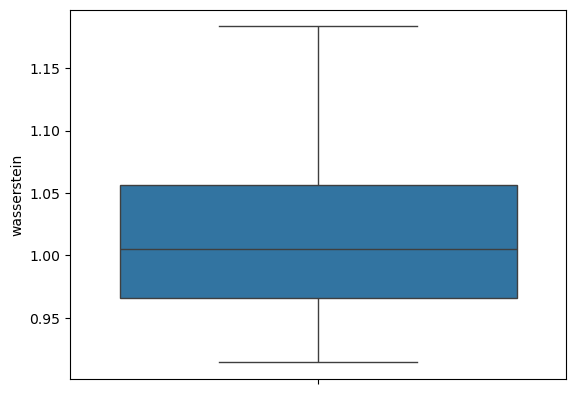

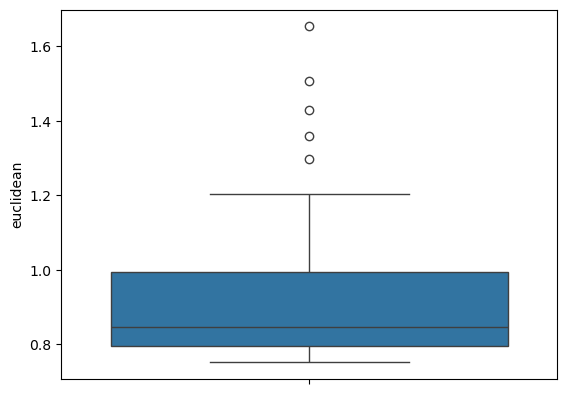

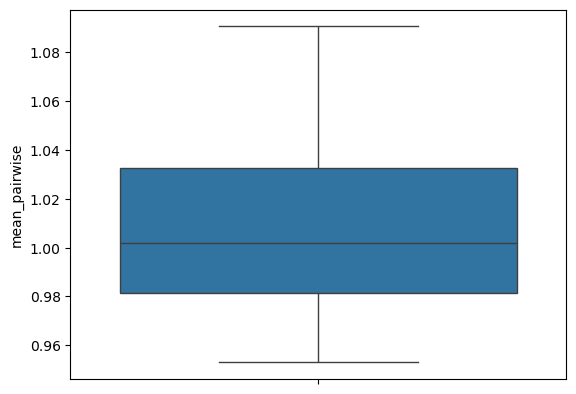

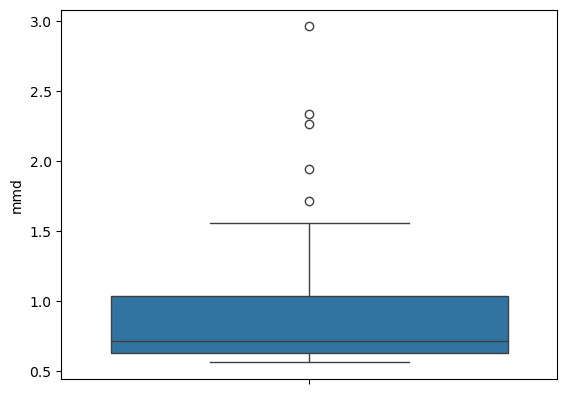

best cell type common {'dosage_0_1_1_0_30_0', 'dosage_0_01_0_1_3_0_30_0', 'dosage_0_01_0_1', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_1_30_0', 'dosage_0_01_0_1_0_3_1_0', 'dosage_0_1_0_3_30_0', 'dosage_0_01_0_03_0_1_3_0_30_0', 'dosage_0_01_0_1_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_10_0_30_0', 'dosage_0_03_0_1_0_3', 'dosage_0_01_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_30_0', 'dosage_0_01_0_03_0_1_1_0_30_0', 'dosage_0_01_0_1_0_3_30_0', 'dosage_0_03_0_1_0_3_1_0', 'dosage_0_03_0_1_0_3_10_0_30_0', 'dosage_0_03_0_1_0_3_1_0_10_0_30_0', 'dosage_0_03_0_1_0_3_30_0', 'dosage_0_03_0_1_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_0_1_0_3', 'dosage_0_01_0_1_1_0', 'dosage_0_03_0_1_0_3_1_0_3_0', 'dosage_0_1_0_3_3_0_30_0', 'dosage_0_03_0_1_1_0_30_0', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0', 'dosage_0_03_0_1_10_0', 'dosage_0_01_0_03_0_1_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0'

/tmp/ipykernel_1889726/2943155124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1889726/2943155124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1889726/2943155124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

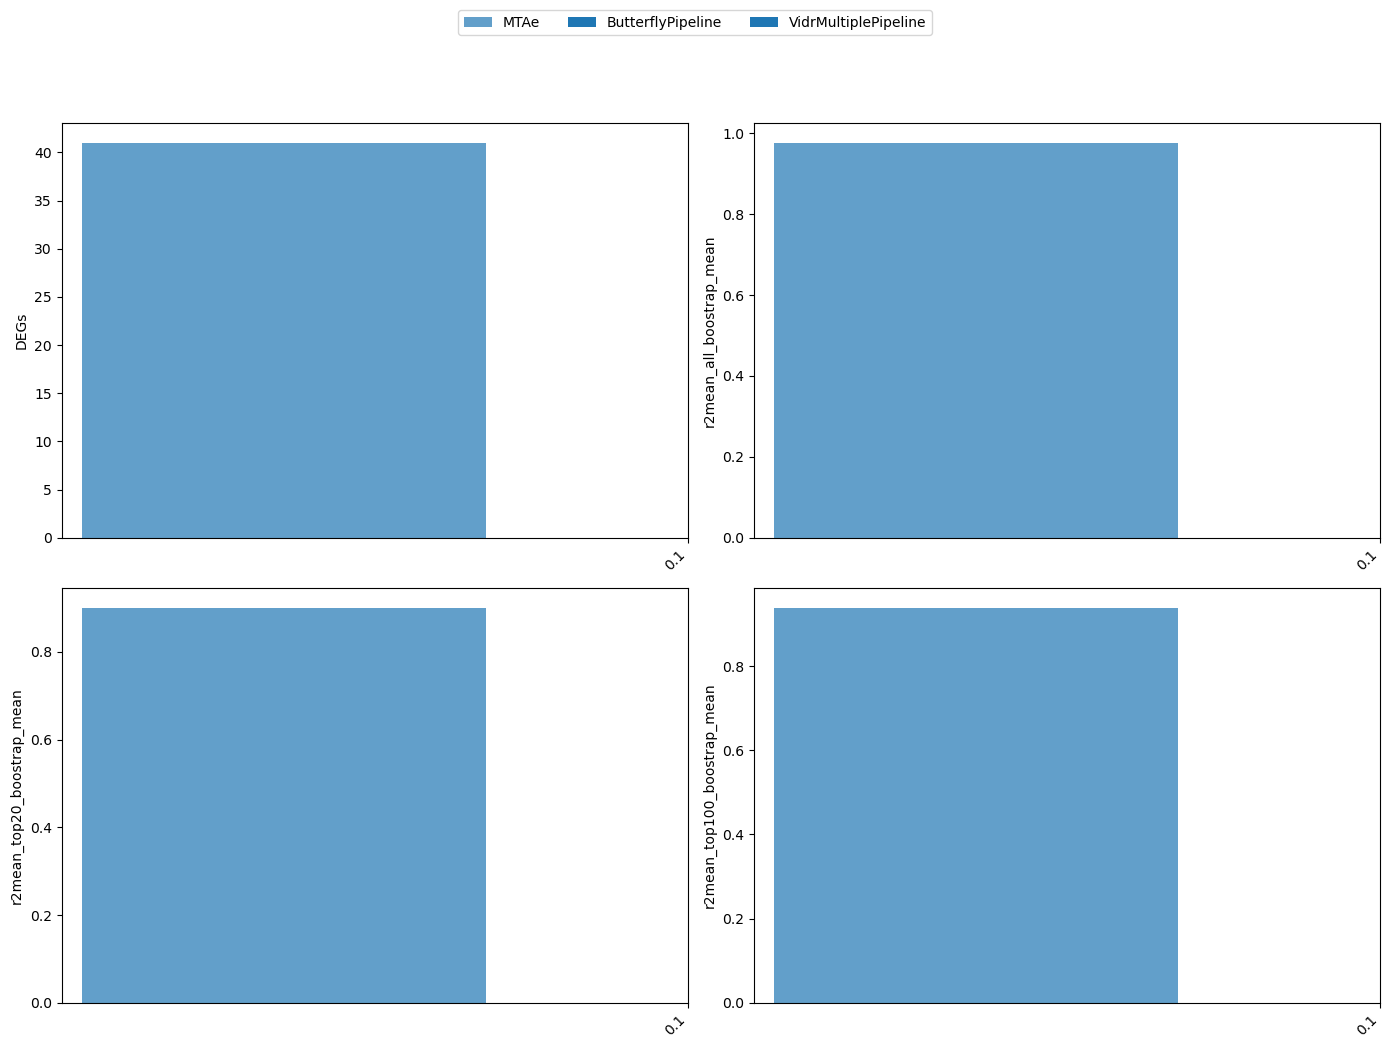

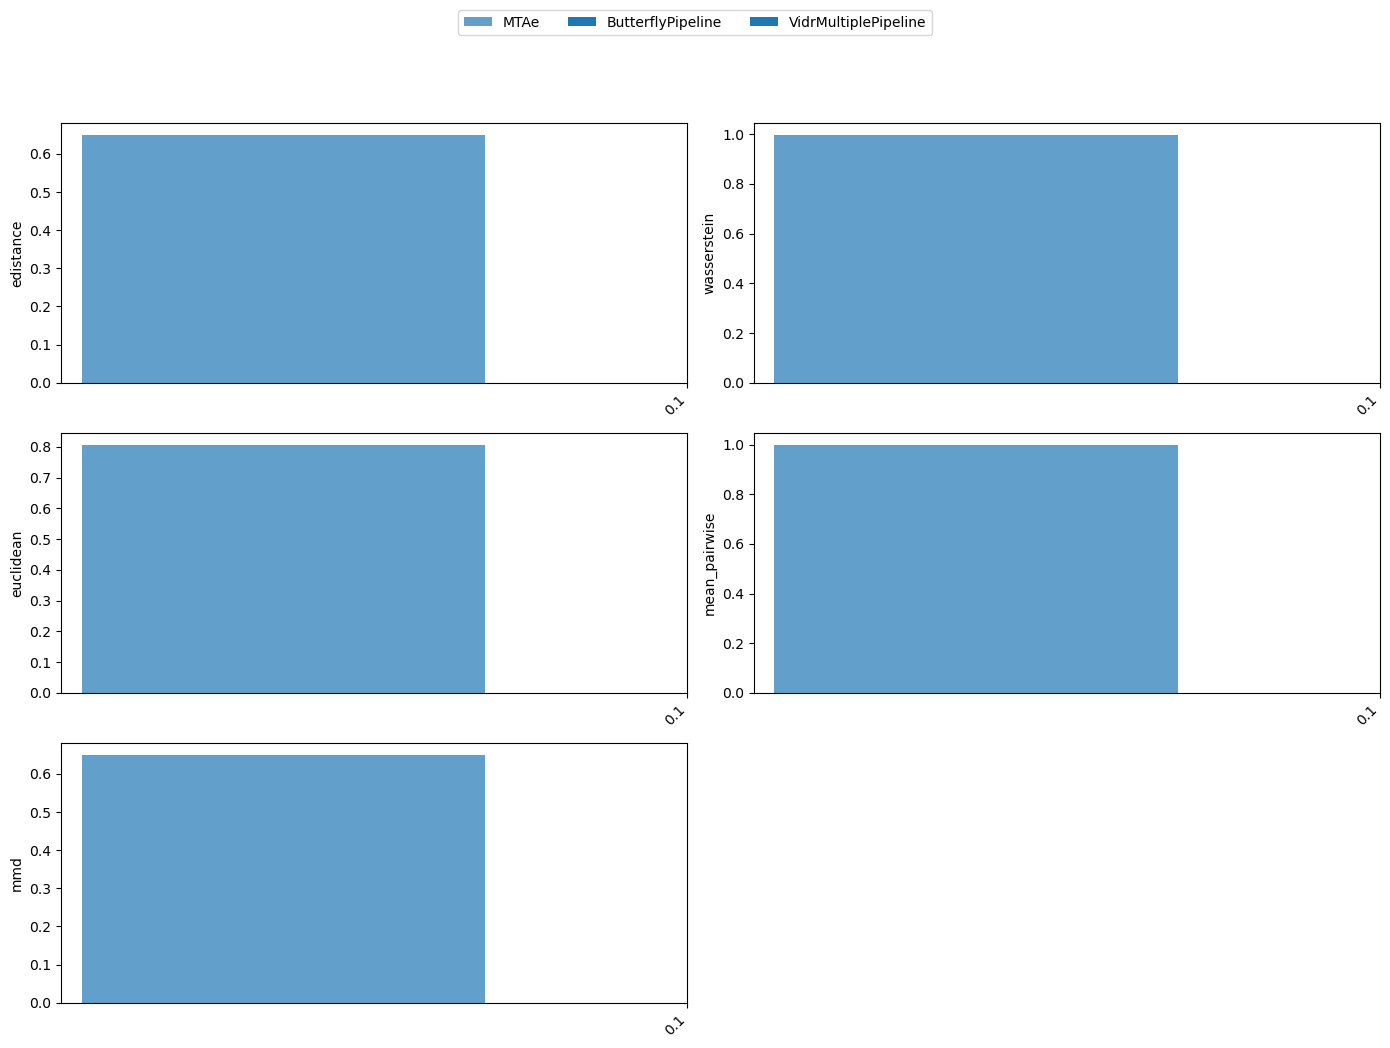

In [94]:
compare_multi_task_with_other_models(dose_to_test=0.1, best_threshold=70, worst_threshold=30)


['Hepatocytes - portal']


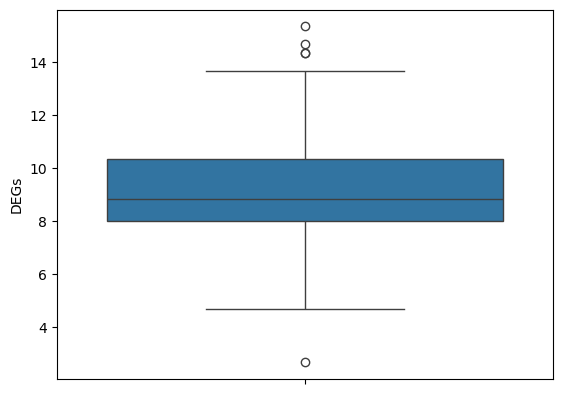

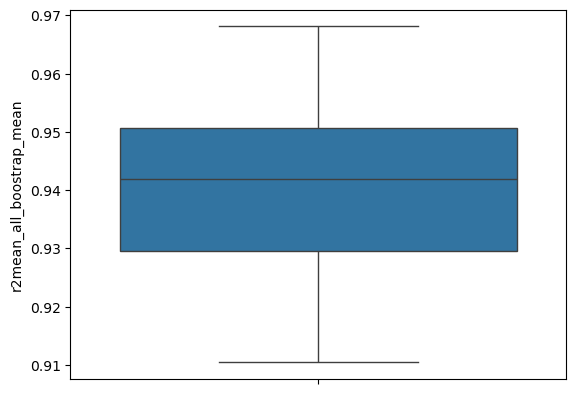

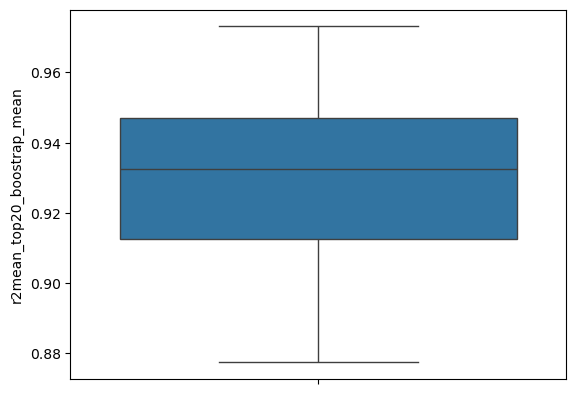

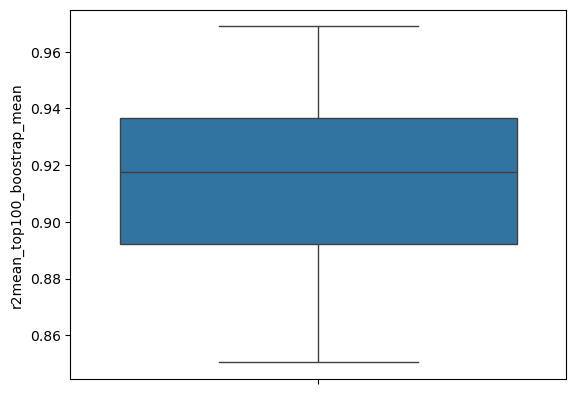

best cell type common {'dosage_0_03_0_3_1_0_10_0', 'dosage_0_01_0_03_1_0_3_0_10_0', 'dosage_0_01_0_03_0_1_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_03_0_3_1_0_3_0_10_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0', 'dosage_0_01_0_03_0_1_0_3_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0', 'dosage_0_03_3_0', 'dosage_0_01_0_03_10_0', 'dosage_0_01_0_03_0_3_3_0', 'dosage_0_03_0_1_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_10_0', 'dosage_0_01_0_03_1_0_3_0', 'dosage_0_01_0_03_3_0', 'dosage_0_01_0_03_0_1_3_0_10_0', 'dosage_0_03_0_3_10_0', 'dosage_0_03_1_0_3_0_10_0_30_0', 'dosage_0_03_10_0', 'dosage_0_03_3_0_10_0', 'dosage_0_01_0_03_0_1_0_3_1_0_10_0', 'dosage_0_03_0_1_3_0_10_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0', 'dosage_0_03_0_1_10_0', 'dosage_0_03_1_0_3_0_10_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0', 'dosage_0_03_0_1_1_0_3_0_10_0', 'dosage_0_03_1_0', 'dosage_0_03_1_0_10_0

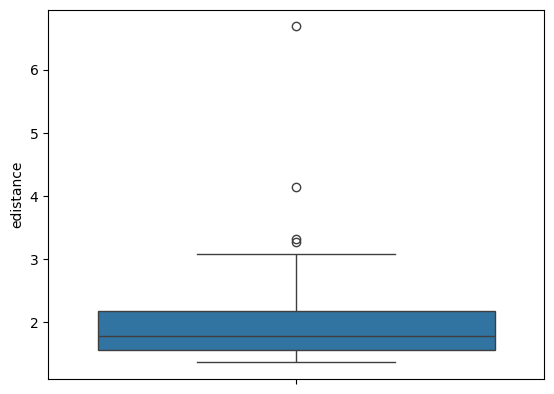

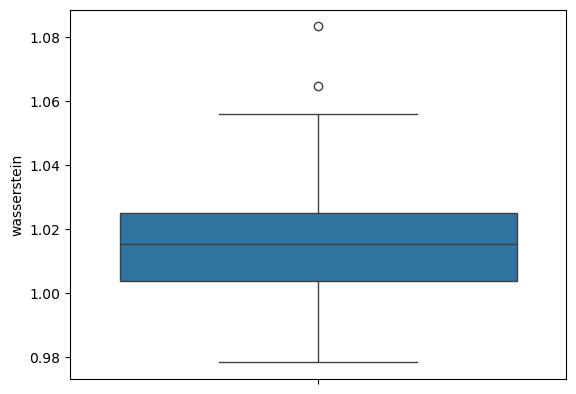

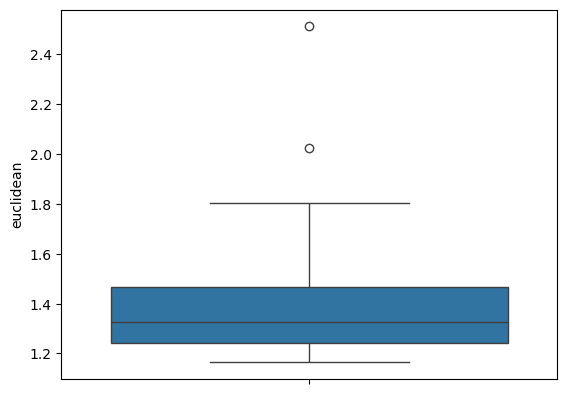

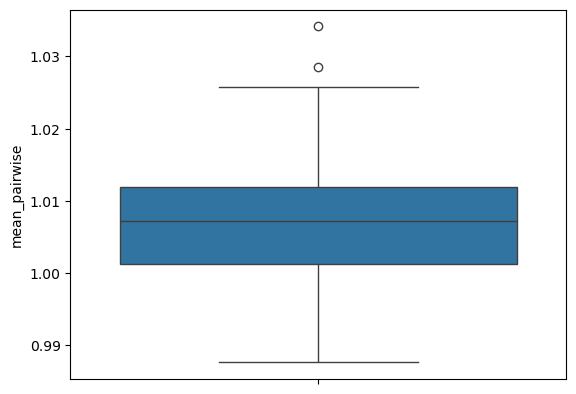

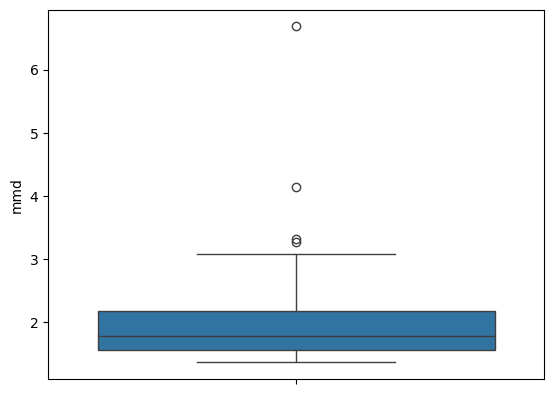

best cell type common {'dosage_0_03_0_1_0_3_3_0', 'dosage_0_01_0_03_1_0_3_0_10_0_30_0', 'dosage_0_03_30_0', 'dosage_0_01_0_03_0_1_3_0_10_0_30_0', 'dosage_0_01_0_03_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_30_0', 'dosage_0_01_0_03_0_3_1_0', 'dosage_0_03_3_0_30_0', 'dosage_0_01_0_03_0_1_3_0_30_0', 'dosage_0_03_0_1_0_3', 'dosage_0_03_1_0_30_0', 'dosage_0_03_0_1_1_0_10_0', 'dosage_0_03_0_1_3_0_10_0_30_0', 'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_3_0_30_0', 'dosage_0_03_0_3_3_0', 'dosage_0_03_10_0_30_0', 'dosage_0_01_0_03_0_3_10_0_30_0', 'dosage_0_03_0_3', 'dosage_0_01_0_03_0_1_1_0_3_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_03_0_1_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_3_3_0_10_0_30_0', 'dosage_0_03_0_3_1_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_30_0', 'dosage_0_01_0_03_1_0_3_0_30_0', 'dosage_0_03_0_1_1_

/tmp/ipykernel_1889726/2943155124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1889726/2943155124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1889726/2943155124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

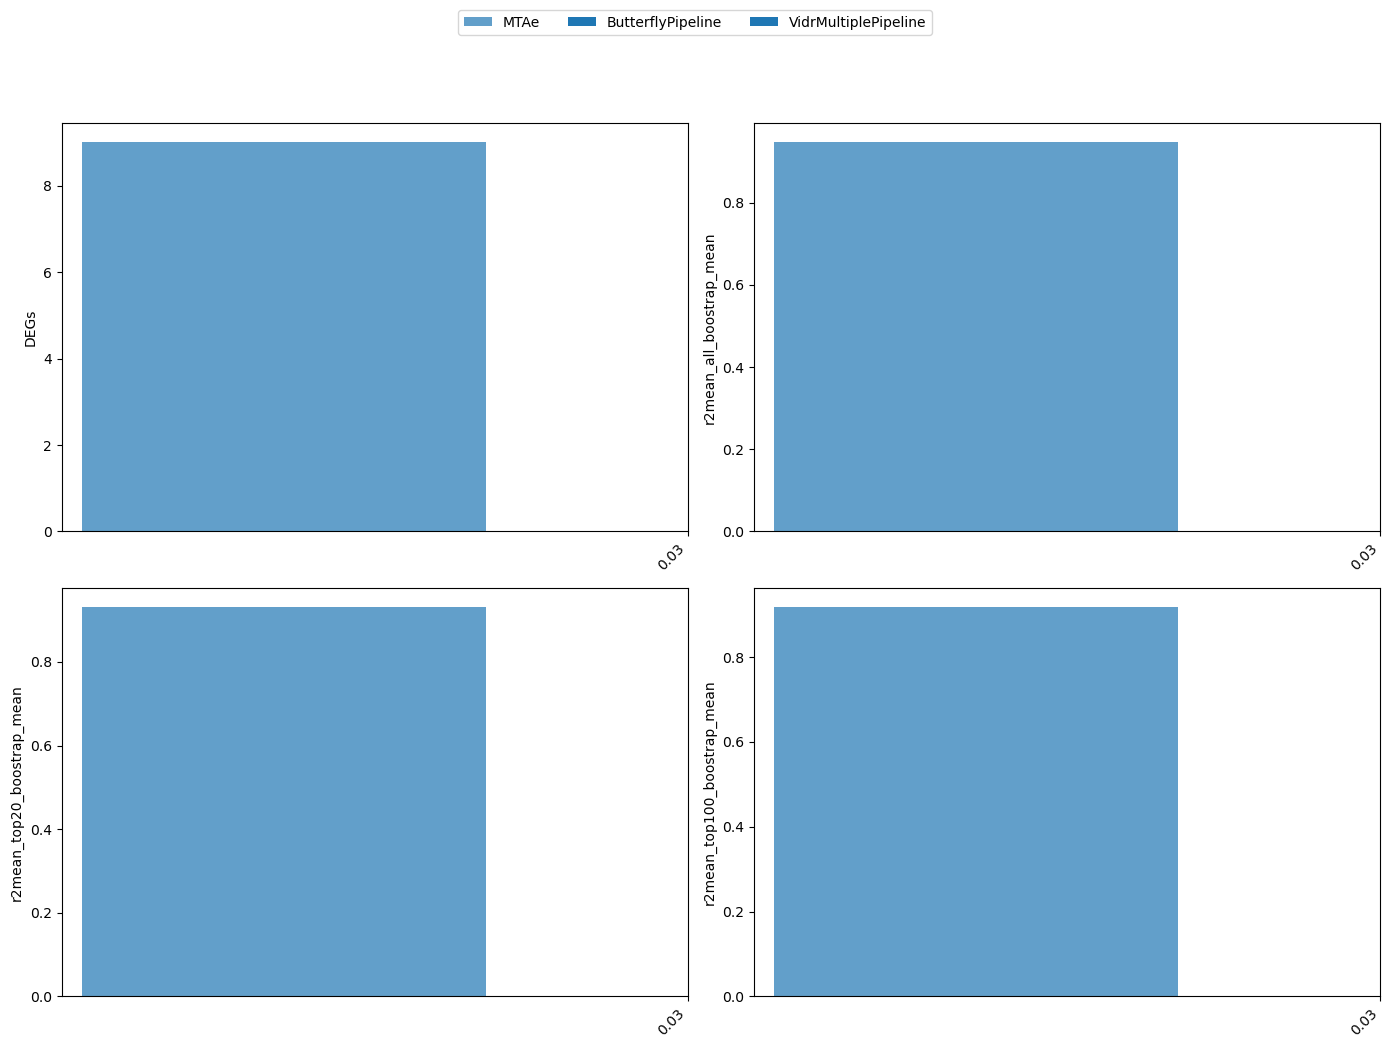

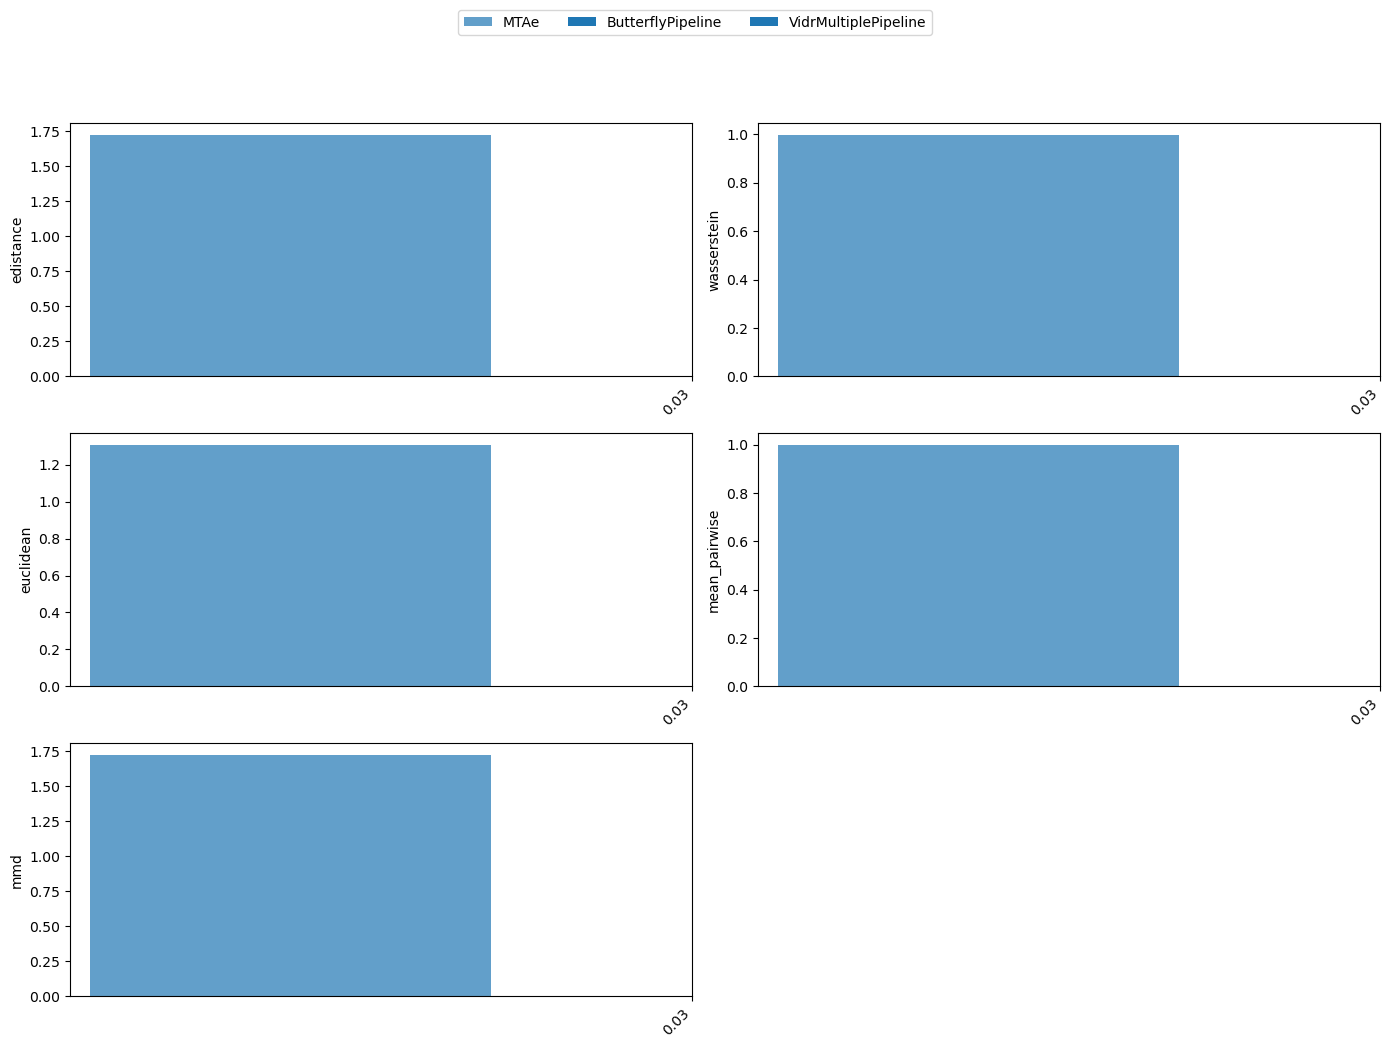

In [95]:
compare_multi_task_with_other_models(dose_to_test=0.03, best_threshold=70, worst_threshold=30)


In [96]:
best_experiment = 'dosage_0_1_0_3_10_0_30_0_19193'
dataset = METRICS_DF[METRICS_DF['experiment_name'] == best_experiment]
dataset

model                              dataset  \
4006  MTAe  NaultMultiplePipeline_NaultPipeline   
4009  MTAe  NaultMultiplePipeline_NaultPipeline   
4012  MTAe  NaultMultiplePipeline_NaultPipeline   
4014  MTAe  NaultMultiplePipeline_NaultPipeline   

                     experiment_name perturbation  dose  DEGs  r2mean  \
4006  dosage_0_1_0_3_10_0_30_0_19193         tcdd   0.1    36   0.980   
4009  dosage_0_1_0_3_10_0_30_0_19193         tcdd   0.3    17   0.956   
4012  dosage_0_1_0_3_10_0_30_0_19193         tcdd  10.0     8   0.746   
4014  dosage_0_1_0_3_10_0_30_0_19193         tcdd  30.0    34   0.687   

      r2mean_top20  r2mean_top100  r2mean_all_boostrap_mean  ...  \
4006         0.968          0.941                  0.979296  ...   
4009         0.970          0.992                  0.956128  ...   
4012         0.719          0.865                  0.746657  ...   
4014         0.801          0.885                  0.687502  ...   

            cell_type_test  average_mean_expressed_diff  \
4006  Hepatocytes - portal                     0.775812   
4009  Hepatocytes - portal                     0.757047   
4012  Hepatocytes - portal                     0.753337   
4014  Hepatocytes - portal                     0.763394   

     average_fractions_diff  average_mean_degs20_diff  \
4006               0.196442                  0.534822   
4009               0.168990                  0.492501   
4012               0.179603                  0.769065   
4014               0.222368                  0.719066   

      average_mean_degs100_diff  edistance  wasserstein  euclidean  \
4006                   0.592332   0.911988     1.072119   0.954980   
4009                   0.579031   1.414555     1.301244   1.189351   
4012                   0.759469  10.891676     2.933340   3.300257   
4014                   0.782867   5.329039     3.217285   2.308473   

      mean_pairwise        mmd  
4006       1.036827   0.911988  
4009       1.145985   1.414555  
4012       1.723637  10.891672  
4014       1.740820   5.329041  

[4 rows x 22 columns]

In [97]:
best_experiment = 'dosage_0_1_0_3_10_0_30_0_2'
dataset = METRICS_DF[METRICS_DF['experiment_name'] == best_experiment]
dataset

model                              dataset             experiment_name  \
2859  MTAe  NaultMultiplePipeline_NaultPipeline  dosage_0_1_0_3_10_0_30_0_2   
2868  MTAe  NaultMultiplePipeline_NaultPipeline  dosage_0_1_0_3_10_0_30_0_2   
2876  MTAe  NaultMultiplePipeline_NaultPipeline  dosage_0_1_0_3_10_0_30_0_2   
2882  MTAe  NaultMultiplePipeline_NaultPipeline  dosage_0_1_0_3_10_0_30_0_2   

     perturbation  dose  DEGs  r2mean  r2mean_top20  r2mean_top100  \
2859         tcdd   0.1    42   0.974         0.929          0.834   
2868         tcdd   0.3    22   0.976         0.986          0.996   
2876         tcdd  10.0    50   0.906         0.889          0.949   
2882         tcdd  30.0    31   0.659         0.792          0.876   

      r2mean_all_boostrap_mean  ...        cell_type_test  \
2859                  0.974188  ...  Hepatocytes - portal   
2868                  0.976366  ...  Hepatocytes - portal   
2876                  0.905540  ...  Hepatocytes - portal   
2882                  0.658684  ...  Hepatocytes - portal   

      average_mean_expressed_diff average_fractions_diff  \
2859                     0.770529               0.206929   
2868                     0.786410               0.201973   
2876                     0.806722               0.278549   
2882                     0.755276               0.205300   

      average_mean_degs20_diff  average_mean_degs100_diff  edistance  \
2859                  0.449492                   0.538249   0.593568   
2868                  0.492088                   0.609185   1.006992   
2876                  0.522916                   0.617940   0.759428   
2882                  0.740517                   0.791565  10.502955   

      wasserstein  euclidean  mean_pairwise        mmd  
2859     0.968018   0.770434       0.981937   0.593568  
2868     1.197633   1.003490       1.091901   1.006993  
2876     0.899650   0.871451       0.951913   0.759428  
2882     4.045522   3.240832       1.963480  10.502946  

[4 rows x 22 columns]

In [98]:
# there is a fair amount of variability by changing the seeds making harder to make any conclusions since the metrics are not consistent